<a id="intro"></a><h2> Introduction </h2>

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination. 

See the <a href="https://www.nature.com/articles/s41587-019-0068-4">Palantir paper</a> for more details.

<h3>scAGM Analysis:</h3>
 The way the Palantir analysis will be carried out is as follows. The Idea will be to draw a global trajectory among all conditions that will be stored. Afterwards for each condition the cells that comprise it will be extracted and the diverse plots will be produce in order to compare among each condition while preserving the same configurations for diffussion components multiscale data and palantir run.


## Imports

In [4]:
import palantir
import scanpy as sc
import numpy as np
import pandas as pd
import os

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Heatmap function
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

# Gene trends cond vs ctl
from collections import OrderedDict

# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Reset random seed
np.random.seed(5)

# Functions Used Throughout the Notebook

## Class Definitions

In [5]:
import pickle

class PResults(object):
    """
    Container of palantir results
    """

    def __init__(self, pseudotime, entropy, branch_probs, waypoints):

        # Initialize
        self._pseudotime = (pseudotime - pseudotime.min()) / \
            (pseudotime.max() - pseudotime.min())
        self._entropy = entropy
        self._branch_probs = branch_probs
        self._branch_probs[self._branch_probs < 0.01] = 0
        self._waypoints = waypoints

    # Getters and setters
    @property
    def pseudotime(self):
        return self._pseudotime

    @property
    def branch_probs(self):
        return self._branch_probs

    @branch_probs.setter
    def branch_probs(self, branch_probs):
        self._branch_probs = branch_probs

    @property
    def entropy(self):
        return self._entropy

    @entropy.setter
    def entropy(self, entropy):
        self._entropy = entropy

    @property
    def waypoints(self):
        return self._waypoints

    @classmethod
    def load(cls, pkl_file):
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)

        # Set up object
        presults = cls(data['_pseudotime'], data['_entropy'],
                       data['_branch_probs'], data['_waypoints'])
        return presults

    def save(self, pkl_file: str):
        pickle.dump(vars(self), pkl_file)



In [6]:
class PResults_2(object):
    """
    Container of palantir results
    """

    def __init__(self, pseudotime, entropy, branch_probs, waypoints):

        # Initialize
        self._pseudotime = (pseudotime - pseudotime.min()) / \
            (pseudotime.max() - pseudotime.min())
        self._entropy = entropy
        self._branch_probs = branch_probs
        self._branch_probs[self._branch_probs < 0.01] = 0
        self._waypoints = waypoints

    # Getters and setters
    @property
    def pseudotime(self):
        return self._pseudotime

    @property
    def branch_probs(self):
        return self._branch_probs

    @branch_probs.setter
    def branch_probs(self, branch_probs):
        self._branch_probs = branch_probs

    @property
    def entropy(self):
        return self._entropy

    @entropy.setter
    def entropy(self, entropy):
        self._entropy = entropy

    @property
    def waypoints(self):
        return self._waypoints

    @classmethod
    def load(cls, pkl_file):
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)

        # Set up object
        presults = cls(data['_pseudotime'], data['_entropy'],
                       data['_branch_probs'], data['_waypoints'])
        return presults

    def save(self, pkl_file: str):
        with open(pkl_file, 'wb') as f:
            pickle.dump(vars(self), f)

    @classmethod
    def from_old_format(cls, old_presults):
        # Create a new PResults_2 instance using the attributes of the old PResults
        return cls(
            old_presults.pseudotime,
            old_presults.entropy,
            old_presults.branch_probs,
            old_presults.waypoints
        )

# Example usage:
# Load an instance of the old PResults
# old_presults_instance = PResults.load("old_presults_data.pkl")

# Convert to the new format
# new_presults_instance = PResults_2.from_old_format(pr_res)

# Save the new instance to a file
# new_presults_instance.save("Palantir_results_scAGM.pkl")

In [5]:
class PResults_2(object):
    """
    Container of palantir results
    """

    def __init__(self, pseudotime, entropy, branch_probs, waypoints):

        # Initialize
        self._pseudotime = (pseudotime - pseudotime.min()) / \
            (pseudotime.max() - pseudotime.min())
        self._entropy = entropy
        self._branch_probs = branch_probs
        self._branch_probs[self._branch_probs < 0.01] = 0
        self._waypoints = waypoints

    # Getters and setters
    @property
    def pseudotime(self):
        return self._pseudotime

    @property
    def branch_probs(self):
        return self._branch_probs

    @branch_probs.setter
    def branch_probs(self, branch_probs):
        self._branch_probs = branch_probs

    @property
    def entropy(self):
        return self._entropy

    @entropy.setter
    def entropy(self, entropy):
        self._entropy = entropy

    @property
    def waypoints(self):
        return self._waypoints

    @classmethod
    def load(cls, pkl_file):
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)

        # Set up object
        presults = cls(data['_pseudotime'], data['_entropy'],
                       data['_branch_prob'], data['_waypoints'])
        return presults

    def save(self, pkl_file: str):
        with open(pkl_file, 'wb') as f:
            pickle.dump(vars(self), f)

## Function Definitions

`pseudotime_cell_bins` produces a histogram split into a previously specified number of bins where each bin has been normalized to 1, giving the proportion of celltypes across the pseudotime trayectory.

`plot_gene_trends_group_genes` creates a plot where various genes are plotted together from one condition.

`plot_gene_trends_heatmaps_v2` produces a heatmap of various genes that can be clusterized hierarchically. 

`setup_gene_trends_cond_vs_ctl` creates gene trends from substracting the control gene trend to a condition. this is carried with all conditions in the dataset.`setup_gene_trends_selected_cond_vs_ctl` does the same but using selected goi per condition.



In [7]:
def pseudotime_cell_bins(ad, celltype = "Celltype", pseudotime = "palantir_pseudotime", colors = None, order = None, bins = 25):

    table_pseudotime = ad.obs[[pseudotime, celltype]].copy()

    # new_levels = {'Conflux endo [AE]': 'Aorta Endothelium', 'Pre-HE [AE]': 'Pre-HE', 'HE': 'HE', 'IAC': 'IAC'}

    # table_pseudotime["FinalClustering"] = table_pseudotime["FinalClustering"].replace(new_levels)
    # table_pseudotime

    #  Get values into workable bins
    table_pseudotime['bin'] = pd.cut(table_pseudotime[pseudotime], bins=np.linspace(0, 1, num=bins), include_lowest=True, labels=False)
    table_pseudotime

    # Count the number of occurrences of each type in each bin
    bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)

    # Normalize the counts to get the proportion for each bin
    bin_proportions = bin_counts.div(bin_counts.sum(axis=1), axis=0)

    # Plotting
    sns.set(style="white")
    plt.figure(figsize=(12, 8))

    # Plot a stacked line plot for each bin using stackplot
    bins = bin_proportions.index
    types = bin_proportions.columns

    fig, ax = plt.subplots(figsize=(12, 8))
    # labels = ["Aorta Endothelium", "Pre-HE", "HE", "IAC"]
    labels = ad.obs[celltype].unique()
    stack_data_list = []
    for i,bin in enumerate(bin_proportions.columns):
        bin_data = bin_proportions[bin]
        stack_data_list.append(bin_data)
    if order is not None:
        stack_data_list = [stack_data_list[i] for i in order]
        types = [types[i] for i in order]

    # # ax.stackplot(bins, bin_proportions["Aorta Endothelium"], bin_proportions["Pre-HE"], bin_proportions["HE"], bin_proportions["IAC"], labels=labels, colors= ["#ADFF2F", "#FFD700", "#FFA500", "#CD5C5C"])
    ax.stackplot(bins, stack_data_list, labels=types, colors= colors)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 20)
    ax.set_xlabel('Pseudotime bins', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)

    ax.set_ylabel('Cell Type Proportion', fontsize = 20)
    ax.grid(False)
plt.show()


# fig, ax = plt.subplots()
# ax.stackplot(x, y)
# plt.show()

# fig.savefig("Cell_pseudotime_proportions.pdf", format="pdf", bbox_inches="tight")

# fig.savefig("Cell_pseudotime_proportions.jpeg", format="jpeg", bbox_inches="tight")

In [8]:
def plot_gene_trends_group_genes(gene_trends, genes=None, main='Gene Trends by group', plot_deviation = False):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """

    # Branches and genes
    
    branches = list(gene_trends.keys())
    colors = pd.Series(
        sns.color_palette("Set2", len(branches)).as_hex(), index=branches
    )



    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    

    # Set up figure
    gene_colors = pd.Series(
        sns.color_palette("Set2", len(genes)).as_hex(), index=genes
        )
    fig = plt.figure(figsize=[7, 3])



    fig = plt.figure(figsize=[7, 3 * len(branches)])
    for n, branch in enumerate(branches):
        ax = fig.add_subplot(len(branches), 1, n + 1)
        trends = gene_trends[branch]["trends"]
        if plot_deviation == True:
         stds = gene_trends[branch]["std"]
        for i, gene in enumerate(genes):
            ax.plot(
                trends.columns, trends.loc[gene, :], color=gene_colors[gene], label=gene
            )
            ax.set_xticks([0, 1])
            if plot_deviation == True:
                ax.fill_between(
                    trends.columns,
                    trends.loc[gene, :] - stds.loc[gene, :],
                    trends.loc[gene, :] + stds.loc[gene, :],
                    alpha=0.1,
                    color=gene_colors[gene],
                )
           
            ax.set_title(main)
        # Add legend
            lgd = ax.legend(bbox_to_anchor=(1.05, 1), fontsize="10",
                         loc='upper left', borderaxespad=0.)

    sns.despine()


In [9]:
def plot_gene_trend_heatmaps_v2(gene_trends, cmap= matplotlib.cm.Spectral_r, cluster_rows = True, title = ""):
# """ Plot the gene trends on heatmap: a heatmap is generated or each branch
#     :param: 
#     gene_trends:
#       Results of the compute_marker_trends function
#             """

    # Plot height\n
    branches = list(gene_trends.keys())
    genes = gene_trends[branches[0]]["trends"].index
    height = 0.6 * len(genes) * len(branches)
    #  Set up plot\n    
    fig = plt.figure(figsize=[7.7, height])
    for i, branch in enumerate(branches):
        ax = fig.add_subplot(len(branches), 1, i+1)
        # Standardize the matrix\n
        mat = gene_trends[branch]["trends"]
    mat = pd.DataFrame(StandardScaler().fit_transform(mat.T).T,
                   index=mat.index,
                    columns=mat.columns,)

    if cluster_rows == True :
        row_linkage = hierarchy.linkage(mat, method='average', metric='euclidean')
        row_order = hierarchy.dendrogram(row_linkage, no_plot=True)['leaves']

        clustered_data = mat.iloc[row_order]

        sns.heatmap(clustered_data, yticklabels=clustered_data.index, xticklabels=False, ax=ax, cmap=cmap)

    else:
        sns.heatmap(mat, yticklabels=mat.index, xticklabels=False, ax=ax, cmap=cmap)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize = 18)
    ax.set_title(title, fontsize=12)
# Get the colorbar from the Heatmap
    cbar = ax.collections[0].colorbar
# Here we use the colorbar object to change the tick label size
    cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

<Figure size 400x400 with 0 Axes>

In [10]:
def setup_gene_trends_cond_vs_ctl(ad_all, genes, Cell_ID, Control_name = 'Control', Conditions = 'Control', Condition_name = None, Control_text = 'Control'):
 if Condition_name is None:
    Condition_name = Conditions
 for i,cond in enumerate(Conditions):
    ad = ad_all[Cell_ID[cond],:]
    cond_text = Condition_name[i]
    # Produced imputed dataframe

    genes = genes

    # Without MAGIC

    gene_trends_cond = palantir.presults.compute_gene_trends(ad)
    
    gene_trends_cond = {condition: {'trends': data['trends'].loc[genes]} for condition, data in gene_trends_cond.items()}
    
# Gene trends for Control 
    ad = ad_all[ad_all.obs['Condition'].isin([Control_name]),:]

    gene_trends_ctl = palantir.presults.compute_gene_trends(ad)
    
    gene_trends_ctl = {condition: {'trends': data['trends'].loc[genes]} for condition, data in gene_trends_ctl.items()}

    cond_dir = str.replace(cond, " ", "_")
    
    # Assuming 'gene_trends_cond['IAHC']['trends'].shape[1]' gives the number of columns
    num_cols = gene_trends_cond['IAHC']['trends'].shape[1]

    # Generate a sequence of numbers from 0 to 1, with the same number of steps as the number of columns
    new_columns = np.linspace(0, 1, num_cols)

    # Assign the new column names
    gene_trends_cond['IAHC']['trends'].columns = new_columns

    gene_trends_ctl['IAHC']['trends'].columns = new_columns

    # gene_trends_cond['IAHC']['trends'].columns =range(0, gene_trends_cond['IAHC']['trends'].shape[1])
    
    # gene_trends_ctl['IAHC']['trends'].columns =range(0, gene_trends_ctl['IAHC']['trends'].shape[1])

    gene_trends_sub = gene_trends_cond['IAHC']['trends'].sub(gene_trends_ctl['IAHC']['trends'])

    gene_trends_sub

    gene_trends = OrderedDict()

    inner_dict = OrderedDict({'trends': gene_trends_sub})

    gene_trends['IAHC'] = inner_dict
    
    os.makedirs(''.join([cond_dir, "/CondvCtl"]), exist_ok=True)

    plot_gene_trends_group_genes(gene_trends, genes = ['Efnb2','Sox17','Notch1', 'Notch4', 'Dll4', 'Jag1', 'Jag2'], main= ''.join(["Notch Signaling ", cond_text," vs ", Control_text]))

    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_group_Notch.png"]), dpi = 'figure', bbox_inches='tight')
    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_group_Notch.pdf"]), format = 'pdf', bbox_inches='tight')

    plot_gene_trends_group_genes(gene_trends, genes = ['Hey1', 'Mfng', 'Hes1', 'Hey2', 'Gata2'], main= ''.join(["Notch Signaling ", cond_text," vs ", Control_text]))

    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_group_Notch_downstream.png"]), dpi = 'figure', bbox_inches='tight')
    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_group_Notch_downstream.pdf"]), format = 'pdf', bbox_inches='tight')

    plot_gene_trends_group_genes(gene_trends, genes = ['Mecom', 'Mllt3', 'Procr', 'Runx1', 'Kit', 'Gfi1'], main= ''.join(["EHT ", cond_text," vs ", Control_text]))

    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_group_EHT.png"]), dpi = 'figure', bbox_inches='tight')
    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_group_EHT.pdf"]), format = 'pdf', bbox_inches='tight')
    
    plot_gene_trends_group_genes(gene_trends, genes = ['Ikzf2', 'Myb', 'Hlf', 'Mpo', 'Mycn', 'Myc'], main= ''.join(["EHT ", cond_text," vs ", Control_text]))

    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_group_EHT_downstream.png"]), dpi = 'figure', bbox_inches='tight')
    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_group_EHT_downstream.pdf"]), format = 'pdf', bbox_inches='tight')

    plot_gene_trend_heatmaps_v2(gene_trends, cmap="RdBu_r", cluster_rows=True)

    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_heatmaps.png"]), dpi = 'figure', bbox_inches='tight')
    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_heatmaps.pdf"]), format = 'pdf', bbox_inches='tight')

In [11]:
def setup_gene_trends_selected_cond_vs_ctl(ad_all, genes, Cell_ID, Control_name = 'Control', Conditions = 'Control', Condition_name = None, Control_text = 'Control'):
 if Condition_name is None:
    Condition_name = Conditions
 for i,cond in enumerate(Conditions):
    ad = ad_all[Cell_ID[cond],:]
    target_genes = genes[i]
    cond_text = Condition_name[i]
    # Without MAGIC

    gene_trends_cond = palantir.presults.compute_gene_trends(ad)
    
    gene_trends_cond = {condition: {'trends': data['trends'].loc[target_genes]} for condition, data in gene_trends_cond.items()}
    
# Gene trends for Control 
    ad = ad_all[ad_all.obs['Condition'].isin([Control_name]),:]

    gene_trends_ctl = palantir.presults.compute_gene_trends(ad)
    
    gene_trends_ctl = {condition: {'trends': data['trends'].loc[target_genes]} for condition, data in gene_trends_ctl.items()}

    cond_dir = str.replace(cond, " ", "_")
    
     # Assuming 'gene_trends_cond['IAHC']['trends'].shape[1]' gives the number of columns
    num_cols = gene_trends_cond['IAHC']['trends'].shape[1]

    # Generate a sequence of numbers from 0 to 1, with the same number of steps as the number of columns
    new_columns = np.linspace(0, 1, num_cols)

    # Assign the new column names
    gene_trends_cond['IAHC']['trends'].columns = new_columns

    gene_trends_ctl['IAHC']['trends'].columns = new_columns

    gene_trends_sub = gene_trends_cond['IAHC']['trends'].sub(gene_trends_ctl['IAHC']['trends'])

    # gene_trends_sub

    gene_trends = OrderedDict()

    inner_dict = OrderedDict({'trends': gene_trends_sub})

    gene_trends['IAHC'] = inner_dict
    
    os.makedirs(''.join([cond_dir, "/CondvCtl"]), exist_ok=True)

    plot_gene_trends_group_genes(gene_trends, genes = target_genes, main= ''.join([cond_text," vs ", Control_text]))

    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_selected.png"]), dpi = 'figure', bbox_inches='tight')
    plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_selected.pdf"]), format = 'pdf', bbox_inches='tight')


<a id="data"></a><h2> Loading data </h2>

We recommend the use of <a href="https://scanpy-tutorials.readthedocs.io/en/latest/index.html">scanpy</a> <a href="https://anndata.readthedocs.io/en/latest/">Anndata</a> objects as the preferred mode of loading and filtering data. 

In [12]:
# Download anndata file using
# !wget https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad -O "S:\\LAB_RB\\LAB\\Alvaro\\Bioinformatics\\Tutorials\\Python\\Palantir"
os.getcwd()

# Specify Plot directory

# os.chdir('../../Plots/Paper/Palantir/Final/')

# For Celltype

os.chdir('../../Plots/Paper/Palantir_Celltype/')


In [13]:
os.getcwd()

'/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/Plots/Paper/Palantir_Celltype'

In [21]:
os.getcwd()

'/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/Plots/Paper/Palantir_Celltype'

In [25]:
# Load sample data

# My dataset
palantir_dir = "../../../anndata/"
ad_all_old = sc.read(palantir_dir + 'scAGM_Clean_v3_Main_Final.h5ad')
ad_all = sc.read(palantir_dir + 'scAGM_Clean_v4.Ctrl.MfngGOF.Notch1GOF.NmycLOF.CtrlVEQ.Notch1LOF.Jag1LOF.VEQ.Transgenes_EHT.h5ad')

ad_all

Only considering the two last: ['.Transgenes_EHT', '.h5ad'].
Only considering the two last: ['.Transgenes_EHT', '.h5ad'].


AnnData object with n_obs × n_vars = 1778 × 18310
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'seurat_clusters', 'hash.ID', 'Condition', 'predicted.id', 'ZhuClustering', 'FinalClustering', 'Condition_Clustering', 'Driver', 'FinalClustering_old', 'Notch_Pathway_1', 'EHT_2', 'HSC_Scorecard_3', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALING', 'HAL

In [23]:
ad_all.obs["Celltype"].unique()

array(['Arterial ECs', 'Pre-HE', 'HE', 'Aorta ECs', 'IAHC'], dtype=object)

In [26]:
# Pass the vst.features to the ad_all object

ad_all.var = ad_all_old.var

<b>NOTE</b>: Counts are assumed to the normalized. If you have already normalized the data, skip past the `Normalization` section

## Data processing

### Normalization

Normalize the data for molecule count distribution using the `scanpy` interface

In [28]:
# sc.pp.normalize_per_cell(ad)

# Alternatively, from Seurat object where highly variable features have been selected, extract the boolean values of the selected features
y = ad_all.var.get("vst.variable")

y_bool=list(map(bool, y))
ad_all.var['highly_variable'] = y_bool

ad = ad_all

# Setting up dataset

I used previously computed HVG (2000 genes) and PCA from Seurat which were carried on in the anndata object

In [38]:
ad.obs["Celltype"].unique()

array(['Arterial ECs', 'Pre-HE', 'HE', 'Aorta ECs', 'IAHC'], dtype=object)

In [42]:
# Remove Arterial ECs

cluster_indices = ad.obs.index[ad.obs['Celltype'] == 'Arterial ECs']

ad = ad[ad.obs["Celltype"] != "Arterial ECs"]

In [43]:
ad

View of AnnData object with n_obs × n_vars = 1387 × 18310
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'seurat_clusters', 'hash.ID', 'Condition', 'predicted.id', 'ZhuClustering', 'FinalClustering', 'Condition_Clustering', 'Driver', 'FinalClustering_old', 'Notch_Pathway_1', 'EHT_2', 'HSC_Scorecard_3', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALIN

It is recommended that the data be log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale.

Data was log transformed with Seurat as well as selection of highly variable genes and PCA 

### Diffusion maps

Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data. Optimal results were found with 15 diffussion components and a knn of 30

In [45]:
# Run diffusion maps

# For Bmx Aorta ECs 15 components were used at knn 30

# pca_projections = pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names)
dm_res = palantir.utils.run_diffusion_maps(ad
    # pca_projections
    , n_components= 15
    , knn=30
    # , knn=15
 )

/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/utils.py:479: ImplicitModificationWarning: Setting element `.obsp['DM_Kernel']` of view, initializing view as actual.
  data.obsp[kernel_key] = res["kernel"]


In [46]:
dm_res.keys()

dict_keys(['T', 'EigenVectors', 'EigenValues', 'kernel'])

In [47]:
list(dm_res.values())[0]

<1387x1387 sparse matrix of type '<class 'numpy.float64'>'
	with 58628 stored elements in Compressed Sparse Row format>

The low dimensional embeddeing of the data is estimated based on the eigen  gap using the following function

In [48]:

# Store the dm_res results in the ann data object for future imputation and downsampling. It does not work with the "T" key which is the one needed for carrying the imputation

second_values = list(dm_res.values())[1]

ad.obsm["dm_res"] = np.array(second_values)



array([[-0.02685108, -0.04701192,  0.00682906, ...,  0.01822659,
         0.0097507 , -0.02331037],
       [-0.02685108,  0.00896296, -0.03048252, ...,  0.0190417 ,
        -0.01479864,  0.01521991],
       [-0.02685108, -0.05006182,  0.03228073, ...,  0.01517772,
         0.01013618, -0.03395825],
       ...,
       [-0.02685108,  0.01267775, -0.01538101, ..., -0.00767041,
        -0.01219823, -0.0053659 ],
       [-0.02685108, -0.05001866,  0.03325879, ..., -0.025171  ,
        -0.01651736,  0.04687564],
       [-0.02685108,  0.0174147 ,  0.00415558, ..., -0.04814874,
         0.02695952, -0.02538988]])

In [49]:
ms_data = palantir.utils.determine_multiscale_space(ad)

In [157]:
ms_data.head()

0         1         2         3         4  \
AAACGAAGTCAACCTA-1_1 -4.614621  0.096319  0.110131  0.017112 -0.055026   
AAACGCTCACGACGAA-1_1  0.879791 -0.429933 -0.518558 -0.156637  0.095320   
AAACGCTCAGAAATCA-1_1 -4.913995  0.455295 -0.060333 -0.024665 -0.001892   
AAAGGGCTCAAGAAAC-1_1  0.976682 -0.251565 -0.272806 -0.012423  0.068522   
AAAGTCCGTTCTCTAT-1_1  1.477908  0.015988 -0.112599  0.242656  0.090259   

                             5  
AAACGAAGTCAACCTA-1_1  0.003981  
AAACGCTCACGACGAA-1_1  0.385695  
AAACGCTCAGAAATCA-1_1  0.017801  
AAAGGGCTCAAGAAAC-1_1 -0.227444  
AAAGTCCGTTCTCTAT-1_1 -0.024069

If you are specifying the number of eigen vectors manually in the above step, please ensure that the specified parameter is > 2

### Visualization

In the manuscript, we used tSNE projection using diffusion components to visualize the data. We now recommend the use of force-directed layouts for visualization of trajectories. Force-directed layouts can be computed by the same adaptive kernel used for determining diffusion maps. `tSNE` on diffusion components can still be computed using the function `tsne = palantir.utils.run_tsne(ms_data)`.

`scanpy` can be used to compute force directed layouts. We recommened the use of the diffusion kernel (see below) for computing force directed layouts
`Force Atlas` package should be installed for this analysis and can be installed using `conda install -c conda-forge fa2`. Note that fa2 is not supported by python3.9

UMAPs are a good alternative to visualize trajectories in addition to force directed layouts.

UMAP or FDL results can be visualized by the `plot_tsne` function.

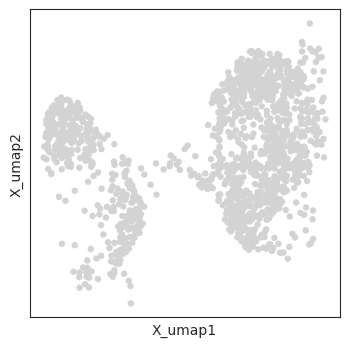

In [51]:
# Use scanpy functions to visualize umaps or FDL
sc.pl.embedding(ad, basis='X_umap')

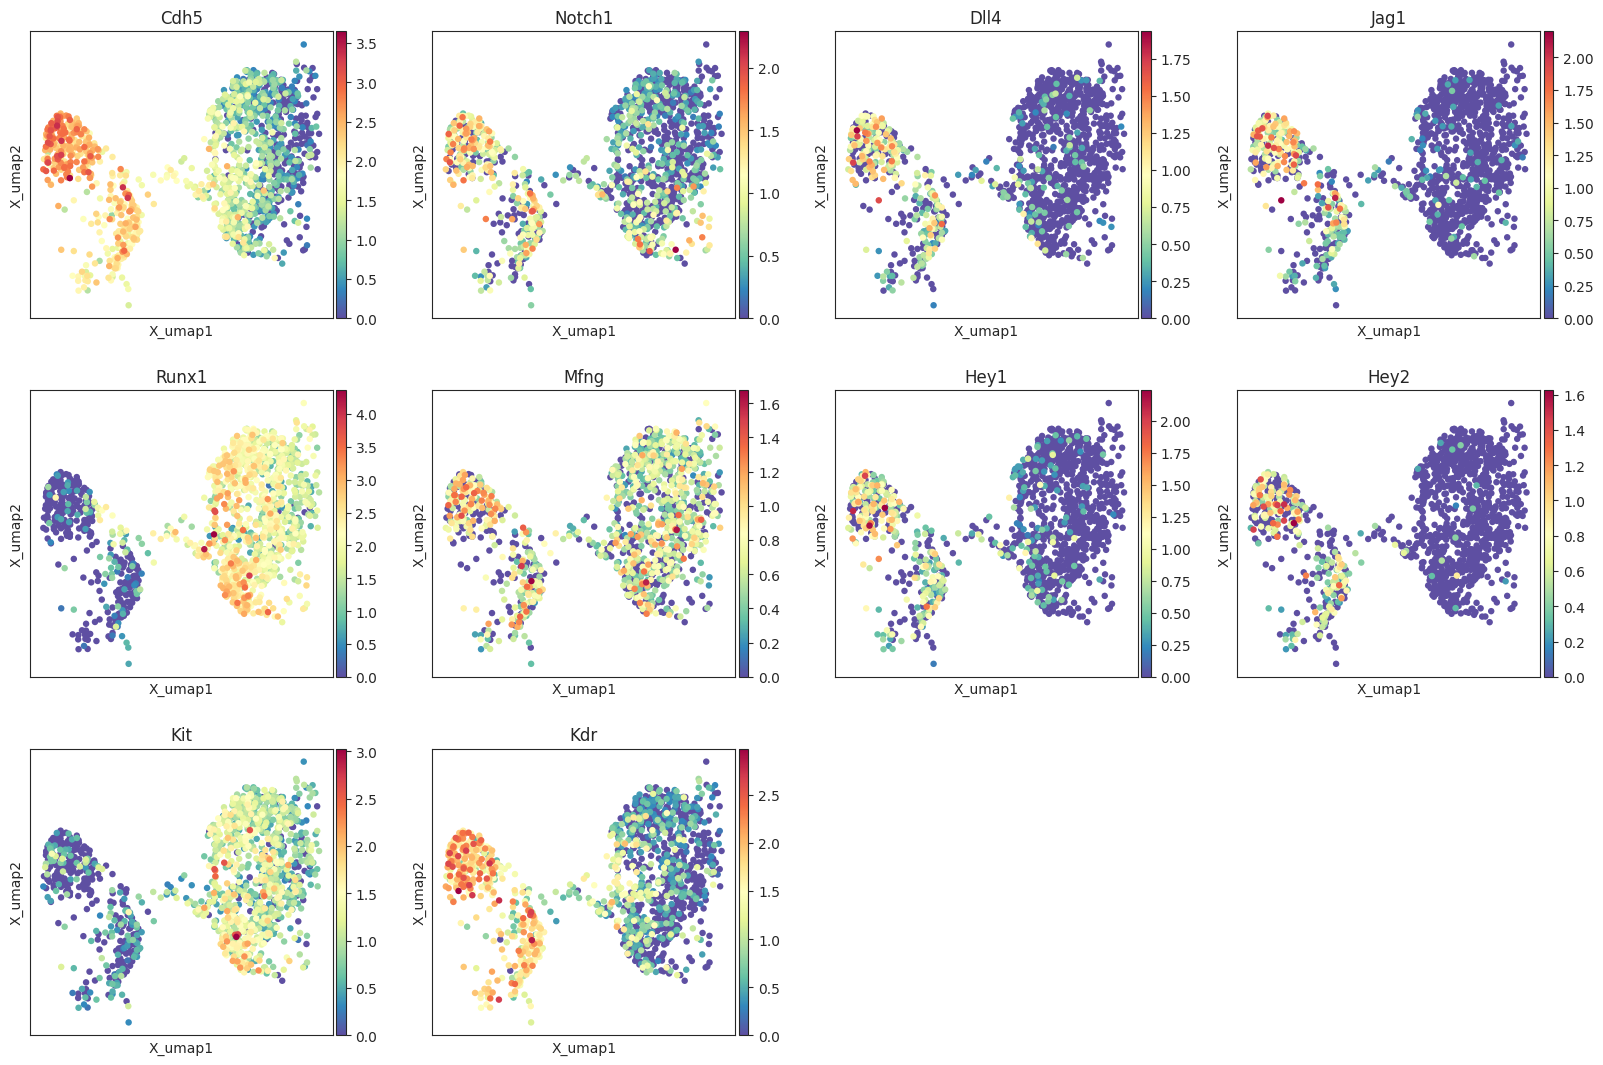

In [52]:

sc.pl.embedding(ad, basis='X_umap', use_raw = False,
               color=['Cdh5', 'Notch1', 'Dll4', 'Jag1', 'Runx1', 'Mfng', 'Hey1', 'Hey2', 'Kit', 'Kdr'], 
            #    save="_EHT_without_MAGIC.png"
               )



### Diffusion maps visualization

The computed diffusion components can be visualized with the following snippet. THis diffusion components will be kept in all conditions

In [53]:
umap = pd.DataFrame(ad.obsm['X_umap'], index=ad.obs_names)

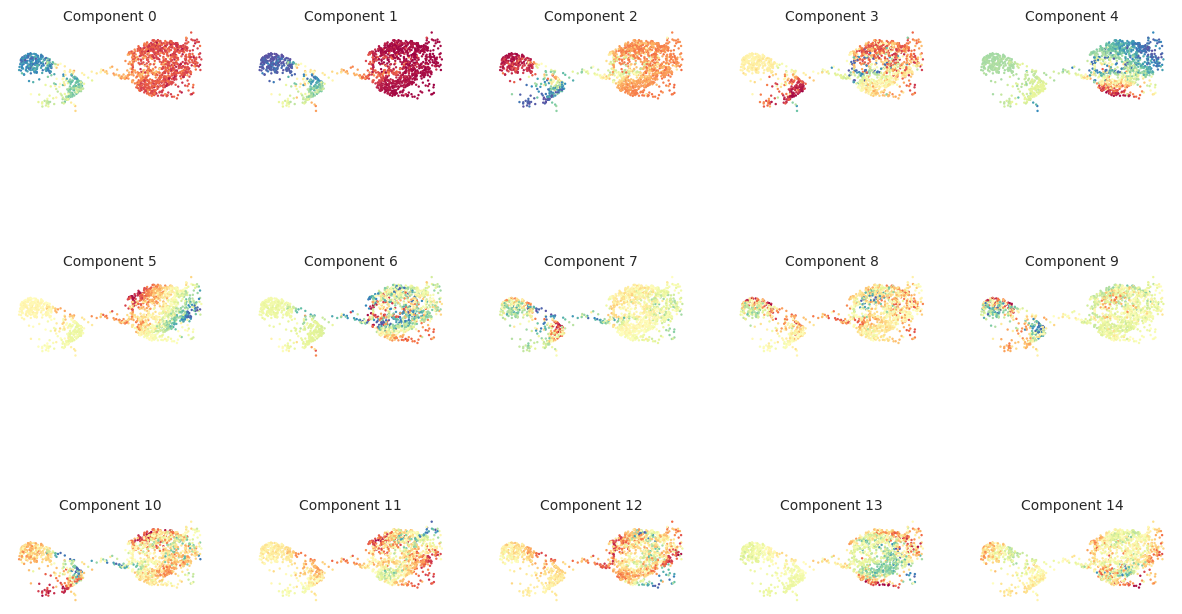

In [56]:
# palantir.plot.plot_diffusion_components(umap, dm_res)

palantir.plot.plot_diffusion_components(ad)
plt.show()
# plt.savefig("Diffusion_Components.png", dpi = 300)

<a id="palantir"></a><h2> Running Palantir </h2>

Palantir can be run by specifying an approxiate early cell. 

Palantir can automatically determine the terminal states as well. In this dataset, we know the terminal states and we will set them using the ```terminal_states``` parameter

The start cell for this dataset was chosen based on high expression of Bmx, and the terminal cell will be based on high expression of Myc

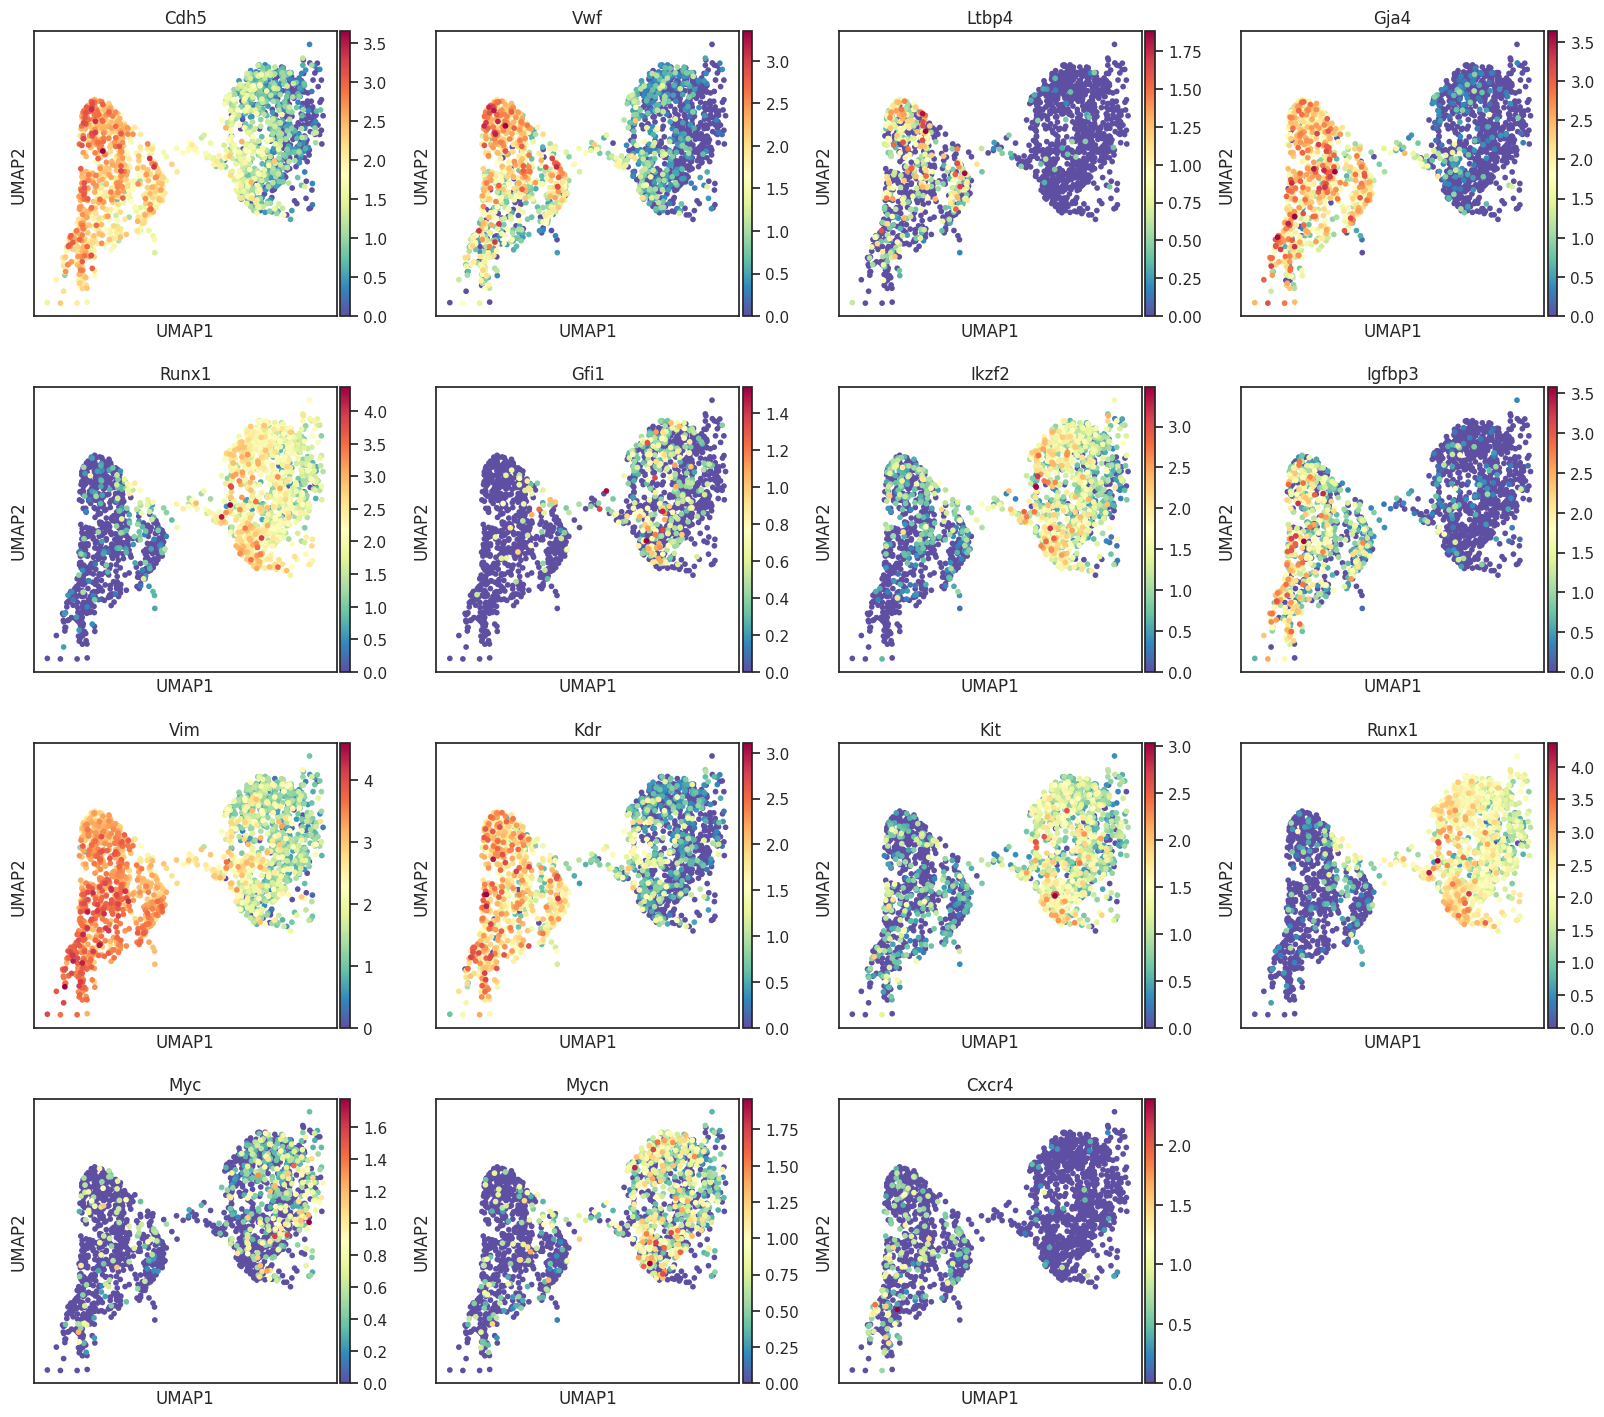

In [628]:
sc.pl.umap(ad_all, color=['Cdh5', 'Vwf', 'Ltbp4', 'Gja4', 'Runx1', 'Gfi1', 'Ikzf2', 'Igfbp3', 'Vim', 'Kdr', 'Kit', 'Runx1', 'Myc', "Mycn", "Cxcr4"], use_raw = False)

In [57]:
genedf = sc.get.obs_df(
        ad,
        keys=["Cxcr4", "Kdr", "Bmx","Myc"],
        obsm_keys=[("X_umap", 0), ("X_umap", 1)]
)


start_cell_data = genedf.loc[genedf[
        # "Cxcr4"
        "Bmx"
        # "Kdr"
        ].idxmax()]
start_cell = start_cell_data.name
terminal_cell_data = genedf.loc[genedf["Myc"].idxmax()]
terminal_cell = terminal_cell_data.name

(<Figure size 400x400 with 1 Axes>, <Axes: >)

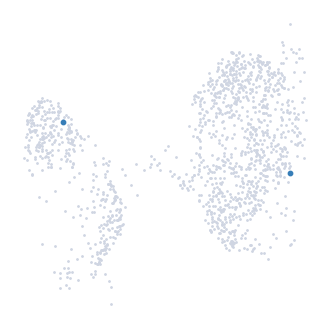

In [58]:
start_cell

cells = [start_cell, terminal_cell]

palantir.plot.highlight_cells_on_umap(ad, cells)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0038132270177205405 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.0608035405476888 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


(<Figure size 400x400 with 1 Axes>, <Axes: >)

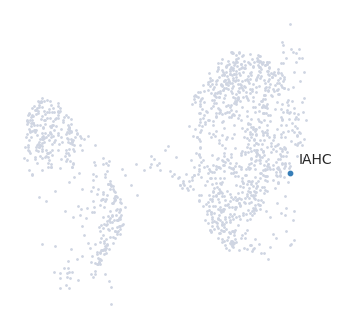

In [59]:

terminal_states = pd.Series(['IAHC'], 
                           index=[terminal_cell])

pr_res = palantir.core.run_palantir(ad, early_cell=start_cell,
    # ms_data, , 
    terminal_states=terminal_states,
    num_waypoints=2000, use_early_cell_as_start=True, knn=30)

genes = ['Cdh5', 'Notch1', 'Mycn', 'Runx1']

palantir.plot.highlight_cells_on_umap(ad, terminal_states)

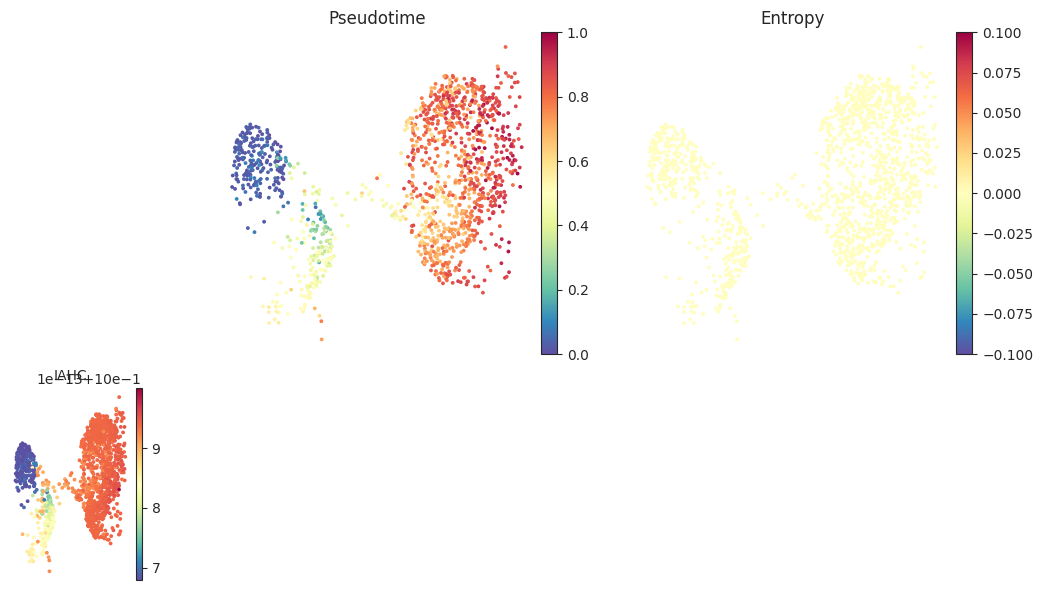

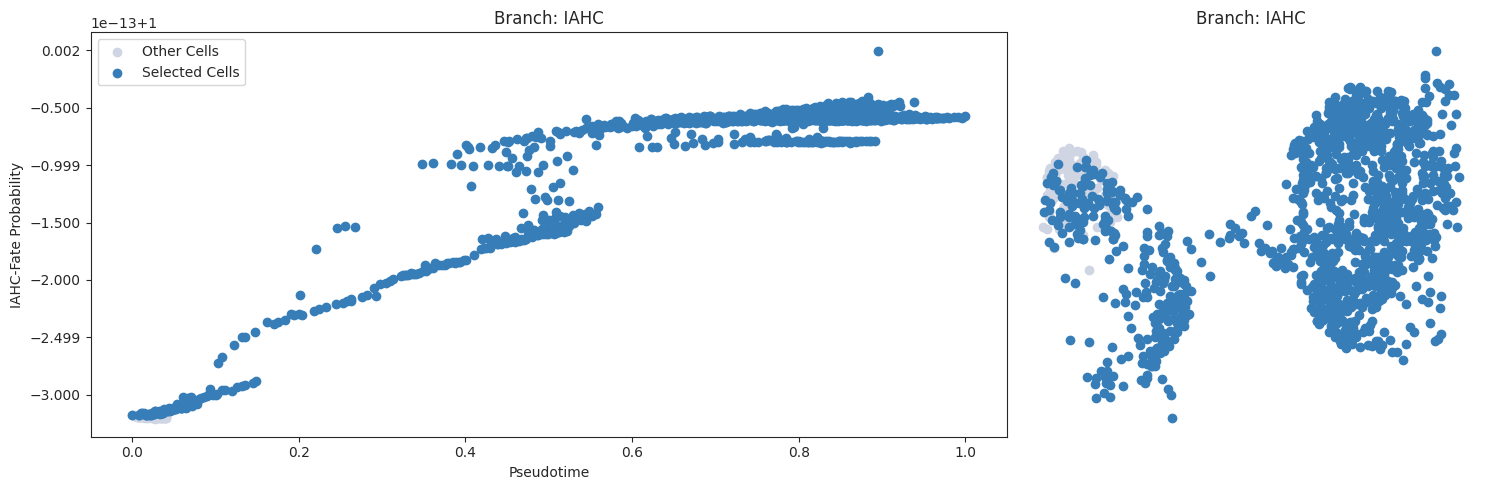

In [61]:
# palantir.plot.plot_trajectory(ad, "IAHC")

palantir.plot.plot_palantir_results(ad, s=3)
plt.show()
# plt.savefig("Palantir_results.png", dpi = 'figure')

masks = palantir.presults.select_branch_cells(ad, eps=0, q=1)

palantir.plot.plot_branch_selection(ad)
plt.show()
# plt.savefig("Palantir_branches.png", dpi = 'figure')

[2024-08-08 16:09:52,573] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (1,274) and rank = 1.0.
[2024-08-08 16:09:52,573] [INFO    ] Using covariance function Matern52(ls=0.5231911571748288).
[2024-08-08 16:09:52,590] [INFO    ] Computing 50 landmarks with k-means clustering.


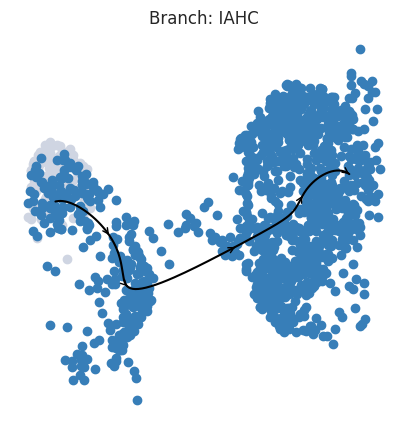

In [62]:
palantir.plot.plot_trajectory(ad, branch='IAHC')
plt.show()
# plt.savefig("Palantir_trajectory.png", dpi = 'figure')

[2024-08-08 16:10:02,370] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (1,274) and rank = 1.0.
[2024-08-08 16:10:02,370] [INFO    ] Using covariance function Matern52(ls=0.5231911571748288).
[2024-08-08 16:10:02,371] [INFO    ] Computing 50 landmarks with k-means clustering.


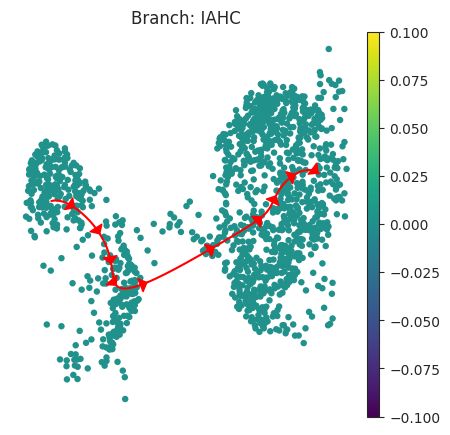

In [63]:
palantir.plot.plot_trajectory(
    ad,
    "IAHC",
    cell_color="palantir_entropy",
    n_arrows=10,
    color="red",
    scanpy_kwargs=dict(cmap="viridis"),
    arrowprops=dict(arrowstyle="-|>,head_length=.5,head_width=.5"),
)
plt.show()

Palantir generates the following results 
1. Pseudotime: Pseudo time ordering of each cell
2. Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
3. Entropy: A quantiative measure of the <i>differentiation potential</i> of each cell computed as the entropy of the multinomial terminal state probabilities

## Removing Mycn counts from normalized expression matrix

Mycn counts were removed as it was proven that the dataset expressed truncated mRNA molecules of the gene, due to deletion ocurring only in exon3, the terminal exon. Truncated reads would be expressing only exons1 and 2 of Mycn

In [68]:
count_matrix = ad[:,:].to_df()

row_names = [str(i) for i in range(count_matrix.shape[0])]


cell_id_nmyc = ad.obs["Condition"][ad.obs["Condition"] == "Nmyc LOF"].index

cell_id = ad.obs.index

count_matrix.loc[cell_id_nmyc, 'Mycn'] = 0

# Confirm that al reads are 0

print("Mycn reads in MycnLOF:",count_matrix.loc[cell_id_nmyc, "Mycn"].sum())


Mycn reads in MycnLOF: 0.0


In [69]:
# Traspass dataframe onto counts matrix

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Convert DataFrame to CSR sparse matrix of type numpy.float64
sparse_matrix = csr_matrix(count_matrix.values, dtype=np.float64)

ad.X = sparse_matrix


In [70]:
# In case there is an error in the anndata object, the following code can be used to fix it

ad.__dict__['_raw'].__dict__['_var'] = ad.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [ ]:
palantir_dir = "../../../anndata/"

ad.write_h5ad(palantir_dir + 'scAGM_v4_Palantir_upgrade.h5ad')

<a id="palantir2"></a><h2> Visualizing Palantir results </h2>

Palantir results can be visualized on the tSNE map using the `plot_palantir_results` function

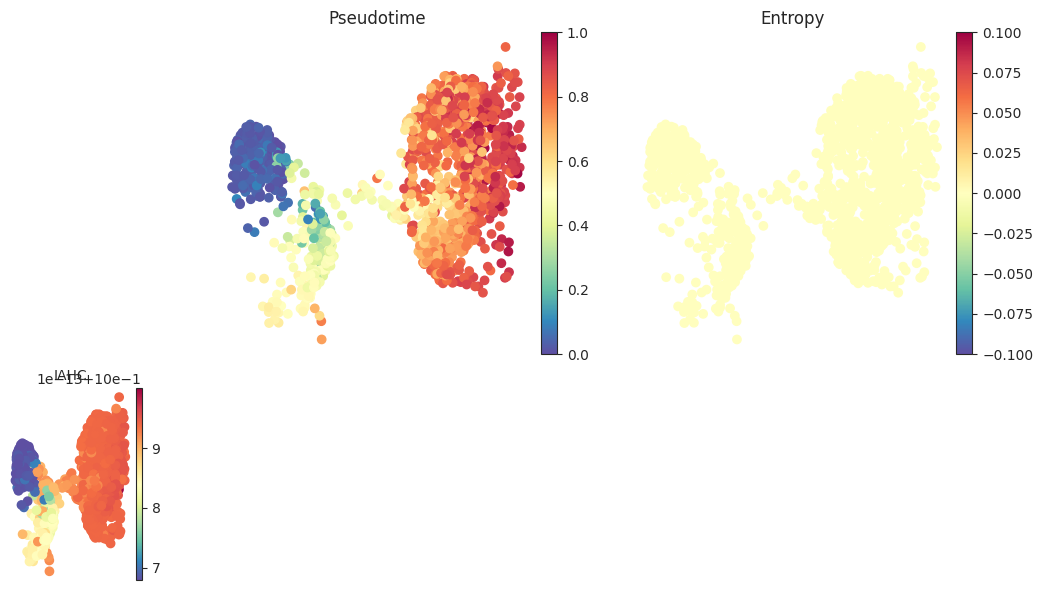

In [72]:
palantir.plot.plot_palantir_results(ad)
plt.show()

# plt.savefig("Palantir_results.png", dpi = 'figure')

Terminal state probability distributions of individual cells can be visualized using the `plot_terminal_state_probs` function

The cells can be highlighted on the tSNE map using the `highlight_cells_on_tsne` function

(<Figure size 400x400 with 1 Axes>, <Axes: >)

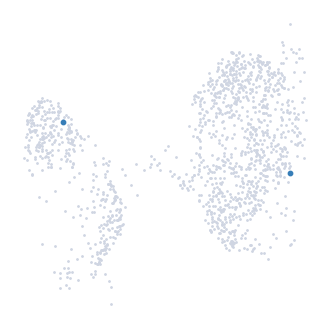

In [73]:
cells = [start_cell, terminal_cell]

palantir.plot.highlight_cells_on_umap(ad, cells)

# plt.savefig("Cell_Selection_Trayectory.png", dpi = 'figure')


<h3>Pseudotime bins plot per cell type</h3>
Add proportional plot for pseudotime in terms of pseudotime bins and cell proportion in each bin

In [161]:
ad.obs

table_pseudotime = ad.obs[["palantir_pseudotime", "Celltype"]].copy()

table_pseudotime.head()

palantir_pseudotime   Celltype
AAAGGATTCCGTGGTG-1_2             0.644516     Pre-HE
AAAGTCCTCCGTGTAA-1_2             0.795224       IAHC
AACCAACGTCACTTAG-1_2             0.933203       IAHC
AAGGAATTCCATACAG-1_2             0.019844  Aorta ECs
AATAGAGAGCGATGGT-1_2             0.869246       IAHC

In [75]:
#  Get values into workable bins
table_pseudotime['bin'] = pd.cut(table_pseudotime['palantir_pseudotime'], bins=np.linspace(0, 1, num=27), include_lowest=True, labels=False)
# table_pseudotime.to_csv("table_pseudotime.csv", index = False)

In [78]:
bin_counts = table_pseudotime.groupby(['bin', 'Celltype']).size().unstack(fill_value=0)


/tmp/ipykernel_34193/3103670665.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', 'Celltype']).size().unstack(fill_value=0)


Looking at the cell type proportion across the pseudotime 

/tmp/ipykernel_34193/2344548246.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', 'Celltype']).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

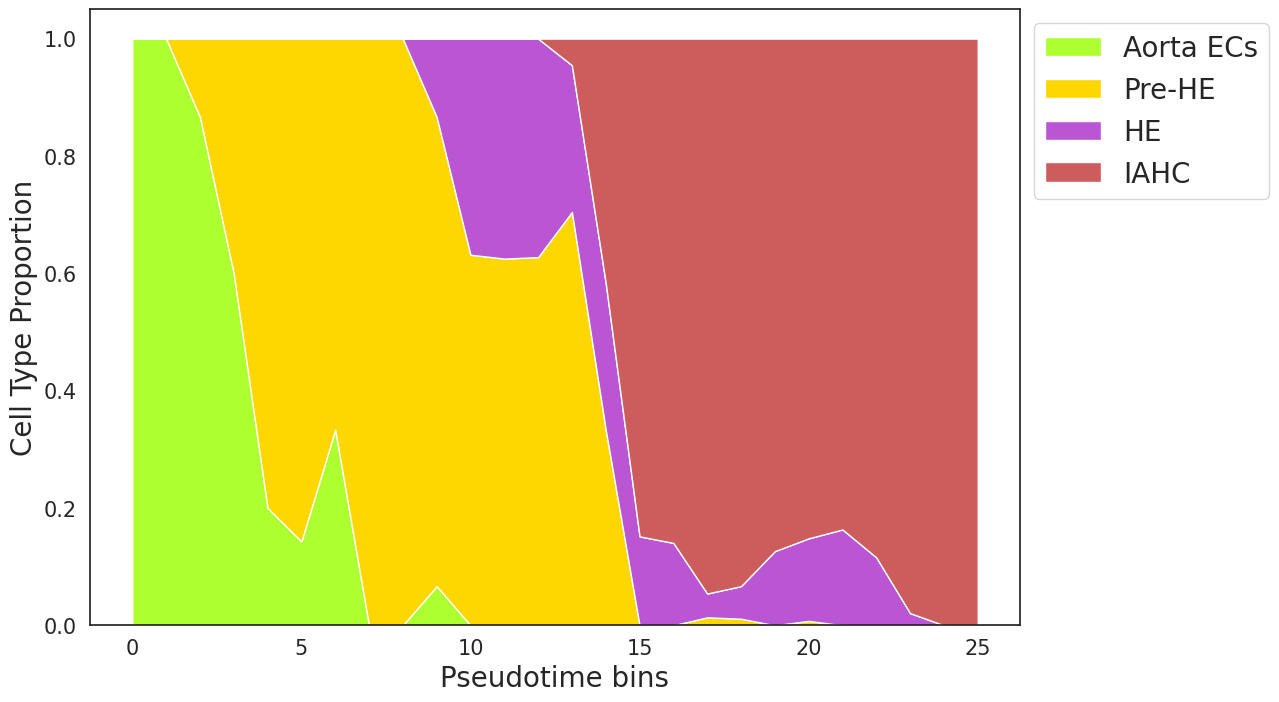

In [79]:
# Count the number of occurrences of each type in each bin
# bin_counts = table_pseudotime.groupby(['bin', 'FinalClustering']).size().unstack(fill_value=0)

bin_counts = table_pseudotime.groupby(['bin', 'Celltype']).size().unstack(fill_value=0)

# Normalize the counts to get the proportion for each bin
bin_proportions = bin_counts.div(bin_counts.sum(axis=1), axis=0)

# Plotting
sns.set(style="white")
plt.figure(figsize=(12, 8))

# Plot a stacked line plot for each bin using stackplot
bins = bin_proportions.index
types = bin_proportions.columns

fig, ax = plt.subplots(figsize=(12, 8))
# labels = ["Aorta Endothelium", "Pre-HE", "HE", "IAC"]
labels = [
    # "Arterial ECs", 
    "Aorta ECs", "Pre-HE", "HE", "IAHC"]
ax.stackplot(bins,
#  bin_proportions["Arterial ECs"],
  bin_proportions["Aorta ECs"], 
bin_proportions["Pre-HE"], bin_proportions["HE"], bin_proportions["IAHC"], labels=labels, colors= [
    # "#A2CD5A", 
    "#ADFF2F", "#FFD700", "#BA55D3", "#CD5C5C"])
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 20)
ax.set_xlabel('Pseudotime bins', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_ylabel('Cell Type Proportion', fontsize = 20)
ax.grid(False)
plt.show()

# fig, ax = plt.subplots()
# ax.stackplot(x, y)
plt.show()

# fig.savefig("All_cells/Cell_pseudotime_proportions.pdf", format="pdf", bbox_inches="tight")

# fig.savefig("All_cells/Cell_pseudotime_proportions.jpeg", format="jpeg", bbox_inches="tight")


<a id='trends'></a><h2> Gene expression trends </h2>

Palantir uses <a href="https://cran.r-project.org/web/packages/gam/">Generalized Additive Models (GAMs) </a> to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the `lineages` parameter.


In [81]:
gene_trends = palantir.presults.compute_gene_trends(
    ad,
    # expression_key="MAGIC_imputed_data",
)


IAHC
[2024-08-08 16:15:39,528] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,274) and rank = 1.0.
[2024-08-08 16:15:39,528] [INFO    ] Using covariance function Matern52(ls=1.0).


In [82]:
genes = ['Cdh5', 'Notch1', 'Notch3', 'Notch4', 'Dll4', 'Dll1', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 'Gata2', 'Efnb2', 'Gfi1', 'Procr', 'Kit', 'Runx1', 'Mycn', 'Myc','Gja5', 'Sox17', 'Ikzf2', 'Rac2', 'Myb', 'Mpo']

raw_df = ad[:, genes].to_df()


The determined trends can be visualized with the `plot_gene_trends_group_genes` function. Genes are grouped onto the same panel

<Figure size 700x300 with 0 Axes>

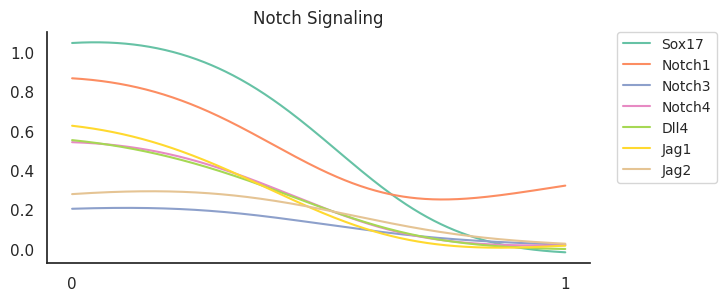

<Figure size 700x300 with 0 Axes>

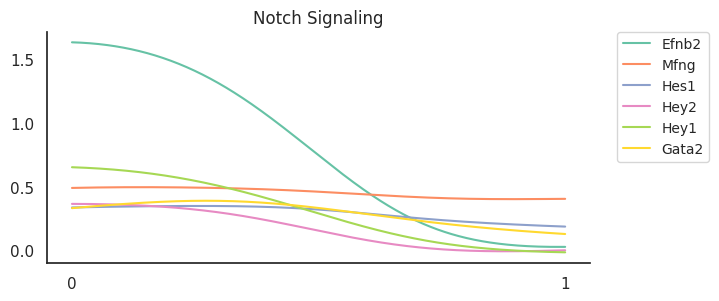

<Figure size 700x300 with 0 Axes>

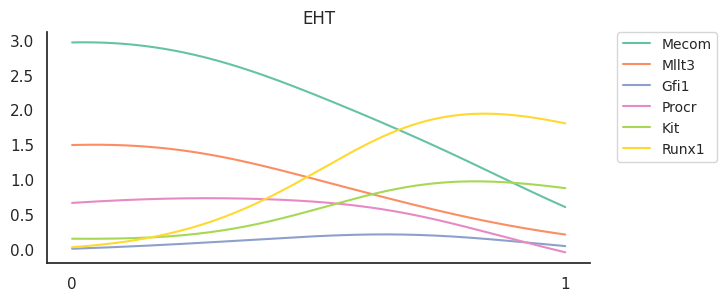

<Figure size 700x300 with 0 Axes>

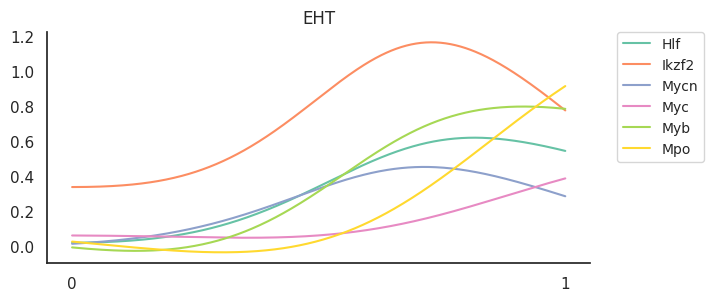

In [83]:
plot_gene_trends_group_genes(gene_trends, genes =  ['Sox17','Notch1', 'Notch3', 'Notch4', 'Dll4', 'Jag1', 'Jag2'], main= "Notch Signaling")

# plt.savefig("All_cells/gene_trends_group_Notch.png", dpi = 'figure', bbox_inches='tight')
# plt.savefig("All_cells/gene_trends_group_Notch.pdf", format = 'pdf', bbox_inches='tight')

plot_gene_trends_group_genes(gene_trends, genes = ['Efnb2','Mfng', 'Hes1', 'Hey2', 'Hey1', 'Gata2'], main= "Notch Signaling")

# plt.savefig("All_cells/gene_trends_group_Notch_downstream.png", dpi = 'figure', bbox_inches='tight')
# plt.savefig("All_cells/gene_trends_group_Notch_downstream.pdf", format = 'pdf', bbox_inches='tight')

plot_gene_trends_group_genes(gene_trends, genes = ['Mecom', 'Mllt3','Gfi1', 'Procr', 'Kit', 'Runx1'], main= "EHT")

# plt.savefig("All_cells/gene_trends_group_EHT.png", dpi = 'figure', bbox_inches='tight')
# plt.savefig("All_cells/gene_trends_group_EHT.pdf", format = 'pdf', bbox_inches='tight')

plot_gene_trends_group_genes(gene_trends, genes = ['Hlf','Ikzf2', 'Mycn', 'Myc', 'Myb','Mpo'], main= "EHT")

# plt.savefig("All_cells/gene_trends_group_EHT_downstream.png", dpi = 'figure', bbox_inches='tight')
# plt.savefig("All_cells/gene_trends_group_EHT_downstream.pdf", format = 'pdf', bbox_inches='tight')

Alternatively, the trends can be visualized on a clusterized heatmap using

In [85]:
gene_trends_selected = gene_trends['IAHC']['trends'].loc[['Notch1', 'Notch3', 'Notch4', 'Dll4', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 'Gata2', 'Gfi1', 'Procr', 'Kit', 'Runx1', 'Mycn', 'Myc']]

In [86]:
#  Create a new dictionary with the same structure
selected_gene_trends = {condition: {'trends': data['trends'].loc[['Notch1', 'Notch3', 'Notch4', 'Dll4', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 'Gata2','Efnb2', 'Gfi1', 'Procr', 'Myb', 'Hlf', 'Ikzf2', 'Kit', 'Runx1', 'Mycn', 'Myc', 'Sox17','Mpo', 'Mecom', 'Mllt3']]} for condition, data in gene_trends.items()}

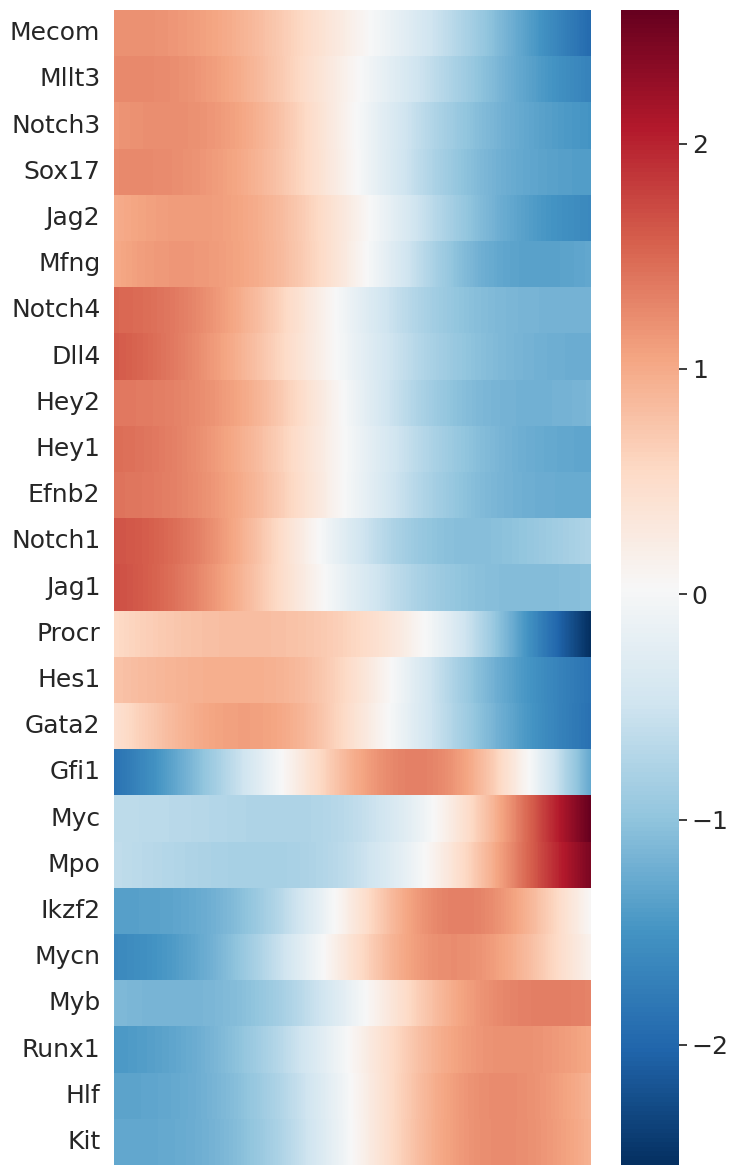

In [87]:

plot_gene_trend_heatmaps_v2(selected_gene_trends, cmap="RdBu_r")
# plt.savefig("All_cells/gene_trends_heatmap.png", dpi = 'figure')
# plt.savefig("All_cells/gene_trends_heatmap.pdf", format = 'pdf')

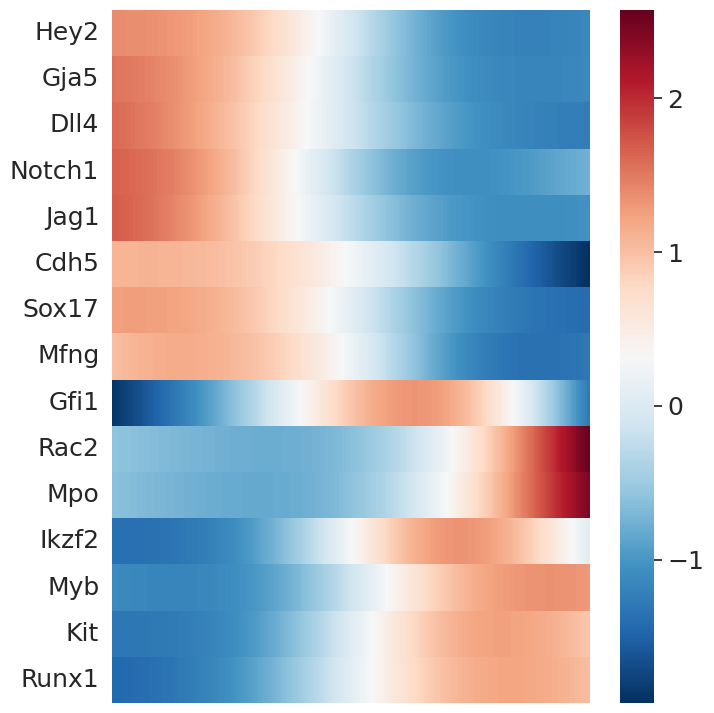

In [88]:
genes_Carlos = ['Cdh5', 'Gja5', 'Sox17', 'Gfi1', 'Ikzf2', 'Kit', 'Runx1', 'Rac2', 'Myb', 'Mpo', 'Notch1', 'Dll4', 'Jag1', 'Hey2', 'Mfng']

#  Create a new dictionary with the same structure
selected_gene_trends = {condition: {'trends': data['trends'].loc[genes_Carlos]} for condition, data in gene_trends.items()}

plot_gene_trend_heatmaps_v2(selected_gene_trends, cmap="RdBu_r")
# plt.savefig("All_cells/gene_trends_heatmap_Carlos.png", dpi = 'figure')

<h3>Save anndata object and pr_res</h3>

In [200]:
# In case there is an error in the anndata object, the following code can be used to fix it

ad.__dict__['_raw'].__dict__['_var'] = ad.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [ ]:

palantir_dir = "../../../anndata/"

ad.write_h5ad(palantir_dir + 'scAGM_v4_Palantir_Final_upgrade.h5ad')


In [91]:
palantir_dir = "../../../anndata/"

ad_all = ad


In [92]:
ad_all.obsm

AxisArrays with keys: X_pca, X_umap, DM_EigenVectors, dm_res, DM_EigenVectors_multiscaled, palantir_fate_probabilities, branch_masks

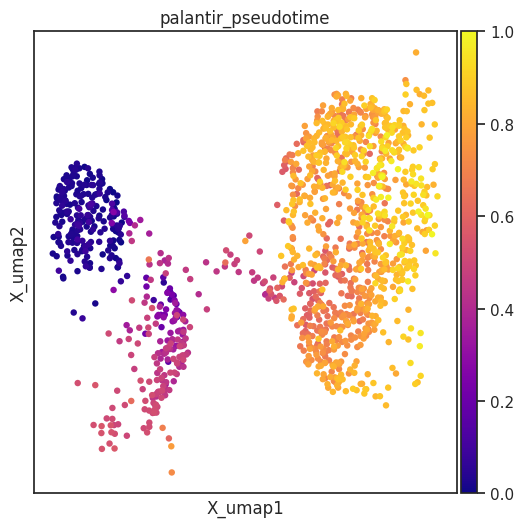

In [94]:
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=ad_all, 
                basis="X_umap",
                ax=ax, cmap="plasma",
                color=["palantir_pseudotime"], 
                # save="Pseudotime_Palantir_scAGM_EHT.png"
                )

In [95]:
# Load sample data

# My dataset
palantir_dir = "../../../anndata/"
ad_all = sc.read(palantir_dir + 'scAGM_v4_Palantir_Final_Bmx_from_Aorta_ECs_upgrade.h5ad')

ad_all

AnnData object with n_obs × n_vars = 1387 × 18310
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'seurat_clusters', 'hash.ID', 'Condition', 'predicted.id', 'ZhuClustering', 'FinalClustering', 'Condition_Clustering', 'Driver', 'FinalClustering_old', 'Notch_Pathway_1', 'EHT_2', 'HSC_Scorecard_3', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALING', 'HAL

In [97]:
ad = ad_all

In [96]:
gene_trends = palantir.presults.compute_gene_trends(
    ad,
    # expression_key="MAGIC_imputed_data",
)

IAHC
[2024-08-08 16:21:06,103] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,274) and rank = 1.0.
[2024-08-08 16:21:06,103] [INFO    ] Using covariance function Matern52(ls=1.0).


# Computing gene trends per condition

In [99]:
Cell_ID_per_condition = [[] for i,val in enumerate(np.unique(ad_all.obs["Condition"]))]

Cell_ID_per_condition

[[], [], [], [], [], [], []]

In [162]:
# Select cells in terms of CellID per condition

Cell_ID_per_condition = {val: [] for i,val in enumerate(np.unique(ad_all.obs["Condition"]))}

for i,val in enumerate(np.unique(ad_all.obs["Condition"])):

    Cell_ID_per_condition[val]  = ad_all.obs_names[ad_all.obs["Condition"] == val]


In [101]:
# subset the anndata object per conditions and PResults file as well

Conditions = np.unique(ad_all.obs["Condition"])

ad = ad_all[ad_all.obs['Condition'].isin(['Control', 'Control VEQ']),:]

Conditions

array(['Control', 'Control VEQ', 'Jag1LOF', 'Mfng GOF', 'Nmyc LOF',
       'Notch1 GOF', 'Notch1LOF'], dtype=object)

In [163]:
genes = ['Gpr183', 'Cdh5', 'Notch1', 'Notch3', 'Notch4', 'Dll4', 'Dll1', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 'Gata2', 'Efnb2', 'Gfi1', 'Procr', 'Kit', 'Runx1', 'Mycn', 'Myc','Gja5', 'Sox17', 'Ikzf2', 'Rac2', 'Hlf', 'Myb', 'Mpo']

#  Create a new dictionary with the same structure
selected_gene_trends = {condition: {'trends': data['trends'].loc[genes]} for condition, data in gene_trends.items()}



<h3>Gene Trend Lines and Heatmaps</h3>

In [104]:
ad_all.obsm_keys


<bound method AnnData.obsm_keys of AnnData object with n_obs × n_vars = 1387 × 18310
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'seurat_clusters', 'hash.ID', 'Condition', 'predicted.id', 'ZhuClustering', 'FinalClustering', 'Condition_Clustering', 'Driver', 'FinalClustering_old', 'Notch_Pathway_1', 'EHT_2', 'HSC_Scorecard_3', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', '

# Gene trends for Control groups

The dataset contains two different Control groups. Here I merge them onto one condition and perform gene trends with the grouped number of cells

/tmp/ipykernel_34193/3744475282.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

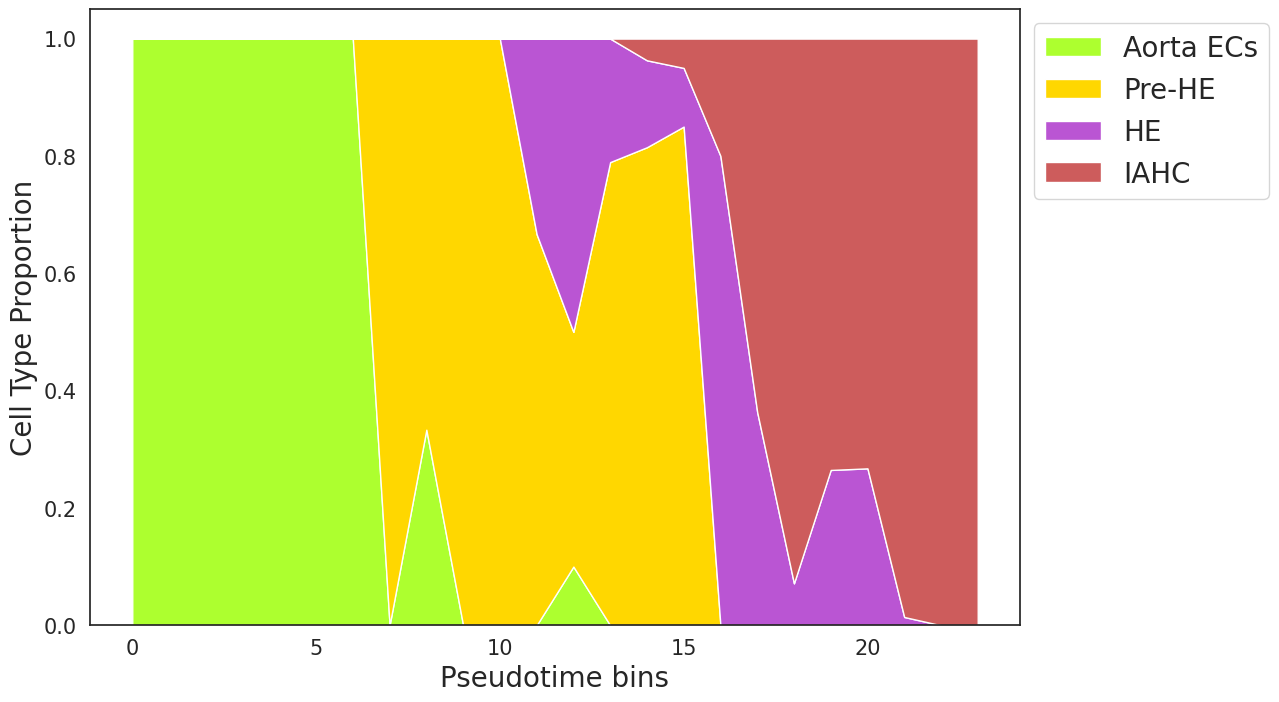

<Figure size 700x300 with 0 Axes>

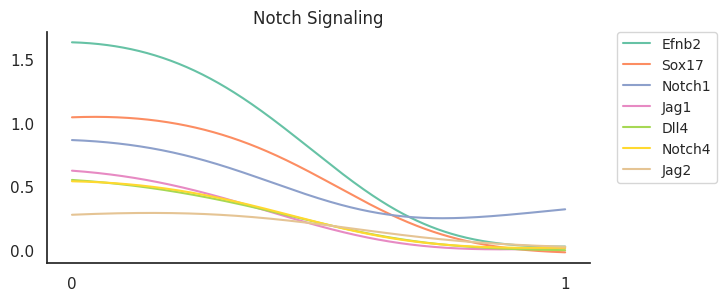

<Figure size 700x300 with 0 Axes>

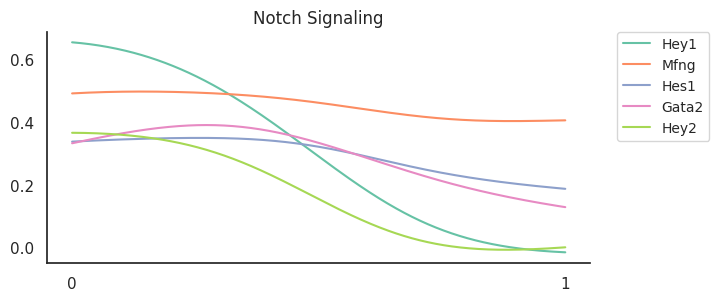

<Figure size 700x300 with 0 Axes>

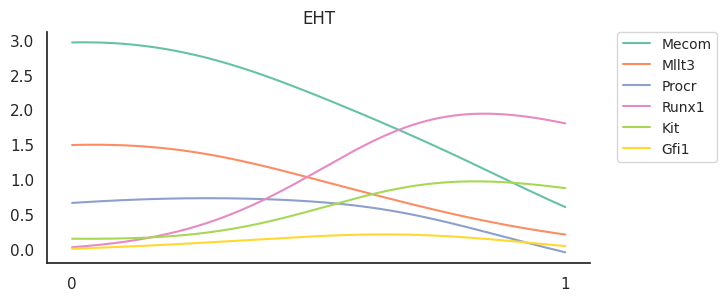

<Figure size 700x300 with 0 Axes>

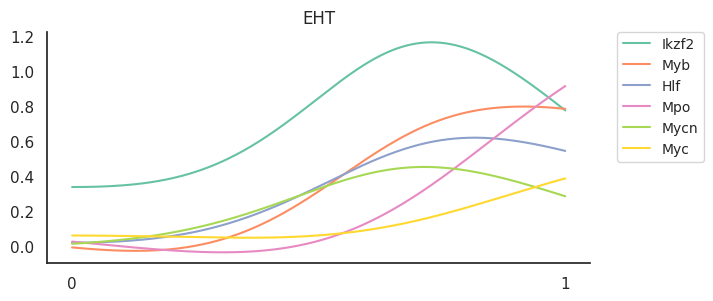

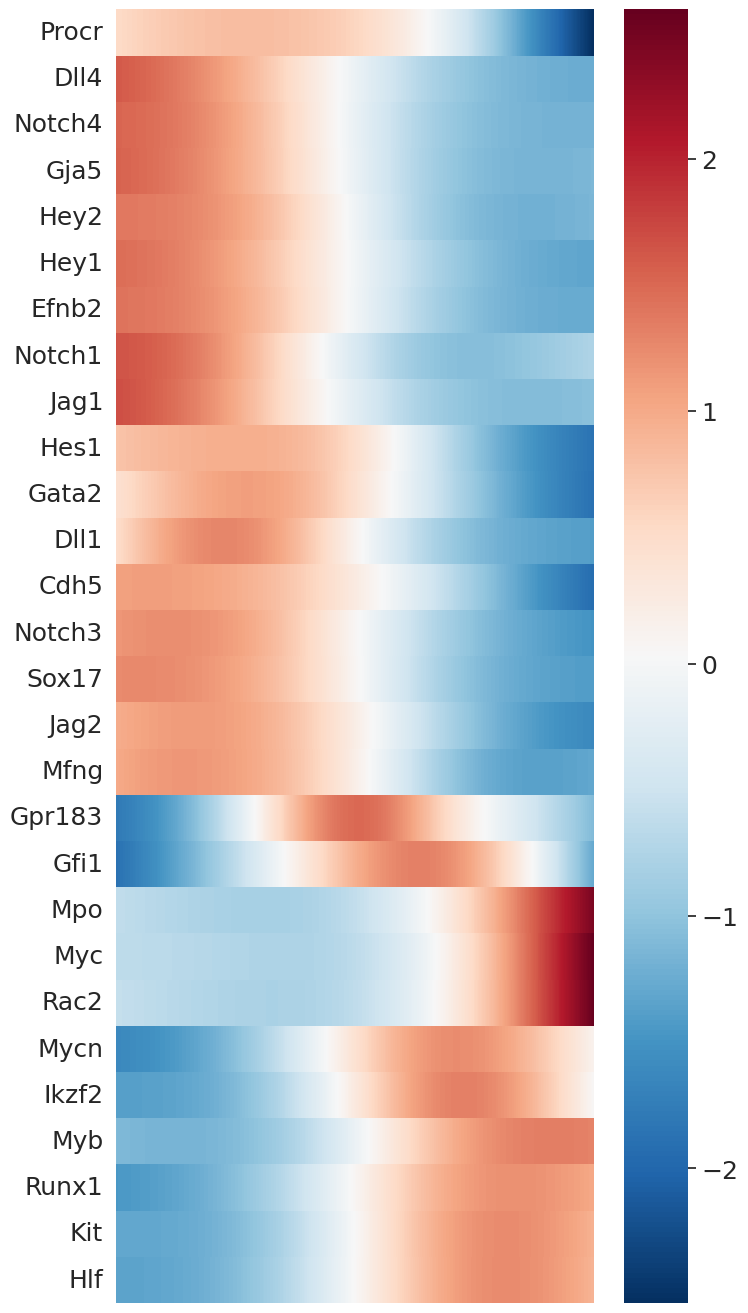

In [105]:
os.makedirs("Controls", exist_ok=True)

cond_dir = "Controls"

pseudotime_cell_bins(ad, celltype = "Celltype", order =
                     [0,3,1,2],
                    # [1, 0, 4, 2, 3],
                     colors = [
    # "#A2CD5A", 
    "#ADFF2F", "#FFD700", "#BA55D3", "#CD5C5C"])

# plt.savefig(''.join([cond_dir, "/", cond_dir,"_pseudotime_bins.png"]), dpi = 'figure', bbox_inches='tight')
# plt.savefig(''.join([cond_dir, "/", cond_dir,"_pseudotime_bins.pdf"]), format = 'pdf', bbox_inches='tight')

plot_gene_trends_group_genes(gene_trends, genes = ['Efnb2','Sox17','Notch1','Jag1','Dll4','Notch4','Jag2'], main= "Notch Signaling")

# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_Notch.png"]), dpi = 'figure', bbox_inches='tight')
# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_Notch.pdf"]), format = 'pdf', bbox_inches='tight')

plot_gene_trends_group_genes(gene_trends, genes = ['Hey1','Mfng','Hes1','Gata2','Hey2'], main= "Notch Signaling")

# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_Notch_downstream.png"]), dpi = 'figure', bbox_inches='tight')
# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_Notch_downstream.pdf"]), format = 'pdf', bbox_inches='tight')

plot_gene_trends_group_genes(gene_trends, genes = ['Mecom', 'Mllt3','Procr','Runx1','Kit','Gfi1'], main= "EHT")

# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_EHT.png"]), dpi = 'figure', bbox_inches='tight')
# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_EHT.pdf"]), format = 'pdf', bbox_inches='tight')

plot_gene_trends_group_genes(gene_trends, genes = ['Ikzf2','Myb','Hlf','Mpo','Mycn','Myc'], main= "EHT")

# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_EHT_downstream.png"]), dpi = 'figure', bbox_inches='tight')
# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_EHT_downstream.pdf"]), format = 'pdf', bbox_inches='tight')

plot_gene_trend_heatmaps_v2(selected_gene_trends, cmap="RdBu_r", cluster_rows=True)

# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_heatmaps.png"]), dpi = 'figure', bbox_inches='tight')
# plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_heatmaps.pdf"]), format = 'pdf', bbox_inches='tight')

In [106]:
import matplotlib.pyplot as plt

# Get a list of all available colormaps
all_colormaps = plt.colormaps()

# Print the list of colormaps
print("Available Colormaps:")
print(all_colormaps)

Available Colormaps:
['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', '

<h2>Loop Per Conditions Plotting</h2>

This script generates automatically all relevant plots (pseudotime bins, gene trends and heatmaps) per conditions, stores them in specific folders

IAHC
[2024-08-08 16:25:53,273] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (211) and rank = 1.0.
[2024-08-08 16:25:53,274] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/tmp/ipykernel_34193/3744475282.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)


IAHC
[2024-08-08 16:25:54,475] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (274) and rank = 1.0.
[2024-08-08 16:25:54,476] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/tmp/ipykernel_34193/3744475282.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)
/tmp/ipykernel_34193/2931857399.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[7, 3])


IAHC
[2024-08-08 16:25:55,686] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (147) and rank = 1.0.
[2024-08-08 16:25:55,686] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/tmp/ipykernel_34193/3744475282.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)


IAHC
[2024-08-08 16:25:56,857] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (172) and rank = 1.0.
[2024-08-08 16:25:56,858] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/tmp/ipykernel_34193/3744475282.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)


IAHC
[2024-08-08 16:25:58,006] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (95) and rank = 1.0.
[2024-08-08 16:25:58,006] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/tmp/ipykernel_34193/3744475282.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)


IAHC
[2024-08-08 16:25:59,204] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (249) and rank = 1.0.
[2024-08-08 16:25:59,205] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/tmp/ipykernel_34193/3744475282.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)


IAHC
[2024-08-08 16:26:00,670] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (142) and rank = 1.0.
[2024-08-08 16:26:00,671] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/tmp/ipykernel_34193/3744475282.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = table_pseudotime.groupby(['bin', celltype]).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

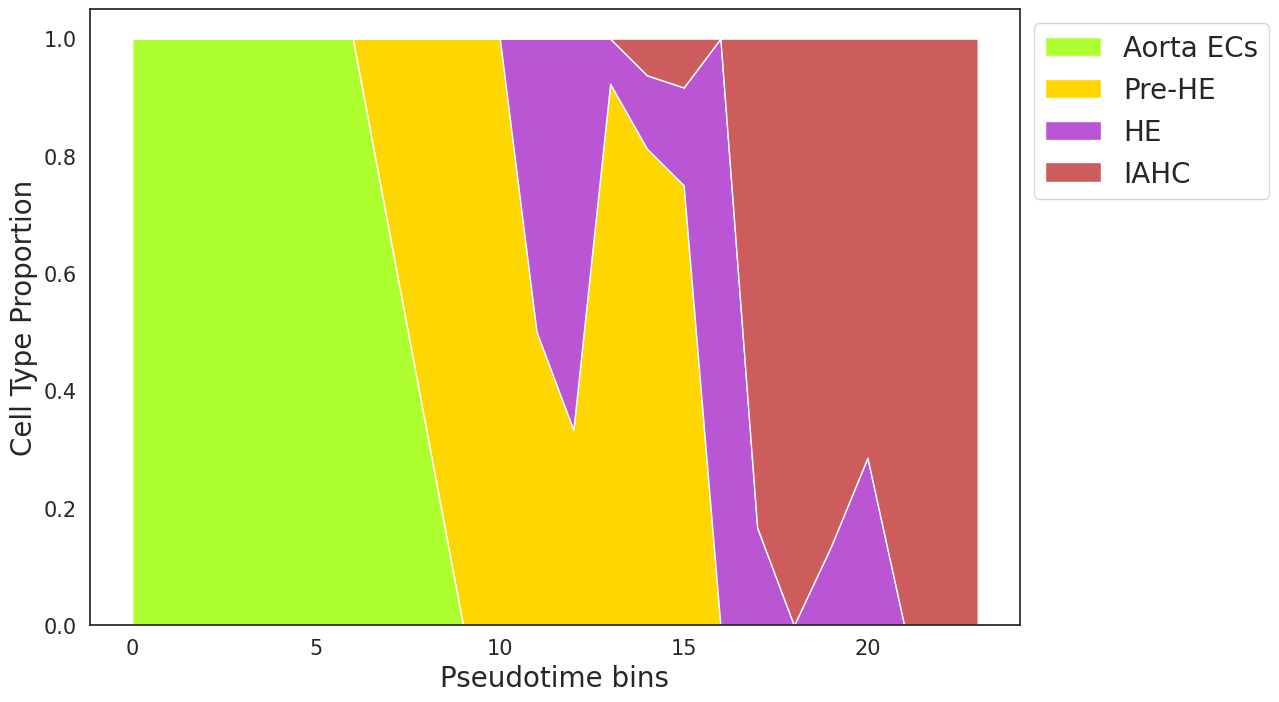

<Figure size 700x300 with 0 Axes>

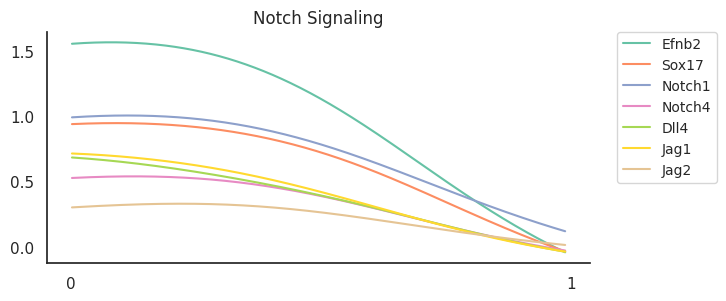

<Figure size 700x300 with 0 Axes>

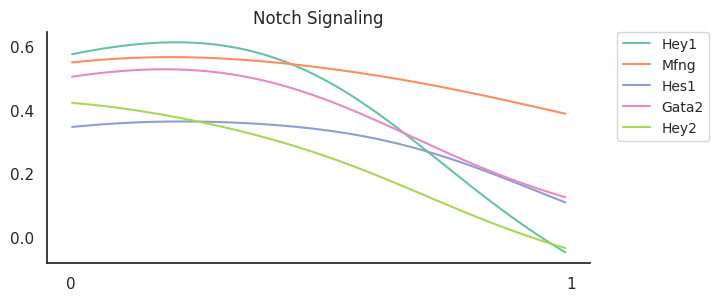

<Figure size 700x300 with 0 Axes>

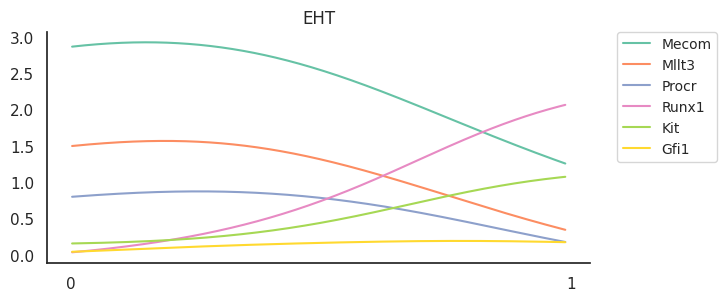

<Figure size 700x300 with 0 Axes>

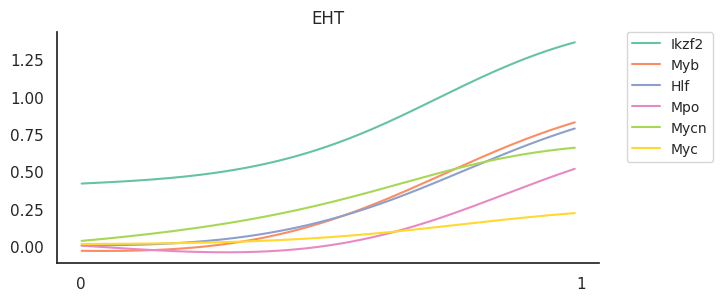

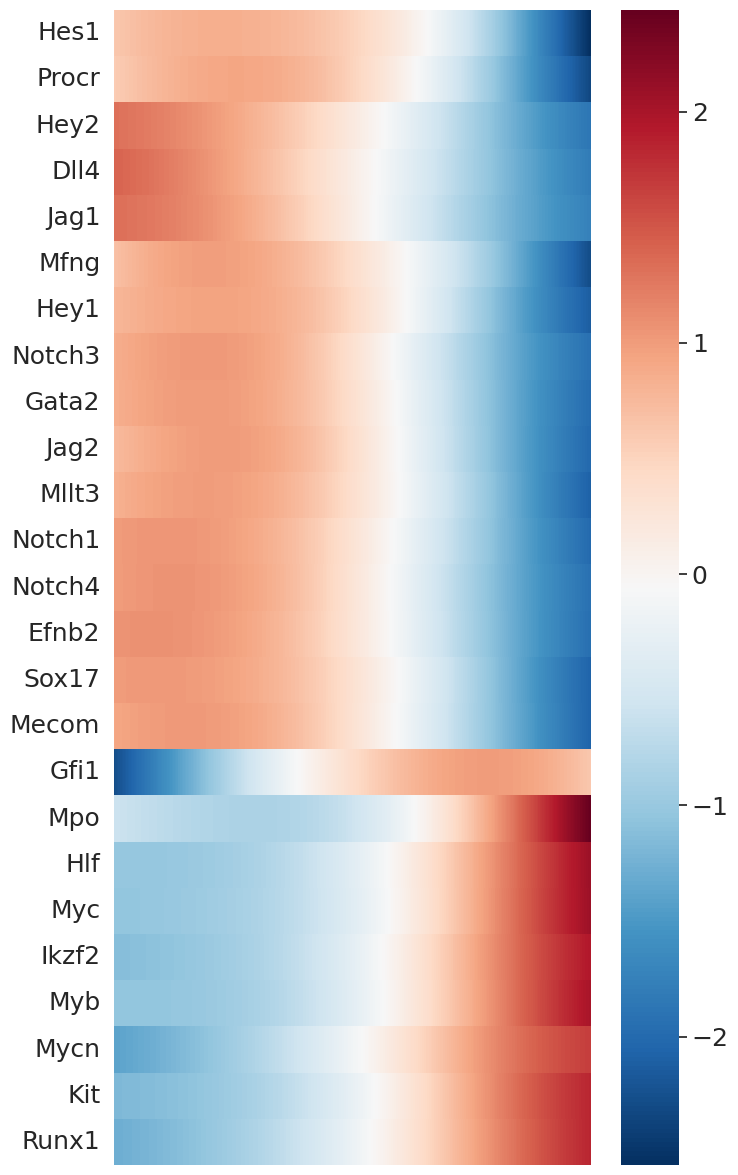

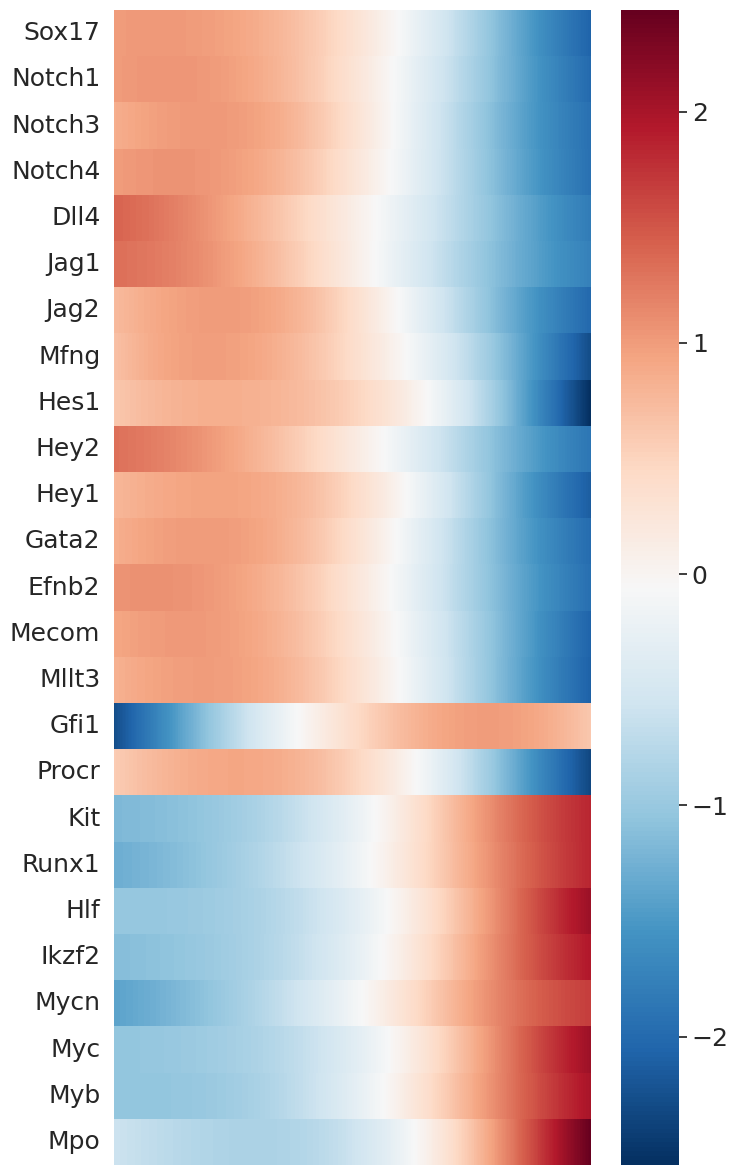

<Figure size 1200x800 with 0 Axes>

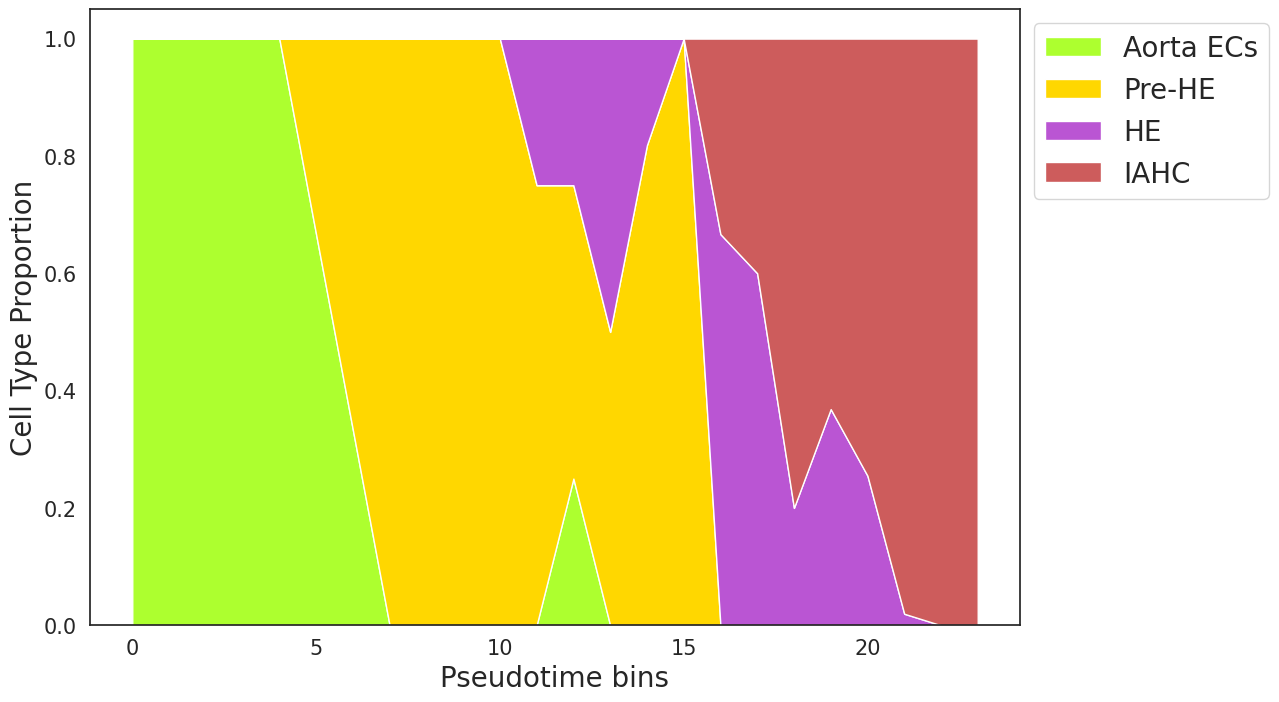

<Figure size 700x300 with 0 Axes>

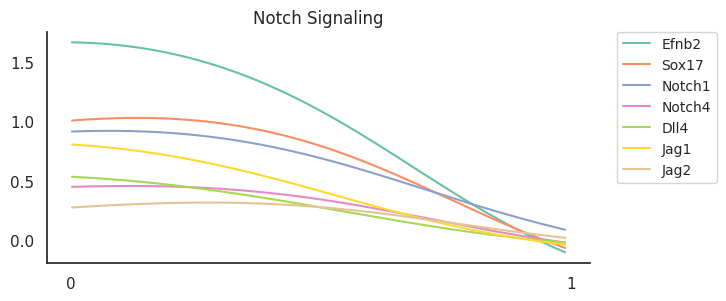

<Figure size 700x300 with 0 Axes>

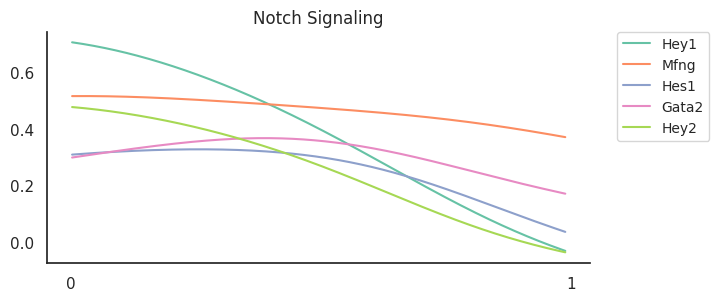

<Figure size 700x300 with 0 Axes>

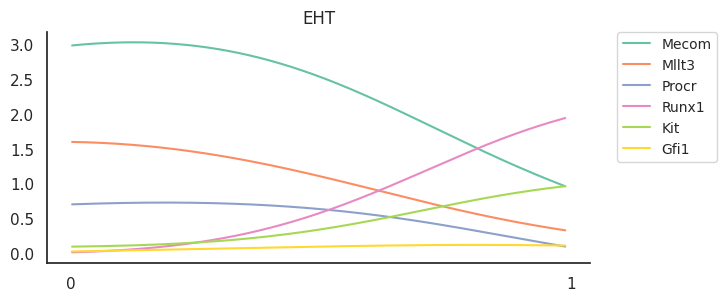

<Figure size 700x300 with 0 Axes>

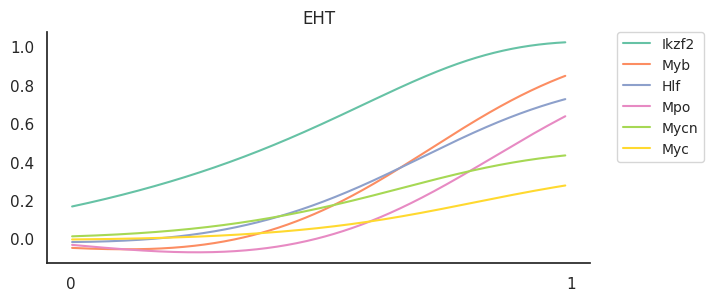

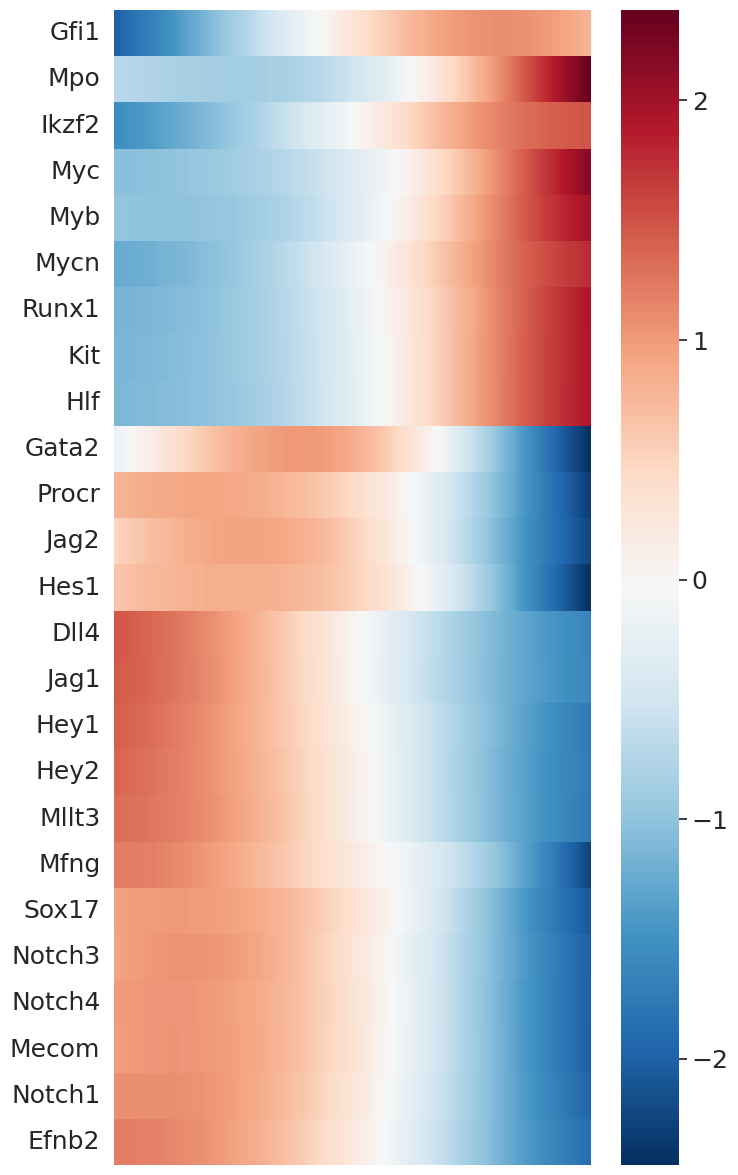

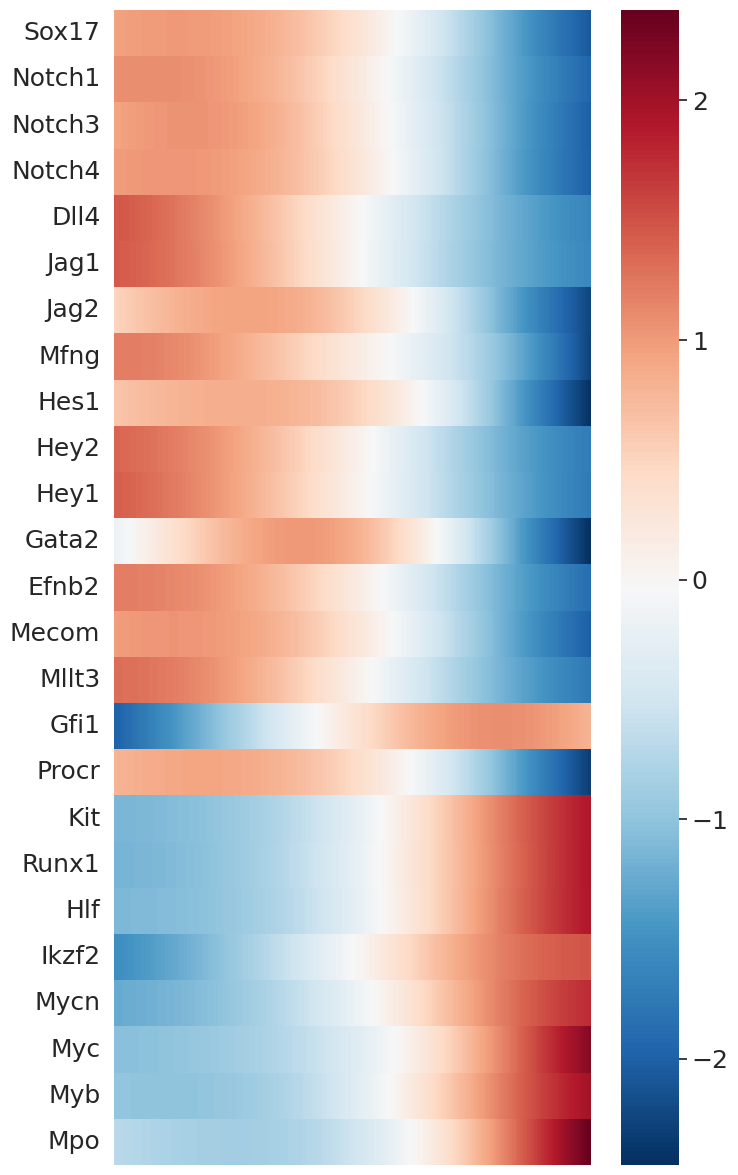

<Figure size 1200x800 with 0 Axes>

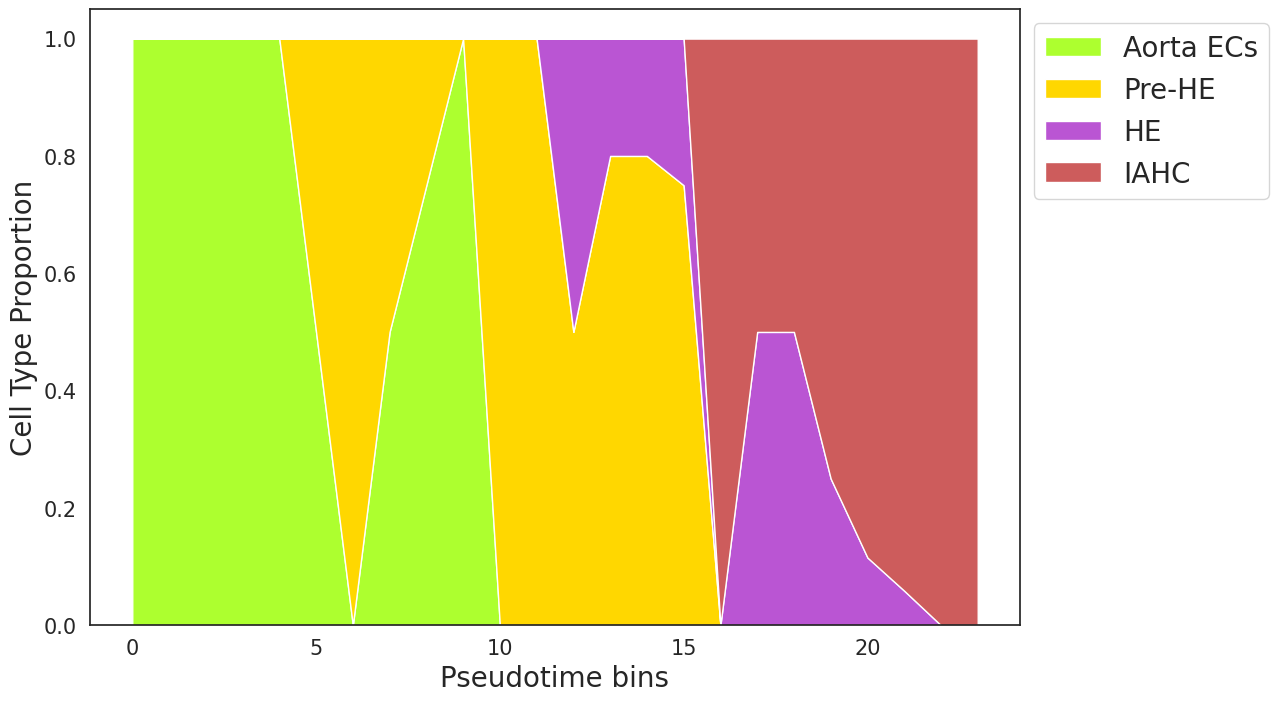

<Figure size 700x300 with 0 Axes>

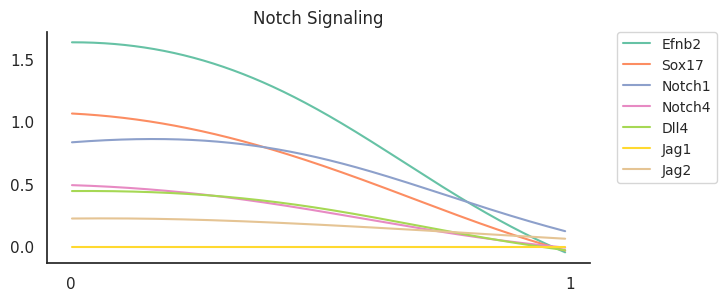

<Figure size 700x300 with 0 Axes>

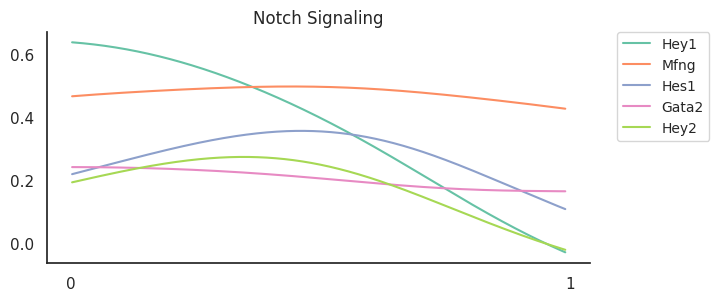

<Figure size 700x300 with 0 Axes>

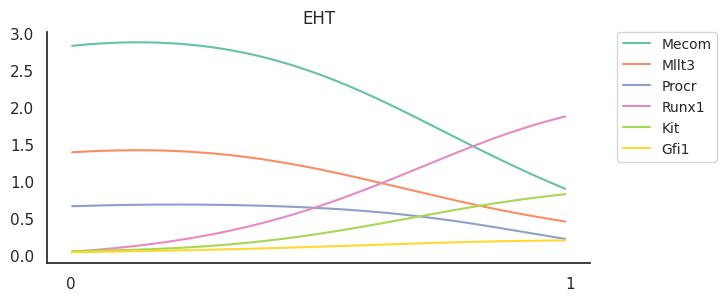

<Figure size 700x300 with 0 Axes>

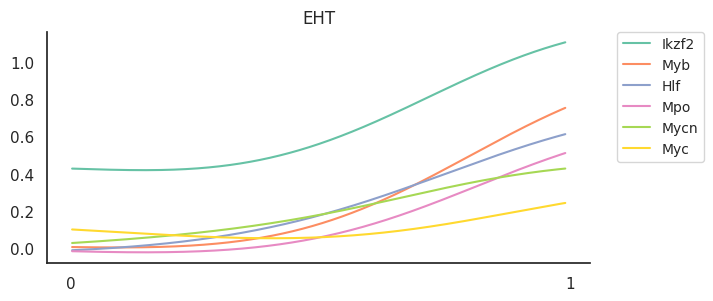

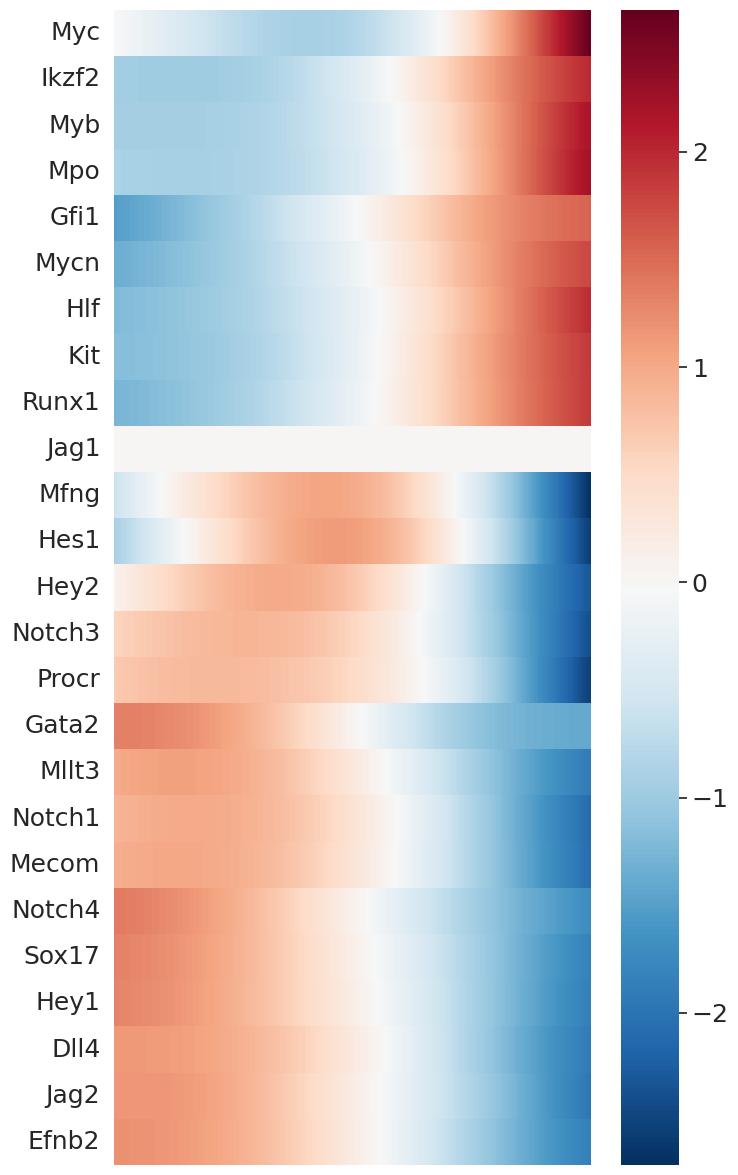

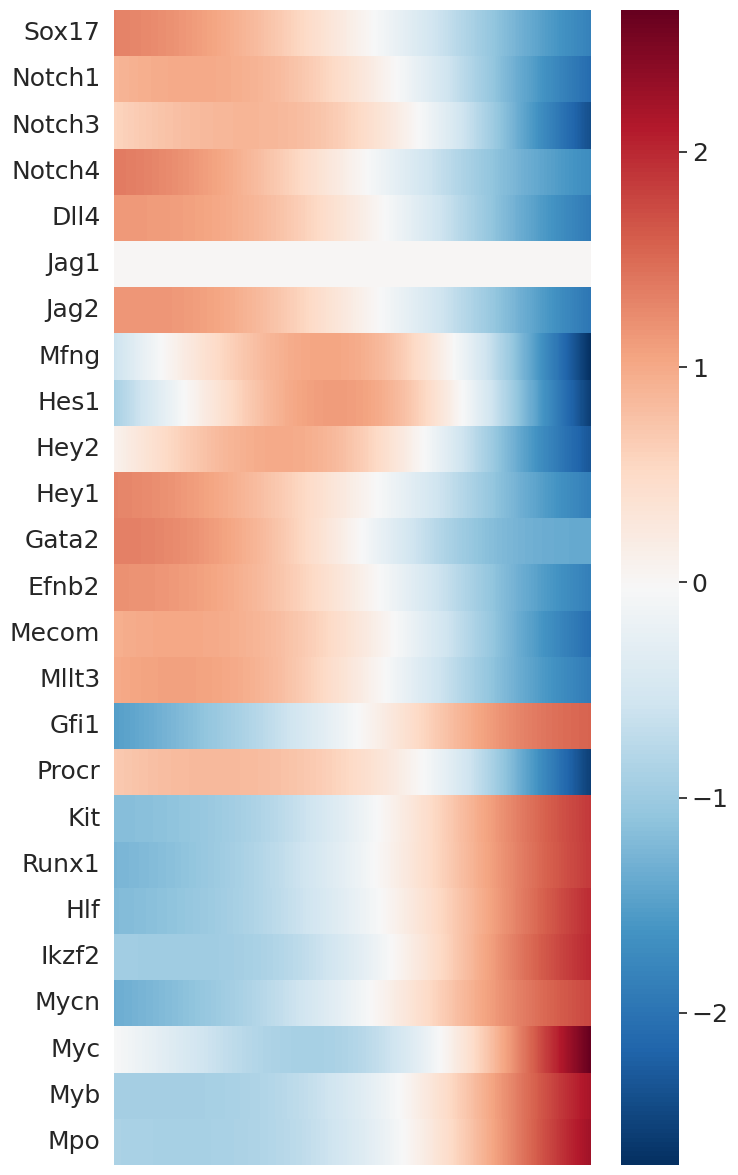

<Figure size 1200x800 with 0 Axes>

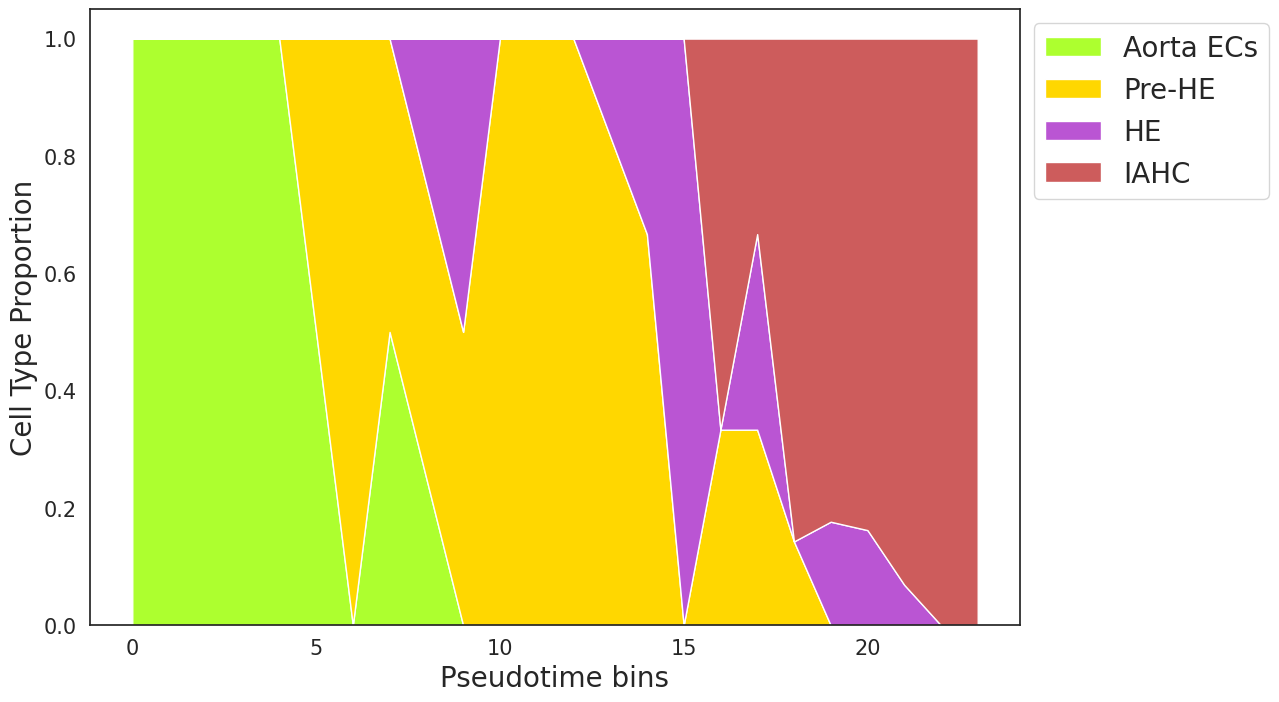

<Figure size 700x300 with 0 Axes>

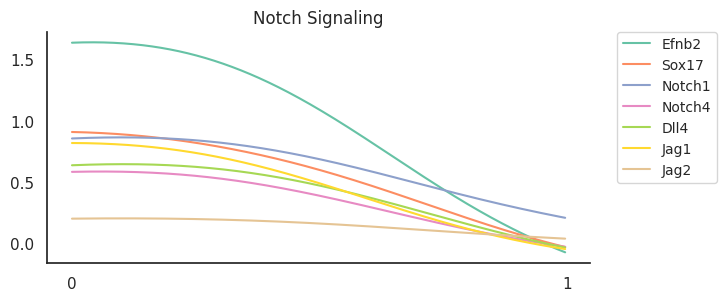

<Figure size 700x300 with 0 Axes>

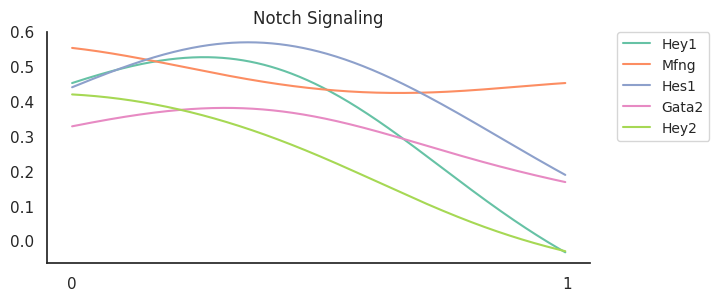

<Figure size 700x300 with 0 Axes>

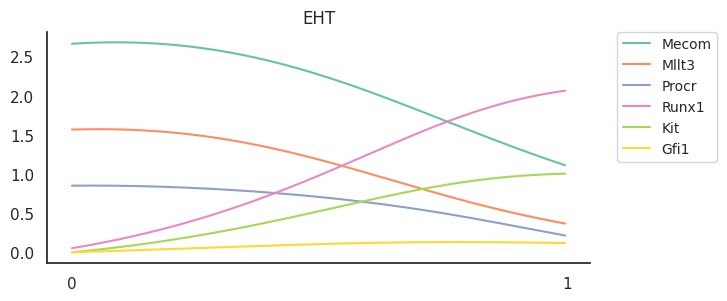

<Figure size 700x300 with 0 Axes>

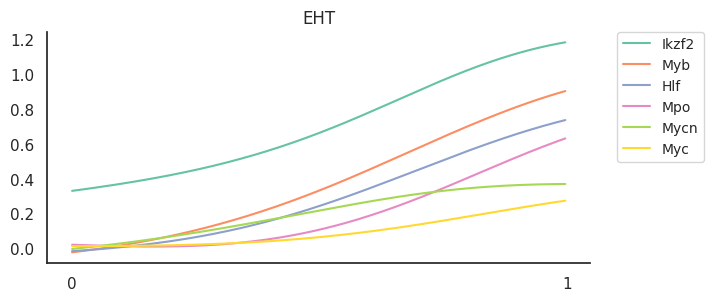

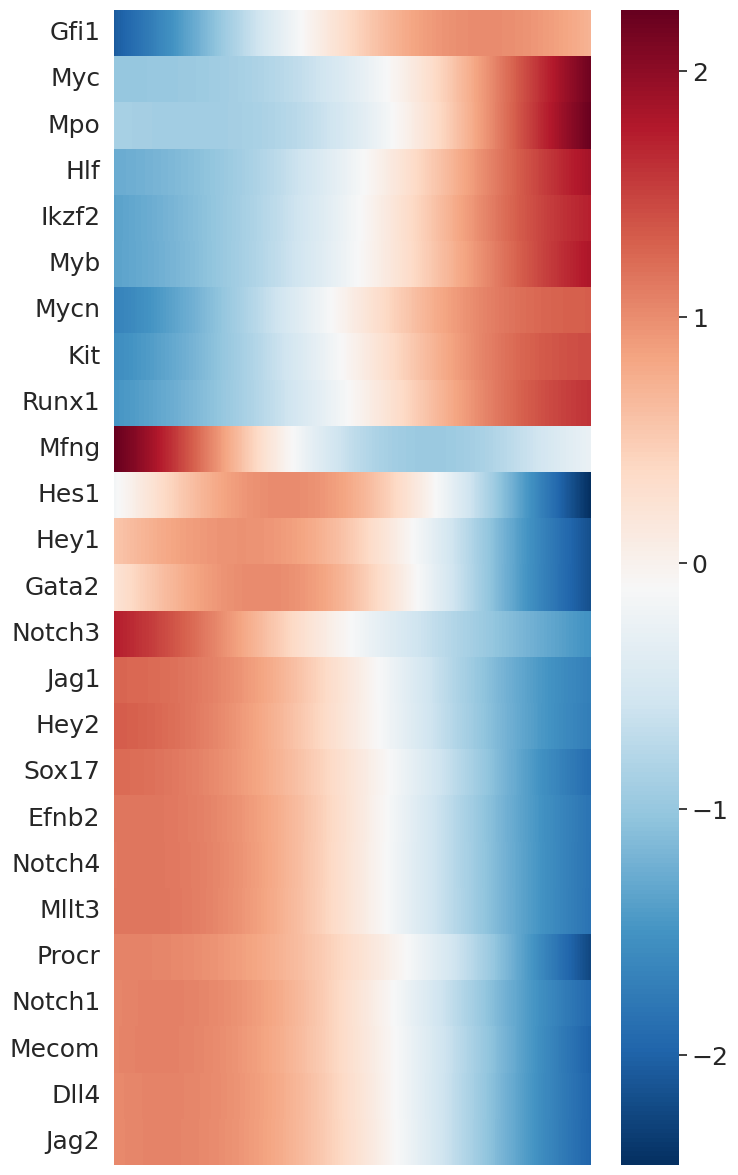

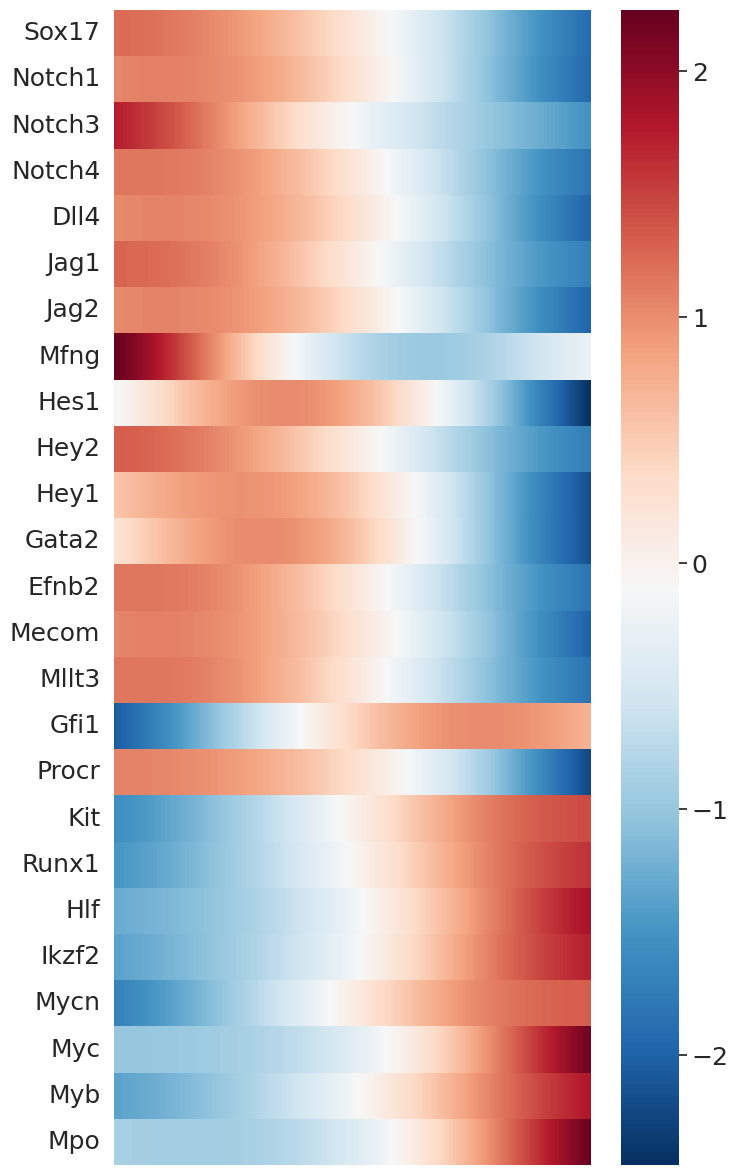

<Figure size 1200x800 with 0 Axes>

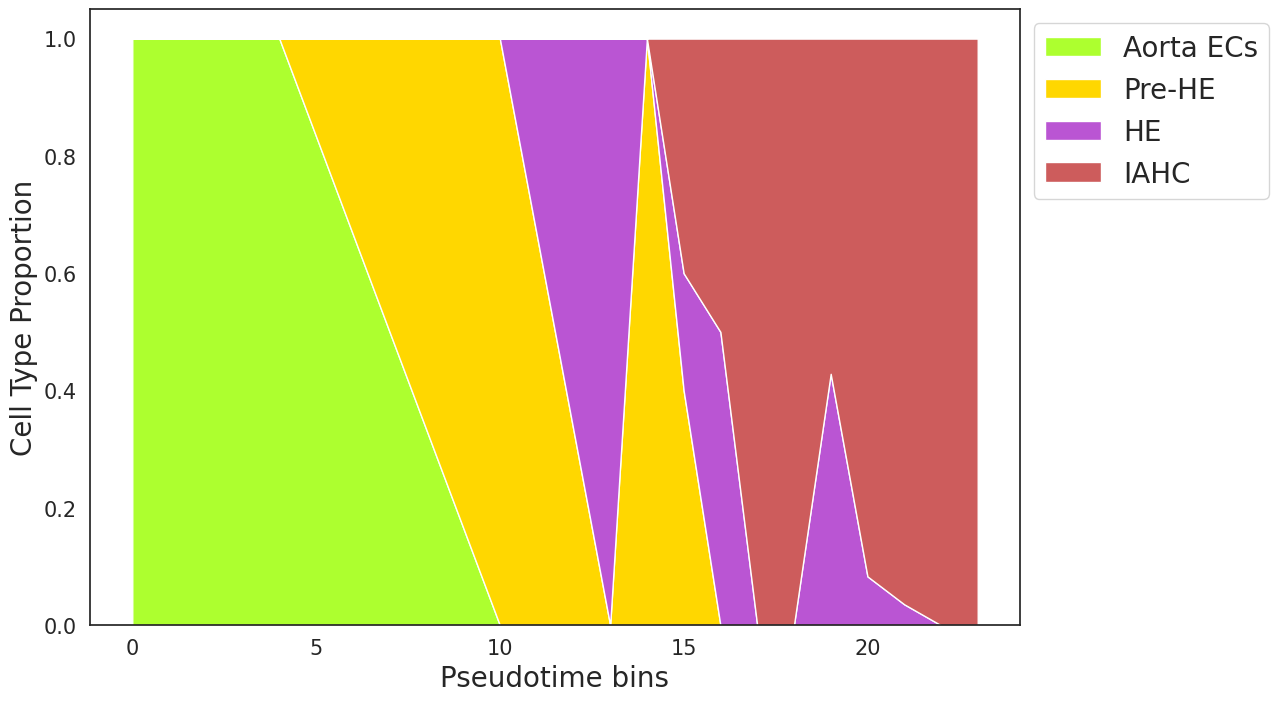

<Figure size 700x300 with 0 Axes>

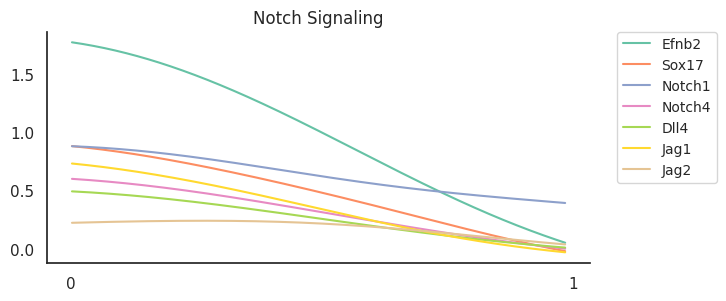

<Figure size 700x300 with 0 Axes>

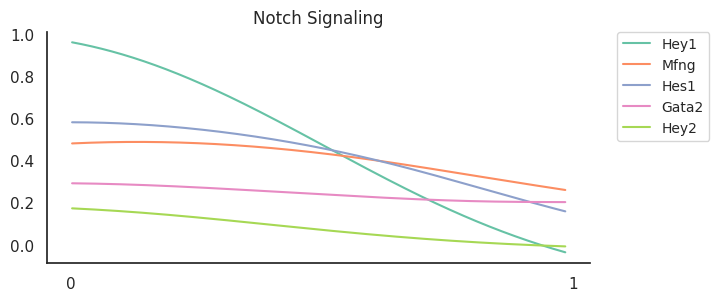

<Figure size 700x300 with 0 Axes>

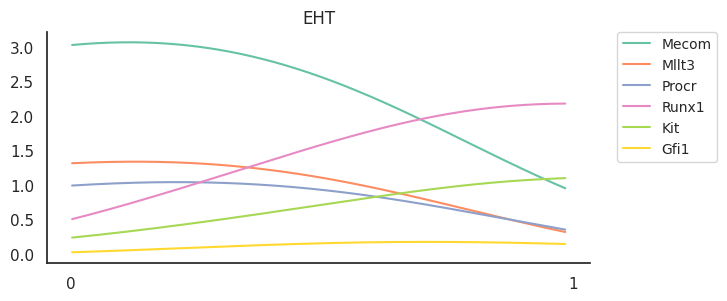

<Figure size 700x300 with 0 Axes>

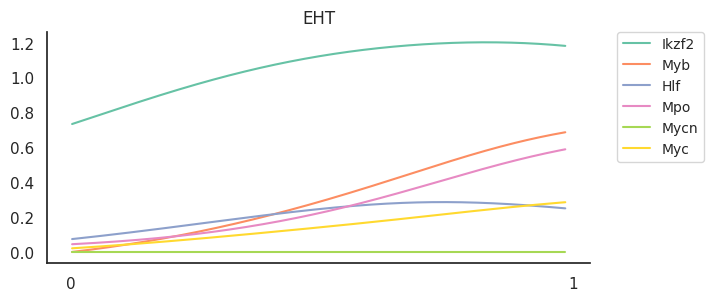

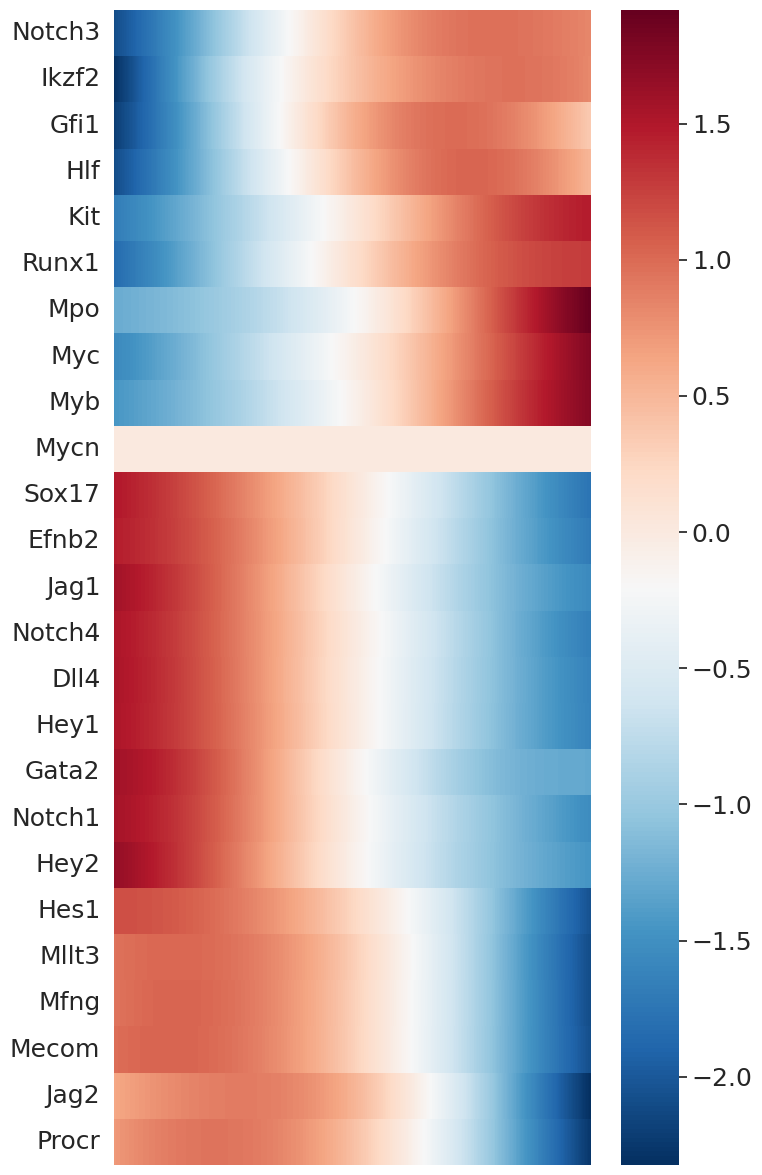

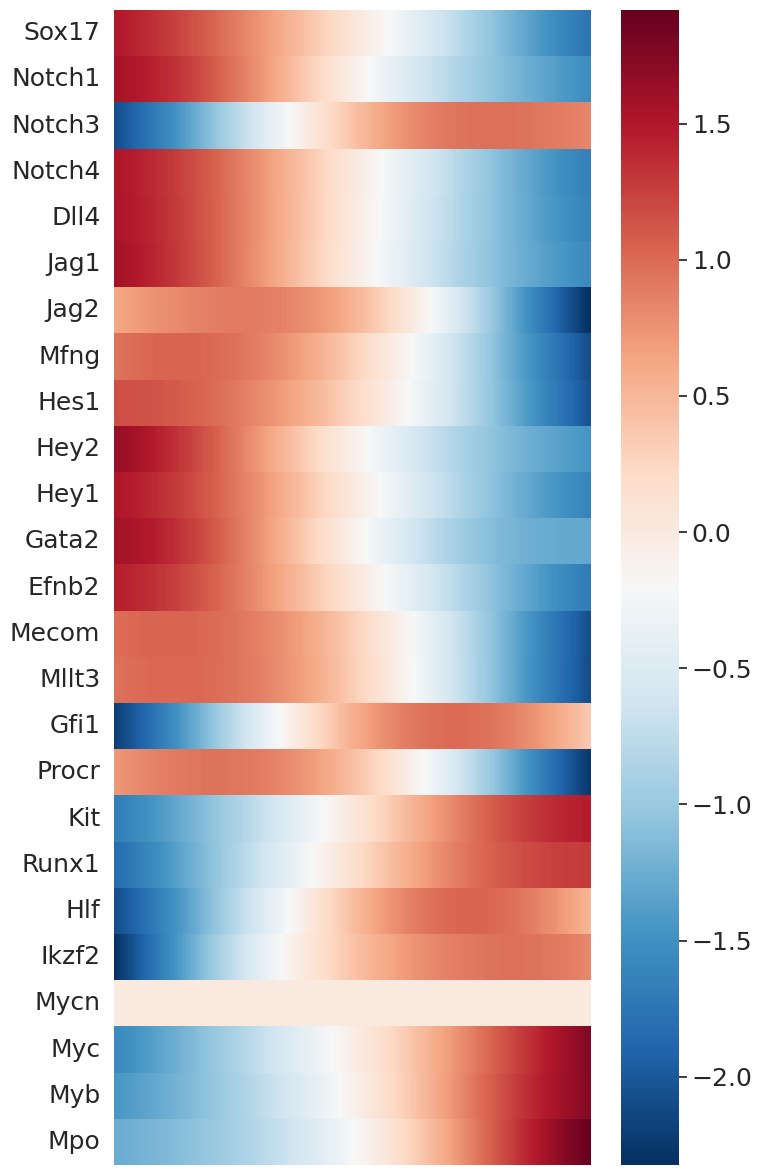

<Figure size 1200x800 with 0 Axes>

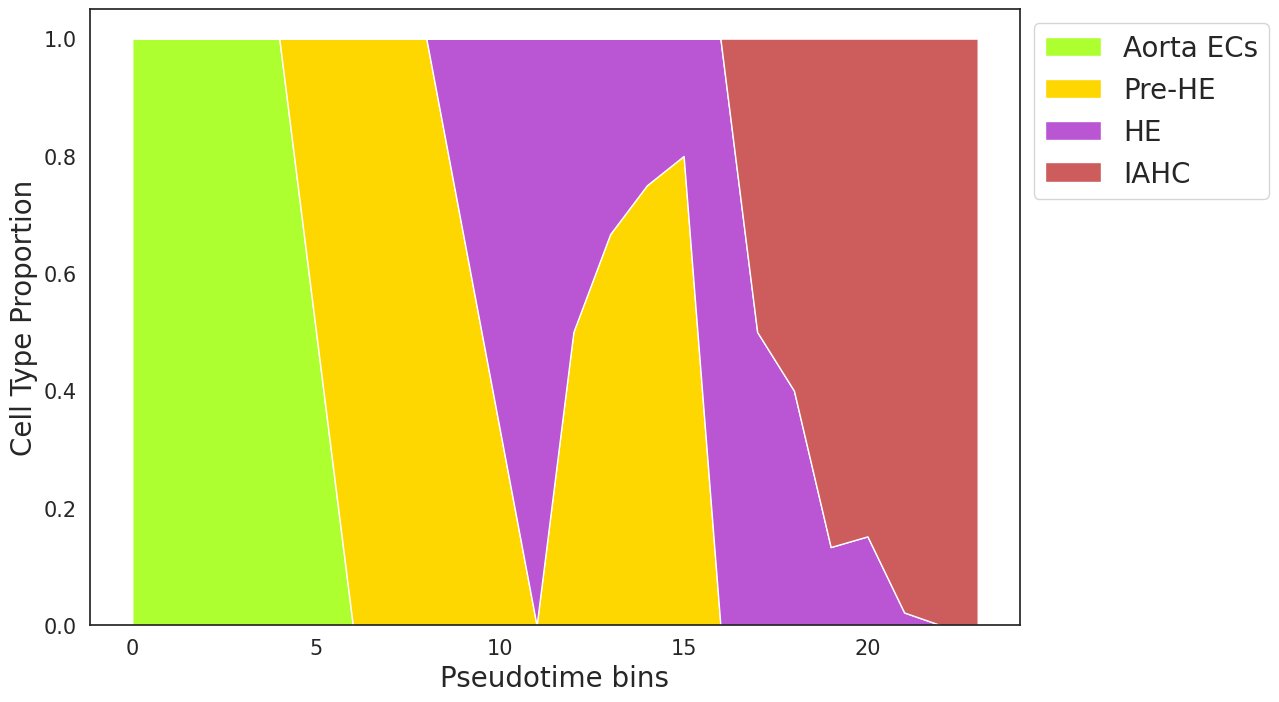

<Figure size 700x300 with 0 Axes>

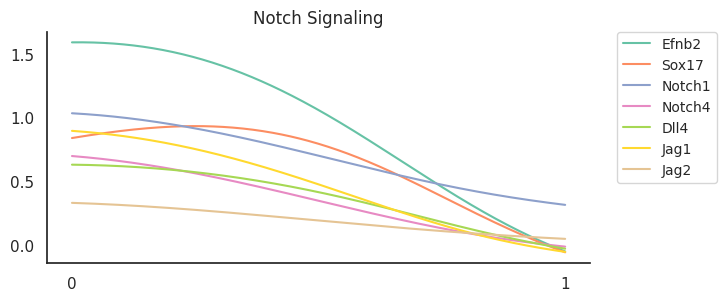

<Figure size 700x300 with 0 Axes>

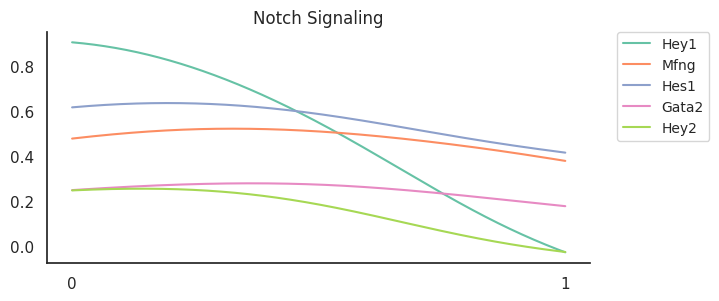

<Figure size 700x300 with 0 Axes>

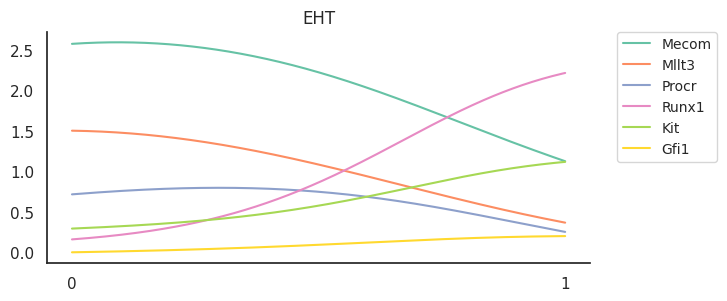

<Figure size 700x300 with 0 Axes>

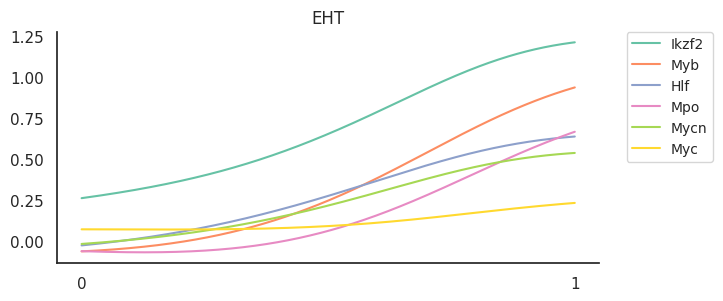

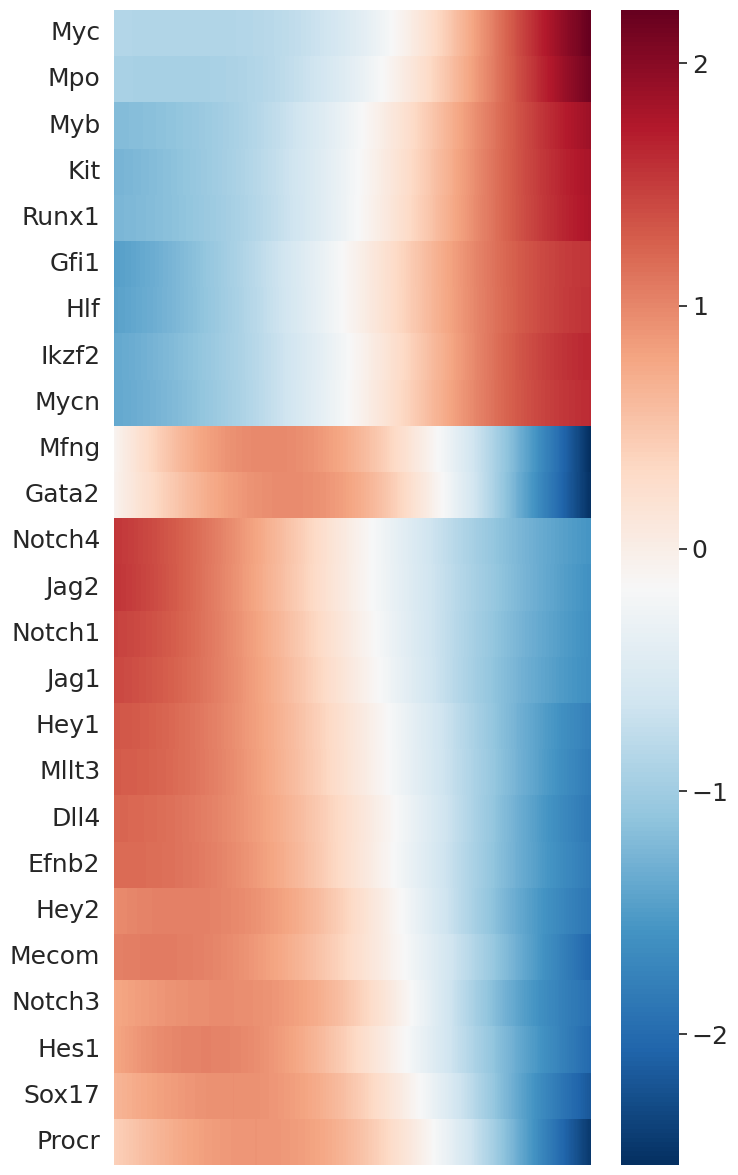

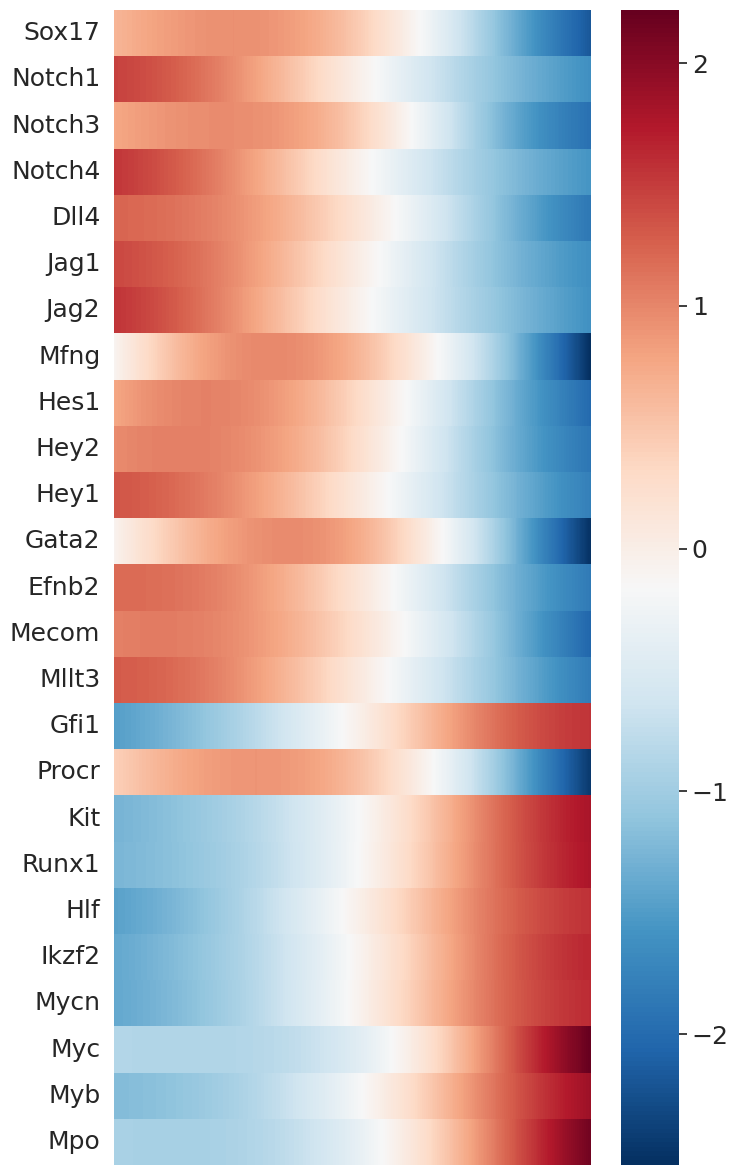

<Figure size 1200x800 with 0 Axes>

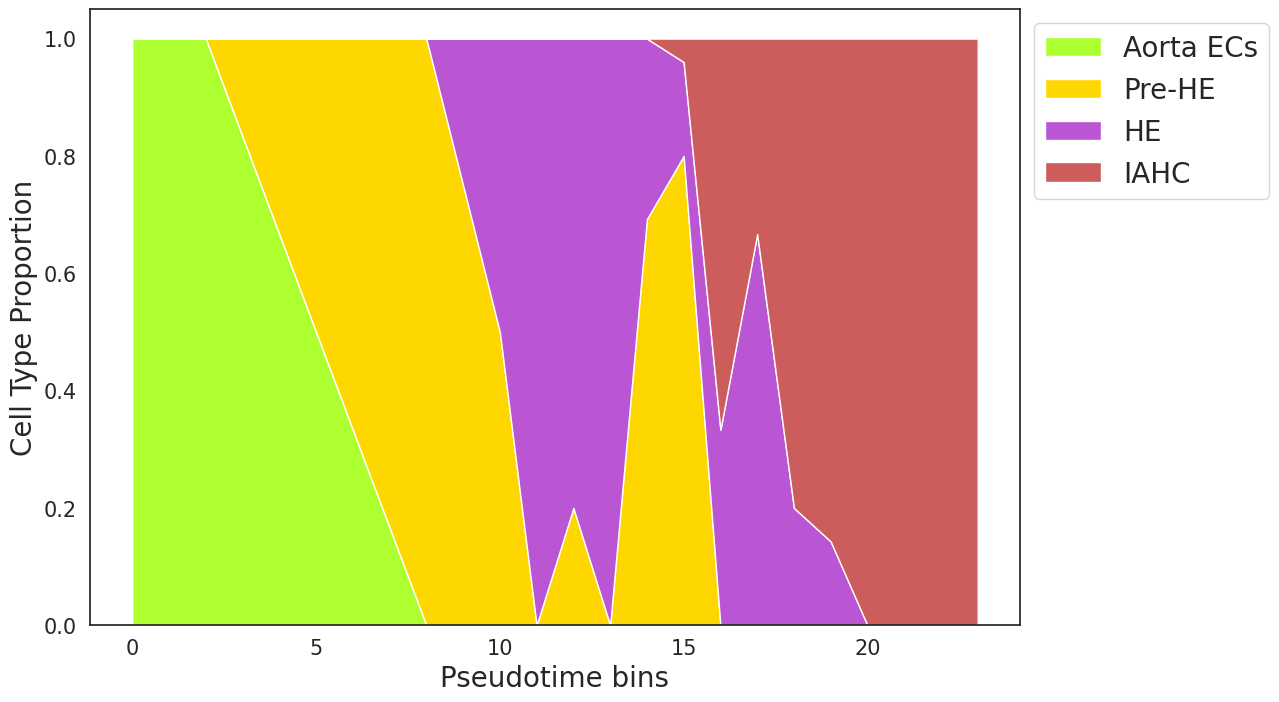

<Figure size 700x300 with 0 Axes>

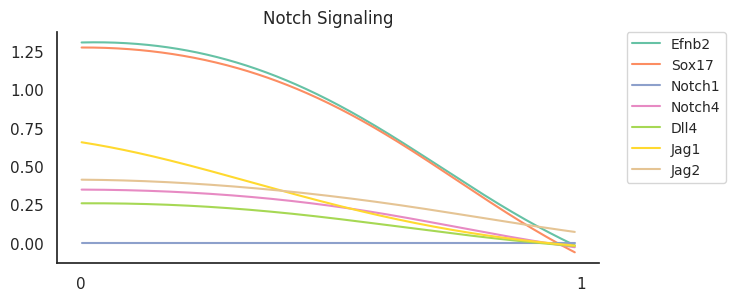

<Figure size 700x300 with 0 Axes>

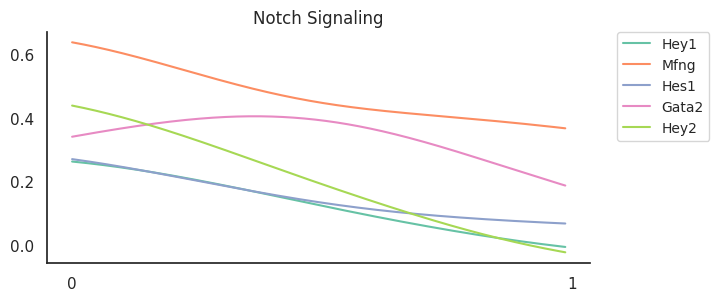

<Figure size 700x300 with 0 Axes>

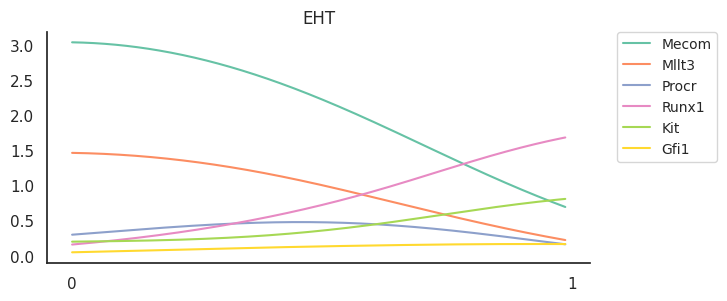

<Figure size 700x300 with 0 Axes>

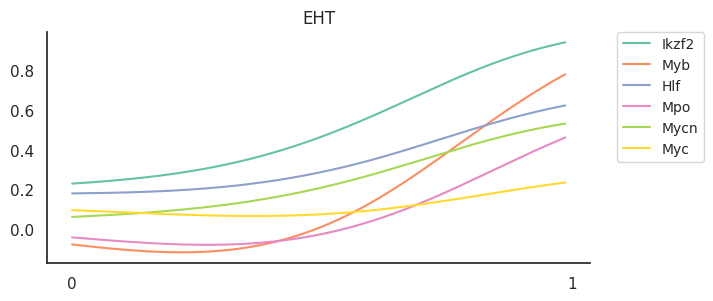

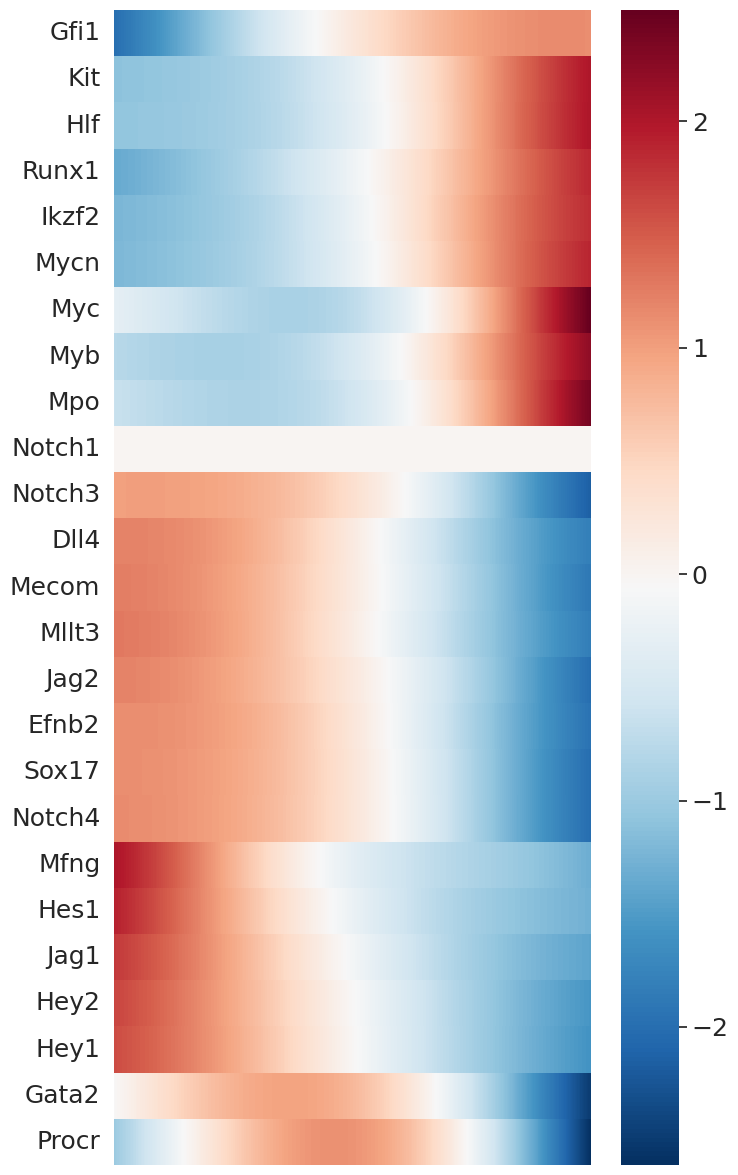

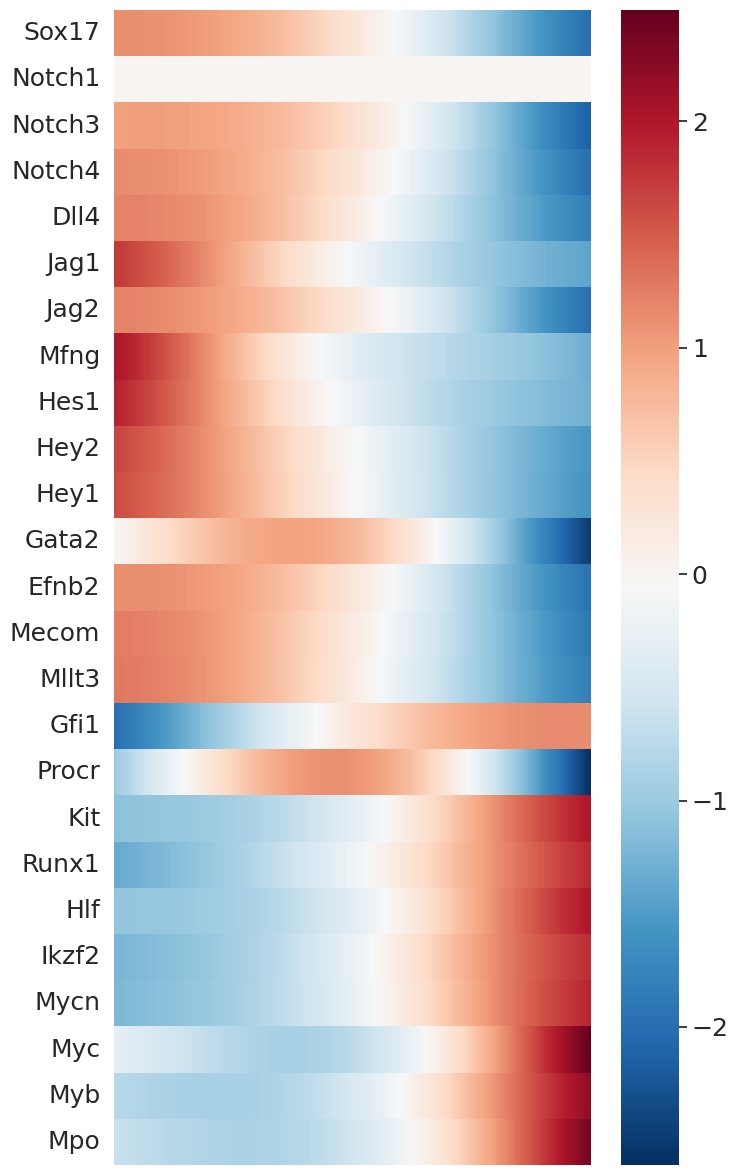

In [108]:
# subset the anndata object per conditions and PResults file as well

Conditions = np.unique(ad_all.obs["Condition"])

for i,cond in enumerate(Conditions):
    cond_dir = str.replace(cond, " ", "_")
    os.makedirs(cond_dir, exist_ok=True)

# Conditions = np.delete(Conditions, [0,1])

for i,cond in enumerate(Conditions):
    ad = ad_all[Cell_ID_per_condition[cond],:]

    # Produced imputed dataframe

    genes = ['Sox17','Notch1', 'Notch3', 'Notch4', 'Dll4', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 
             'Gata2', 'Efnb2', 'Mecom', 'Mllt3','Gfi1', 'Procr', 'Kit', 'Runx1', 'Hlf','Ikzf2', 'Mycn', 'Myc', 'Myb','Mpo']

    
    gene_trends = palantir.presults.compute_gene_trends(ad
                        )
    
    selected_gene_trends = {condition: {'trends': data['trends'].loc[genes]} for condition, data in gene_trends.items()}


    cond_dir = str.replace(cond, " ", "_")

    pseudotime_cell_bins(ad, celltype = "Celltype", order =
                         [0,3,1,2], 
                        # [1, 0, 4, 2, 3],
                         colors = [
    # "#A2CD5A", 
    "#ADFF2F", "#FFD700", "#BA55D3", "#CD5C5C"])

    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_pseudotime_bins.png"]), dpi = 'figure', bbox_inches='tight')
    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_pseudotime_bins.pdf"]), format = 'pdf', bbox_inches='tight')

    plot_gene_trends_group_genes(gene_trends, genes = ['Efnb2','Sox17','Notch1', 'Notch4', 'Dll4', 'Jag1', 'Jag2'], main= "Notch Signaling")

    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_Notch.png"]), dpi = 'figure', bbox_inches='tight')
    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_Notch.pdf"]), format = 'pdf', bbox_inches='tight')

    plot_gene_trends_group_genes(gene_trends, genes = ['Hey1','Mfng', 'Hes1', 'Gata2', 'Hey2'], main= "Notch Signaling")

    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_Notch_downstream.png"]), dpi = 'figure', bbox_inches='tight')
    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_Notch_downstream.pdf"]), format = 'pdf', bbox_inches='tight')

    plot_gene_trends_group_genes(gene_trends, genes = ['Mecom', 'Mllt3','Procr', 'Runx1','Kit','Gfi1'], main= "EHT")

    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_EHT.png"]), dpi = 'figure', bbox_inches='tight')
    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_EHT.pdf"]), format = 'pdf', bbox_inches='tight')

    plot_gene_trends_group_genes(gene_trends, genes = ['Ikzf2','Myb','Hlf', 'Mpo', 'Mycn', 'Myc'], main= "EHT")

    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_EHT_downstream.png"]), dpi = 'figure', bbox_inches='tight')
    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_group_EHT_downstream.pdf"]), format = 'pdf', bbox_inches='tight')
    
    plot_gene_trend_heatmaps_v2(selected_gene_trends, cmap="RdBu_r", cluster_rows=True)

    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_heatmaps.png"]), dpi = 'figure', bbox_inches='tight')
    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_heatmaps.pdf"]), format = 'pdf', bbox_inches='tight')

    plot_gene_trend_heatmaps_v2(selected_gene_trends, cmap="RdBu_r", cluster_rows=False)

    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_heatmaps_regular.png"]), dpi = 'figure', bbox_inches='tight')
    # plt.savefig(''.join([cond_dir, "/", cond_dir,"_gene_trends_heatmaps_regular.pdf"]), format = 'pdf', bbox_inches='tight')

# Plot Gene trends difference of expression among Ctl vs Condition

To make comparisons among Condition v Control another approach can be to substract each pseudotime value from the control to each condition and plot the resulting gene trend line

In [117]:
# subset the anndata object per conditions and PResults file as well

Conditions = np.unique(ad_all.obs["Condition"])

ad = ad_all[ad_all.obs['Condition'].isin(['Control VEQ']),:]

genes = ['Cdh5', 'Notch1', 'Notch3', 'Notch4', 'Dll4', 'Dll1', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 'Gata2', 'Gfi1', 'Procr', 'Kit', 'Runx1', 'Mycn', 'Myc','Gja5', 'Sox17', 'Ikzf2', 'Rac2', 'Myb', 'Mpo']

gene_trends_ctl = palantir.presults.compute_gene_trends(ad)

ad = ad_all[ad_all.obs['Condition'].isin(['Notch1LOF']),:]

gene_trends_cond = palantir.presults.compute_gene_trends(ad)


IAHC
[2024-08-08 16:27:51,131] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (274) and rank = 1.0.
[2024-08-08 16:27:51,131] [INFO    ] Using covariance function Matern52(ls=1.0).
IAHC
[2024-08-08 16:27:51,679] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (142) and rank = 1.0.
[2024-08-08 16:27:51,680] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(


In [137]:
gene_trends_ctl['IAHC']['trends'].columns =range(0, gene_trends_ctl['IAHC']['trends'].shape[1])

gene_trends_ctl['IAHC']['trends'].head()

0         1         2         3         4         5         6    \
Pcmtd1  0.601286  0.601879  0.602469  0.603056  0.603639  0.604219  0.604796   
Cdh7    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Exo1    0.048580  0.048909  0.049239  0.049570  0.049903  0.050237  0.050572   
Becn2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Uxs1    0.109971  0.110302  0.110633  0.110964  0.111295  0.111627  0.111958   

             7         8         9    ...       490       491       492  \
Pcmtd1  0.605369  0.605939  0.606505  ...  0.204549  0.203190  0.201837   
Cdh7    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
Exo1    0.050909  0.051247  0.051586  ...  0.371296  0.372163  0.373025   
Becn2   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
Uxs1    0.112290  0.112621  0.112952  ...  0.183232  0.183058  0.182882   

             493       494       495       496       497       498       499  
Pcmtd1  0.200488  0.199143  0.197803  0.196467  0.195136  0.193810  0.192488  
Cdh7    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
Exo1    0.373885  0.374741  0.375594  0.376443  0.377289  0.378132  0.378971  
Becn2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
Uxs1    0.182705  0.182527  0.182348  0.182167  0.181985  0.181803  0.181619  

[5 rows x 500 columns]

<Figure size 700x300 with 0 Axes>

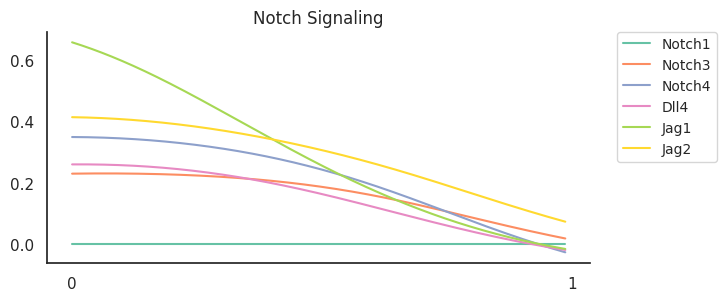

In [135]:
plot_gene_trends_group_genes(gene_trends_cond, genes = ['Notch1', 'Notch3', 'Notch4', 'Dll4', 'Jag1', 'Jag2'], main= "Notch Signaling")

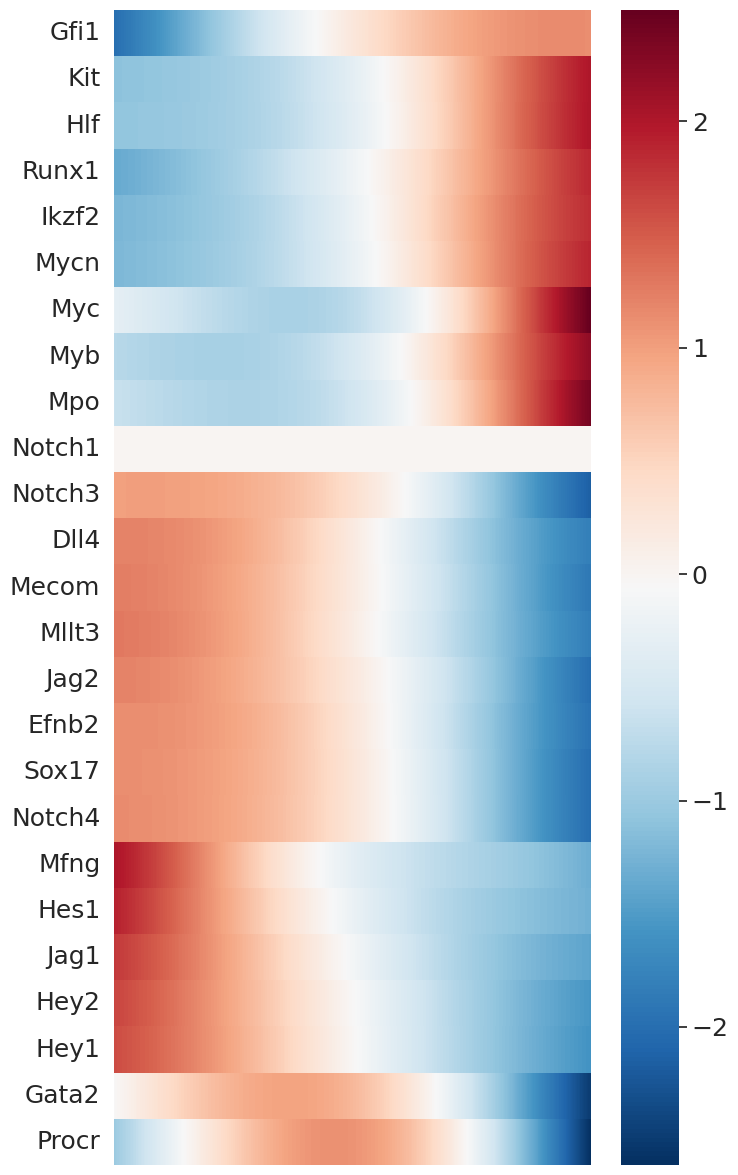

In [131]:
plot_gene_trend_heatmaps_v2(selected_gene_trends, cmap="RdBu_r", cluster_rows=True)

In [280]:

Conditions = np.unique(ad_all.obs["Condition"])
Conditions

array(['Control', 'Control VEQ', 'Jag1LOF', 'Mfng GOF', 'Nmyc LOF',
       'Notch1 GOF', 'Notch1LOF'], dtype=object)

## Loop for doing it in all conditions

From the 5 conditions, 3 had to be compared with Control Tie2-Cre and 2 with Control Cdh5-Cre. In this Ntebook I depict only the conditions compared with the latter.

Considering Control and Control VEQ

In [132]:
# subset the anndata object per conditions and PResults file as well

Conditions = np.unique(ad_all.obs["Condition"])

# Control Tie2Cre

# Conditions = np.delete(Conditions, [0,1,2,6])

# Control VEQ

Conditions = np.delete(Conditions, [0,1,3,4,5])

genes = ['Sox17','Notch1', 'Notch3', 'Notch4', 'Dll4', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 'Efnb2',
             'Gata2', 'Mecom', 'Mllt3','Gfi1', 'Procr', 'Kit', 'Runx1', 'Hlf','Ikzf2', 'Mycn', 'Myc', 'Myb','Mpo']

print(Conditions)


# Text for control and conditions
Control_text = ['$\mathrm{Control^{Tie2Cre}}$', '$\mathrm{Control^{Cdh5Cre}}$']

Conditions_text = ['$Jag1^{\mathrm{iDEC}}$', '$Notch1^{\mathrm{iDEC}}$', '$Mfng^{\mathrm{iOE Tie2Cre}}$',  '$NMyc^{\mathrm{LOF Tie2Cre}}$', '$Notch1^{\mathrm{iOE Tie2Cre}}$']



['Jag1LOF' 'Notch1LOF']


<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_34193/4192277144.py:20: SyntaxWarning: invalid escape sequence '\m'
  Control_text = ['$\mathrm{Control^{Tie2Cre}}$', '$\mathrm{Control^{Cdh5Cre}}$']
/tmp/ipykernel_34193/4192277144.py:20: SyntaxWarning: invalid escape sequence '\m'
  Control_text = ['$\mathrm{Control^{T

In [133]:
print(Conditions_text[2:5])
print(Conditions)

['$Mfng^{\\mathrm{iOE Tie2Cre}}$', '$NMyc^{\\mathrm{LOF Tie2Cre}}$', '$Notch1^{\\mathrm{iOE Tie2Cre}}$']
['Jag1LOF' 'Notch1LOF']


IAHC
[2024-08-08 16:32:14,766] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (147) and rank = 1.0.
[2024-08-08 16:32:14,767] [INFO    ] Using covariance function Matern52(ls=1.0).


IAHC
[2024-08-08 16:32:15,354] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (274) and rank = 1.0.
[2024-08-08 16:32:15,355] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(


IAHC
[2024-08-08 16:32:18,018] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (142) and rank = 1.0.
[2024-08-08 16:32:18,019] [INFO    ] Using covariance function Matern52(ls=1.0).
IAHC
[2024-08-08 16:32:18,580] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (274) and rank = 1.0.
[2024-08-08 16:32:18,580] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(


<Figure size 700x300 with 0 Axes>

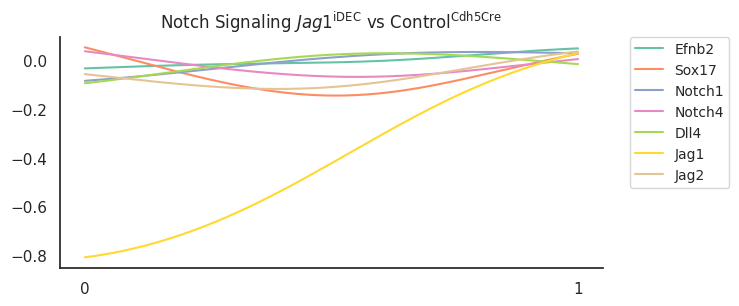

<Figure size 700x300 with 0 Axes>

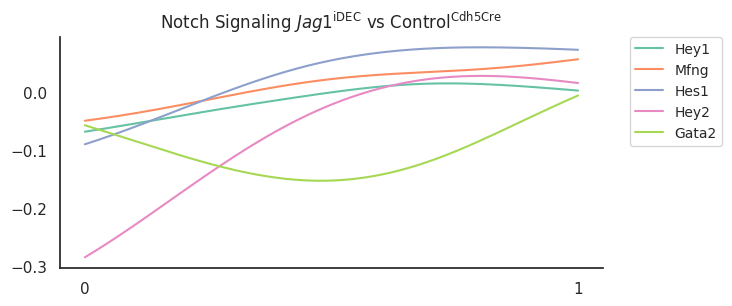

<Figure size 700x300 with 0 Axes>

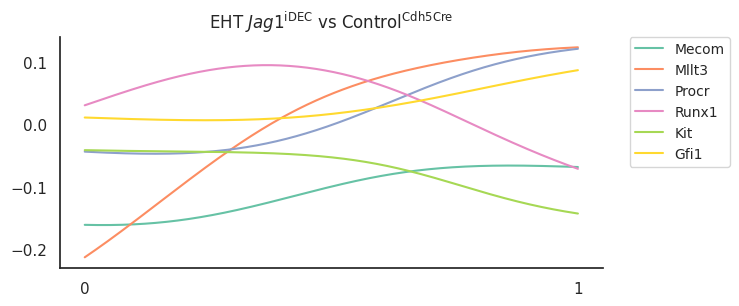

<Figure size 700x300 with 0 Axes>

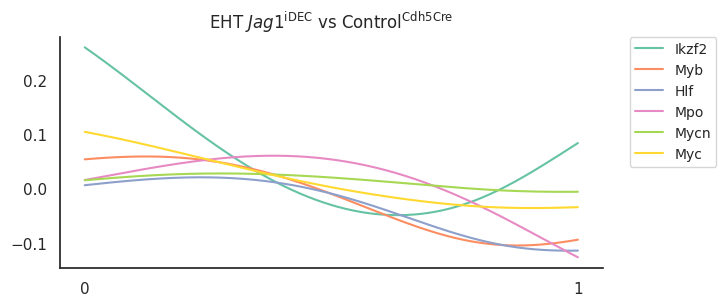

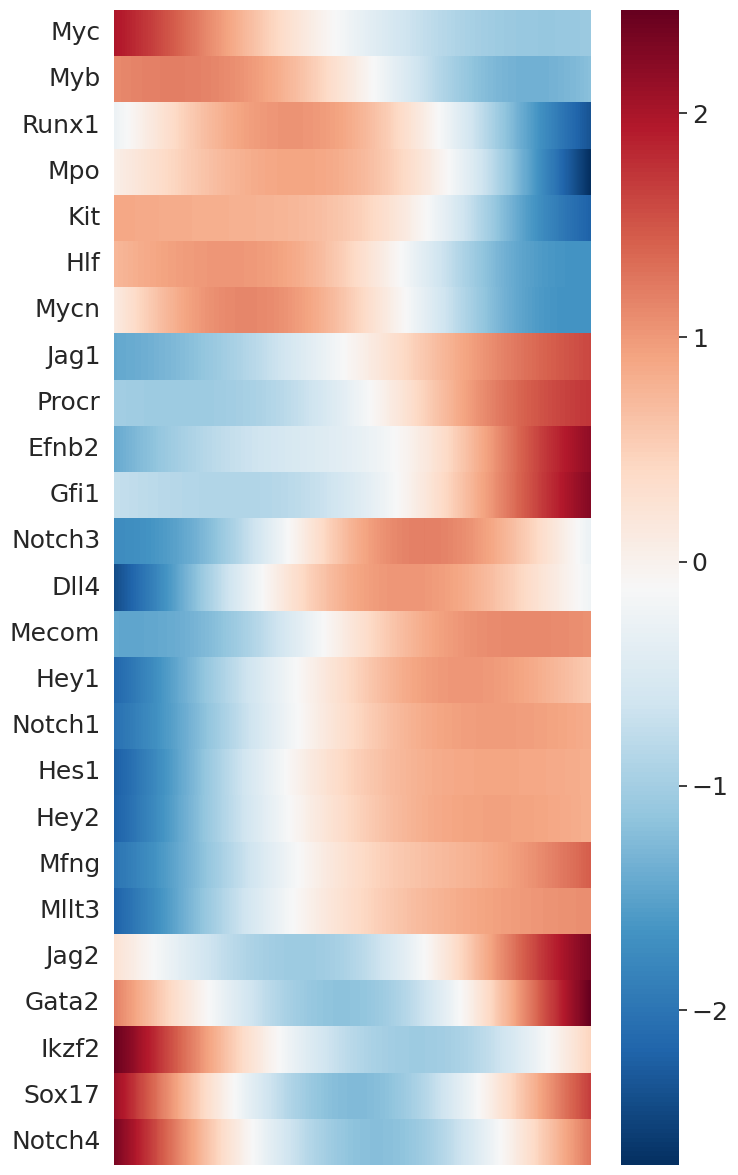

<Figure size 700x300 with 0 Axes>

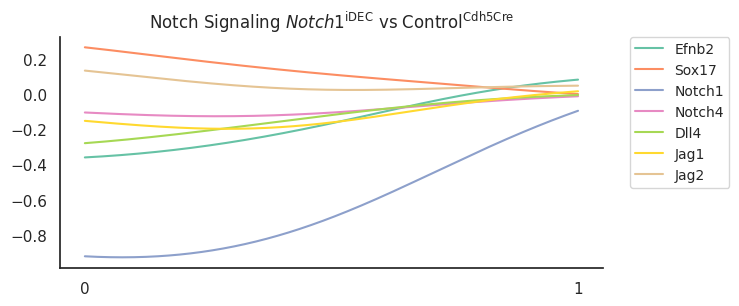

<Figure size 700x300 with 0 Axes>

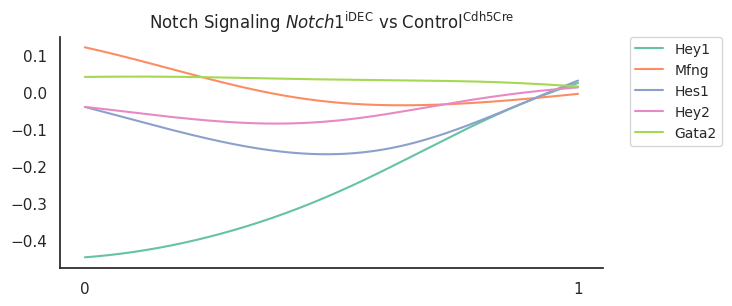

<Figure size 700x300 with 0 Axes>

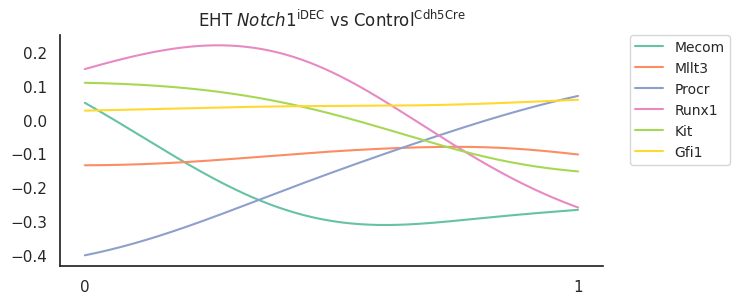

<Figure size 700x300 with 0 Axes>

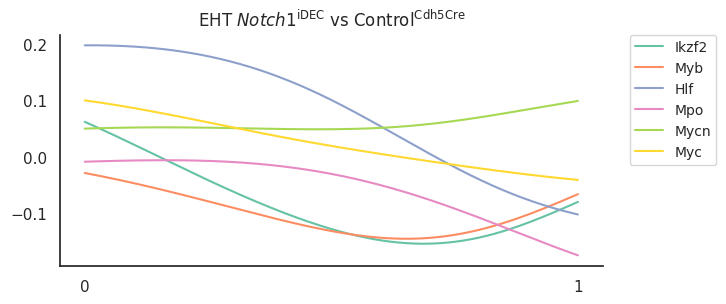

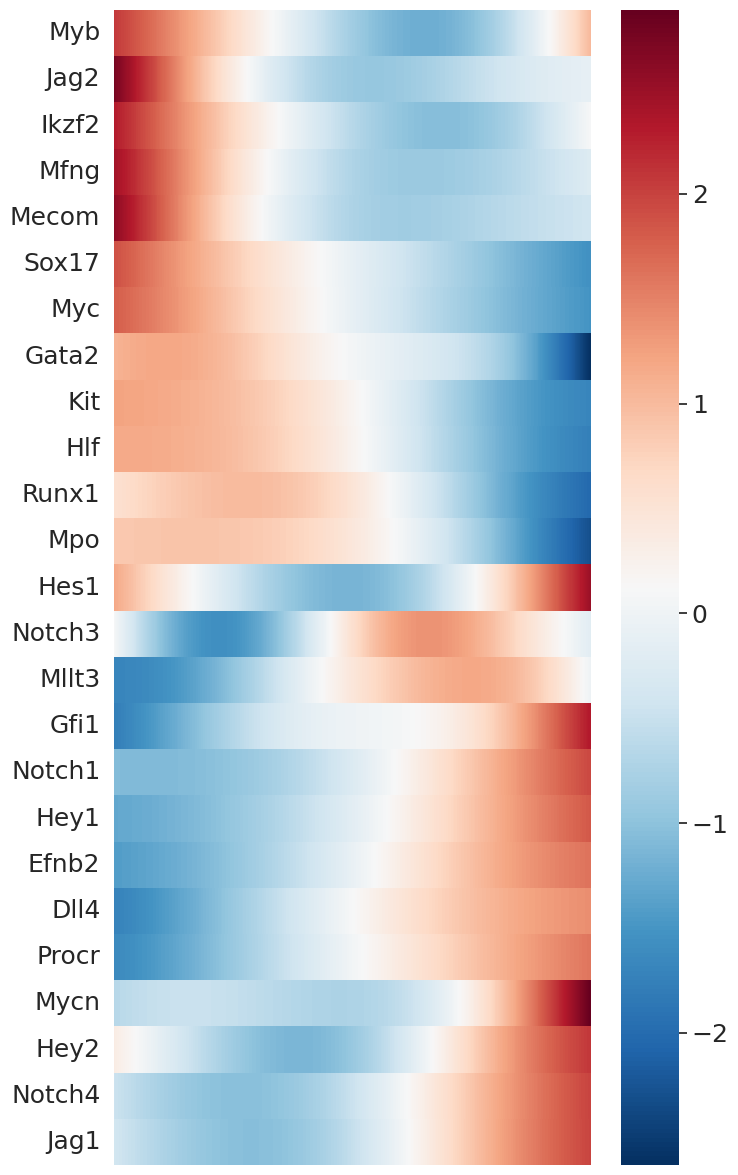

In [138]:
setup_gene_trends_cond_vs_ctl(ad_all, genes, Cell_ID_per_condition, Control_name='Control VEQ', Conditions=Conditions, 
                              Control_text = Control_text[1], Condition_name = Conditions_text[0:2])

## Gene trends differential analysis. Selected genes

In [149]:
genes = ['Sox17','Notch1', 'Notch4', 'Dll4', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 'Efnb2',
             'Gata2', 'Mecom', 'Mllt3','Gfi1', 'Procr', 'Kit', 'Runx1', 'Hlf','Ikzf2', 'Mycn', 'Myc', 'Myb','Mpo']

genes_N1GOF = ['Jag1', 'Hes1', 'Gata2', 'Hey1', 'Mecom', 'Runx1']



genes_N1LOF = ['Notch1', 'Dll4', 'Jag1', 'Hey1', 'Procr', 'Mecom']
genes_J1LOF = ['Jag1', 'Gata2', 'Mecom', 'Sox17', 'Hey2', 'Hlf']
genes_MfngGOF = ['Jag1', 'Hes1', 'Gata2', 'Runx1', 'Mycn', 'Mecom']
genes_NMycLOF = ['Mycn', 'Runx1', 'Hey1', 'Gata2', 'Hlf', 'Ikzf2']

genes = [genes_N1GOF, genes_N1LOF, genes_J1LOF, genes_MfngGOF, genes_NMycLOF]

# subset the anndata object per conditions and PResults file as well

Conditions = np.unique(ad_all.obs["Condition"])

# Control Tie2Cre

# Conditions = np.delete(Conditions, [0,1,2,6])

# Control VEQ

Conditions = np.delete(Conditions, [0,1,3,4,5])

print(Conditions)

selected_genes = [genes[i] for i in 
                #   [3,4,0] # Tie2Cre
                  [2,1] # VEQ
                  ]
print(selected_genes)

['Jag1LOF' 'Notch1LOF']
[['Jag1', 'Gata2', 'Mecom', 'Sox17', 'Hey2', 'Hlf'], ['Notch1', 'Dll4', 'Jag1', 'Hey1', 'Procr', 'Mecom']]


In [140]:
# Text for control and conditions
Control_text = ['$\mathrm{Control^{Tie2Cre}}$', '$\mathrm{Control^{Cdh5Cre}}$']

Conditions_text = ['$Jag1^{\mathrm{iDEC}}$', '$Notch1^{\mathrm{iDEC}}$', '$Mfng^{\mathrm{iOE Tie2Cre}}$',  '$NMyc^{\mathrm{LOF Tie2Cre}}$', '$Notch1^{\mathrm{iOE Tie2Cre}}$']

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_34193/185510342.py:2: SyntaxWarning: invalid escape sequence '\m'
  Control_text = ['$\mathrm{Control^{Tie2Cre}}$', '$\mathrm{Control^{Cdh5Cre}}$']
/tmp/ipykernel_34193/185510342.py:2: SyntaxWarning: invalid escape sequence '\m'
  Control_text = ['$\mathrm{Control^{Tie2Cre}}$', '$\mat

IAHC
[2024-08-08 16:35:13,150] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (147) and rank = 1.0.
[2024-08-08 16:35:13,151] [INFO    ] Using covariance function Matern52(ls=1.0).
IAHC
[2024-08-08 16:35:13,734] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (274) and rank = 1.0.
[2024-08-08 16:35:13,734] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(


IAHC
[2024-08-08 16:35:14,558] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (142) and rank = 1.0.
[2024-08-08 16:35:14,558] [INFO    ] Using covariance function Matern52(ls=1.0).
IAHC
[2024-08-08 16:35:15,126] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (274) and rank = 1.0.
[2024-08-08 16:35:15,127] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(


<Figure size 700x300 with 0 Axes>

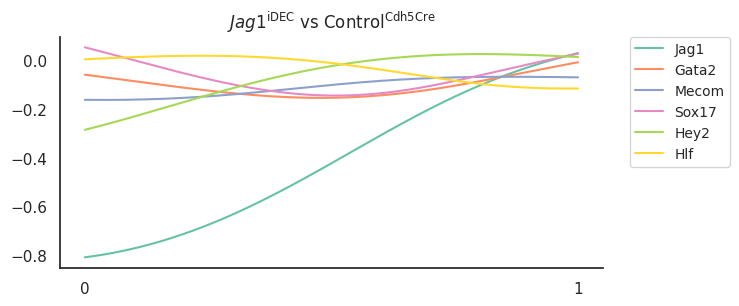

<Figure size 700x300 with 0 Axes>

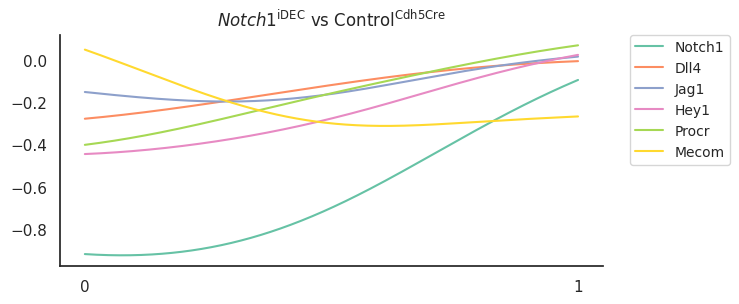

In [152]:
setup_gene_trends_selected_cond_vs_ctl(ad_all, selected_genes, Cell_ID_per_condition, Control_name='Control VEQ', Conditions=Conditions, Control_text = Control_text[1], 
                                       Condition_name = Conditions_text[0:2])

# Gene trends Ctl vs Condition

Instead of substracting gene trends here I depict them side by side, with Control adopting a gray color and the condition in red.

`plot_gene-trends-manual` plots the gene trend and allows for manual selection of colors

`setup_gene_trends_selected_cond_vs_ctl_gene_split` produces a loop of the selected groups in which the various selected genes are ploted with control and condition in the same graph

In [142]:
def plot_gene_trends_manual(
    gene_trends,
    color_palette = None,
    genes = None,
) -> plt.Figure:
    """
    Plot the gene trends for each gene across different panels.

    Parameters
    ----------
    data : Union[Dict, sc.AnnData]
        An AnnData object or a dictionary that contains the gene trends.
    genes : Optional[List[str]], optional
        A list of genes to plot. If not provided, all genes will be plotted. Default is None.
    gene_trend_key : str, optional
        The key to access gene trends in the varm of the AnnData object. Default is 'gene_trends'.
    branch_names : Union[str, List[str]], optional
        Key to retrieve branch names from the AnnData object, or a list of branch names. If a string is provided,
        it will be treated as a key in either AnnData.uns or AnnData.obsm. For AnnData.obsm, the column names will
        be treated as branch names. If it cannot be found in AnnData.obsm and AnnData.uns then branch_names + "_columns"
        will be looked up in AnnData.uns.
        Default is 'branch_masks'.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure object containing the plot.

    Raises
    ------
    KeyError
        If 'branch_names' as a string is not found in either .uns or .obsm, or if 'gene_trend_key + "_" + branch_name'
        is not found in .varm.
    ValueError
        If 'data' is not an AnnData object and not a dictionary.
    """
    # Branches and genes
    branches = list(gene_trends.keys())
    if color_palette == None:
     set2_colors = matplotlib.colormaps["Set2"](range(len(branches)))
     colors = pd.Series(
        [matplotlib.colors.rgb2hex(rgba) for rgba in set2_colors],
        index=branches,
     )

    colors = pd.Series(
        color_palette,
        index=branches,
     )
    
    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    # Set up figure
    fig = plt.figure(figsize=[7, 3 * len(genes)])
    for i, gene in enumerate(genes):
        ax = fig.add_subplot(len(genes), 1, i + 1)
        for branch in branches:
            trends = gene_trends[branch]["trends"]
            ax.plot(
                trends.columns.astype(float),
                trends.loc[gene, :],
                color=colors[branch],
                label=branch,
            )
            ax.set_xticks([])
            ax.set_title(gene, fontdict={'fontstyle':'italic'})

        # Add legend
        if i == 0:
            ax.legend()

    return fig


In [153]:
def setup_gene_trends_selected_cond_vs_ctl_gene_split(ad_all, genes, Cell_ID, Control_name = 'Control', Conditions = 'Control', Condition_name = None, Control_text = 'Control'):
 if Condition_name is None:
    Condition_name = Conditions
 for i,cond in enumerate(Conditions):
    ad = ad_all[Cell_ID[cond],:]
    target_genes = genes[i]
    cond_text = Condition_name[i]
    # Without MAGIC

    gene_trends_cond = palantir.presults.compute_gene_trends(ad)
    
    gene_trends_cond = {condition: {'trends': data['trends'].loc[target_genes]} for condition, data in gene_trends_cond.items()}
    
# Gene trends for Control 
    ad = ad_all[ad_all.obs['Condition'].isin([Control_name]),:]

    gene_trends_ctl = palantir.presults.compute_gene_trends(ad)
    
    gene_trends_ctl = {condition: {'trends': data['trends'].loc[target_genes]} for condition, data in gene_trends_ctl.items()}

    cond_dir = str.replace(cond, " ", "_")
     
    gene_trends = OrderedDict()
    
    inner_dict = OrderedDict({'trends': gene_trends_ctl['IAHC']['trends']})

    gene_trends[Control_text] = inner_dict
    
    inner_dict = OrderedDict({'trends': gene_trends_cond['IAHC']['trends']})
    
    gene_trends[Condition_name[i]] = inner_dict
    
    os.makedirs(''.join([cond_dir, "/CondvCtl"]), exist_ok=True)

    plot_gene_trends_manual(gene_trends, color_palette= ['#808080', '#FF0000'])

   #  plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_selected_gene_split.png"]), dpi = 'figure', bbox_inches='tight')
   #  plt.savefig(''.join([cond_dir, "/CondvCtl/", cond_dir,"_gene_trends_selected_gene_split.pdf"]), format = 'pdf', bbox_inches='tight')


Select the genes of interest per condition

In [154]:
genes = ['Sox17','Notch1', 'Notch4', 'Dll4', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Hey1', 'Efnb2',
             'Gata2', 'Mecom', 'Mllt3','Gfi1', 'Procr', 'Kit', 'Runx1', 'Hlf','Ikzf2', 'Mycn', 'Myc', 'Myb','Mpo']

genes_N1GOF = ['Jag1', 'Hes1', 'Gata2', 'Hey1', 'Mecom', 'Runx1']
# Convert goi to a set for faster lookups
set_genes = set(genes_N1GOF)
# Use list comprehension with set lookup
genes_N1GOF = [gene for gene in genes if gene not in set_genes]

genes_N1LOF = ['Notch1', 'Dll4', 'Jag1', 'Hey1', 'Procr', 'Mecom']
# Convert goi to a set for faster lookups
set_genes = set(genes_N1LOF)
# Use list comprehension with set lookup
genes_N1LOF = [gene for gene in genes if gene not in set_genes]

genes_J1LOF = ['Sox17', 'Jag1', 'Hey2', 'Gata2', 'Mecom', 'Hlf']
# Convert goi to a set for faster lookups
set_genes = set(genes_J1LOF)
# Use list comprehension with set lookup
genes_J1LOF = [gene for gene in genes if gene not in set_genes]

genes_MfngGOF = ['Jag1', 'Hes1', 'Gata2', 'Mecom', 'Runx1', 'Mycn']
# Convert goi to a set for faster lookups
set_genes = set(genes_MfngGOF)
# Use list comprehension with set lookup
genes_MfngGOF = [gene for gene in genes if gene not in set_genes]

genes_NMycLOF = [ 'Hey1', 'Gata2', 'Runx1','Hlf', 'Mycn', 'Ikzf2']
# Convert goi to a set for faster lookups
set_genes = set(genes_NMycLOF)
# Use list comprehension with set lookup
genes_NMycLOF = [gene for gene in genes if gene not in set_genes]


genes = [genes_N1GOF, genes_N1LOF, genes_J1LOF, genes_MfngGOF, genes_NMycLOF]

print(genes)


[['Sox17', 'Notch1', 'Notch4', 'Dll4', 'Jag2', 'Mfng', 'Hey2', 'Efnb2', 'Mllt3', 'Gfi1', 'Procr', 'Kit', 'Hlf', 'Ikzf2', 'Mycn', 'Myc', 'Myb', 'Mpo'], ['Sox17', 'Notch4', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Efnb2', 'Gata2', 'Mllt3', 'Gfi1', 'Kit', 'Runx1', 'Hlf', 'Ikzf2', 'Mycn', 'Myc', 'Myb', 'Mpo'], ['Notch1', 'Notch4', 'Dll4', 'Jag2', 'Mfng', 'Hes1', 'Hey1', 'Efnb2', 'Mllt3', 'Gfi1', 'Procr', 'Kit', 'Runx1', 'Ikzf2', 'Mycn', 'Myc', 'Myb', 'Mpo'], ['Sox17', 'Notch1', 'Notch4', 'Dll4', 'Jag2', 'Mfng', 'Hey2', 'Hey1', 'Efnb2', 'Mllt3', 'Gfi1', 'Procr', 'Kit', 'Hlf', 'Ikzf2', 'Myc', 'Myb', 'Mpo'], ['Sox17', 'Notch1', 'Notch4', 'Dll4', 'Jag1', 'Jag2', 'Mfng', 'Hes1', 'Hey2', 'Efnb2', 'Mecom', 'Mllt3', 'Gfi1', 'Procr', 'Kit', 'Myc', 'Myb', 'Mpo']]


In [145]:
genes_N1GOF = ['Jag1', 'Hey1', 'Hes1', 'Gata2',  'Mecom', 'Runx1']
genes_N1LOF = ['Notch1', 'Dll4', 'Jag1', 'Hey1', 'Procr', 'Mecom']
genes_J1LOF = ['Sox17', 'Jag1', 'Hey2', 'Gata2', 'Mecom', 'Hlf']
genes_MfngGOF = ['Jag1', 'Hes1', 'Gata2', 'Mecom', 'Runx1', 'Mycn']
genes_NMycLOF = [ 'Hey1', 'Gata2', 'Runx1','Hlf', 'Mycn', 'Ikzf2']

genes = [genes_N1GOF, genes_N1LOF, genes_J1LOF, genes_MfngGOF, genes_NMycLOF]

Organize the anndata object so conditions match with their respective Control

In [146]:


# subset the anndata object per conditions and PResults file as well

Conditions = np.unique(ad_all.obs["Condition"])

# Control Tie2Cre

# Conditions = np.delete(Conditions, [0,1,2,6])

# Control VEQ

Conditions = np.delete(Conditions, [0,1,3,4,5])

print(Conditions)

selected_genes = [genes[i] for i in 
                #   [3,4,0] # Tie2Cre
                  [2,1] # VEQ
                  ]
print(selected_genes)

['Jag1LOF' 'Notch1LOF']
[['Sox17', 'Jag1', 'Hey2', 'Gata2', 'Mecom', 'Hlf'], ['Notch1', 'Dll4', 'Jag1', 'Hey1', 'Procr', 'Mecom']]


In [147]:
# Text for control and conditions
Control_text = ['$\mathrm{Control^{Tie2Cre}}$', '$\mathrm{Control^{Cdh5Cre}}$']

Conditions_text = ['$Jag1^{\mathrm{iDEC}}$', '$Notch1^{\mathrm{iDEC}}$', '$Mfng^{\mathrm{iOE Tie2Cre}}$',  '$NMyc^{\mathrm{LOF Tie2Cre}}$', '$Notch1^{\mathrm{iOE Tie2Cre}}$']

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_34193/185510342.py:2: SyntaxWarning: invalid escape sequence '\m'
  Control_text = ['$\mathrm{Control^{Tie2Cre}}$', '$\mathrm{Control^{Cdh5Cre}}$']
/tmp/ipykernel_34193/185510342.py:2: SyntaxWarning: invalid escape sequence '\m'
  Control_text = ['$\mathrm{Control^{Tie2Cre}}$', '$\mat

IAHC
[2024-08-08 16:33:40,907] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (147) and rank = 1.0.
[2024-08-08 16:33:40,907] [INFO    ] Using covariance function Matern52(ls=1.0).
IAHC
[2024-08-08 16:33:41,479] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (274) and rank = 1.0.
[2024-08-08 16:33:41,480] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(


IAHC
[2024-08-08 16:33:42,631] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (142) and rank = 1.0.
[2024-08-08 16:33:42,631] [INFO    ] Using covariance function Matern52(ls=1.0).
IAHC
[2024-08-08 16:33:43,201] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (274) and rank = 1.0.
[2024-08-08 16:33:43,202] [INFO    ] Using covariance function Matern52(ls=1.0).


/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(
/home/alvaro/miniconda3/lib/python3.12/site-packages/palantir/presults.py:316: ImplicitModificationWarning: Setting element `.varm['gene_trends_IAHC']` of view, initializing view as actual.
  ad.varm[gene_trend_key + "_" + branch] = pd.DataFrame(


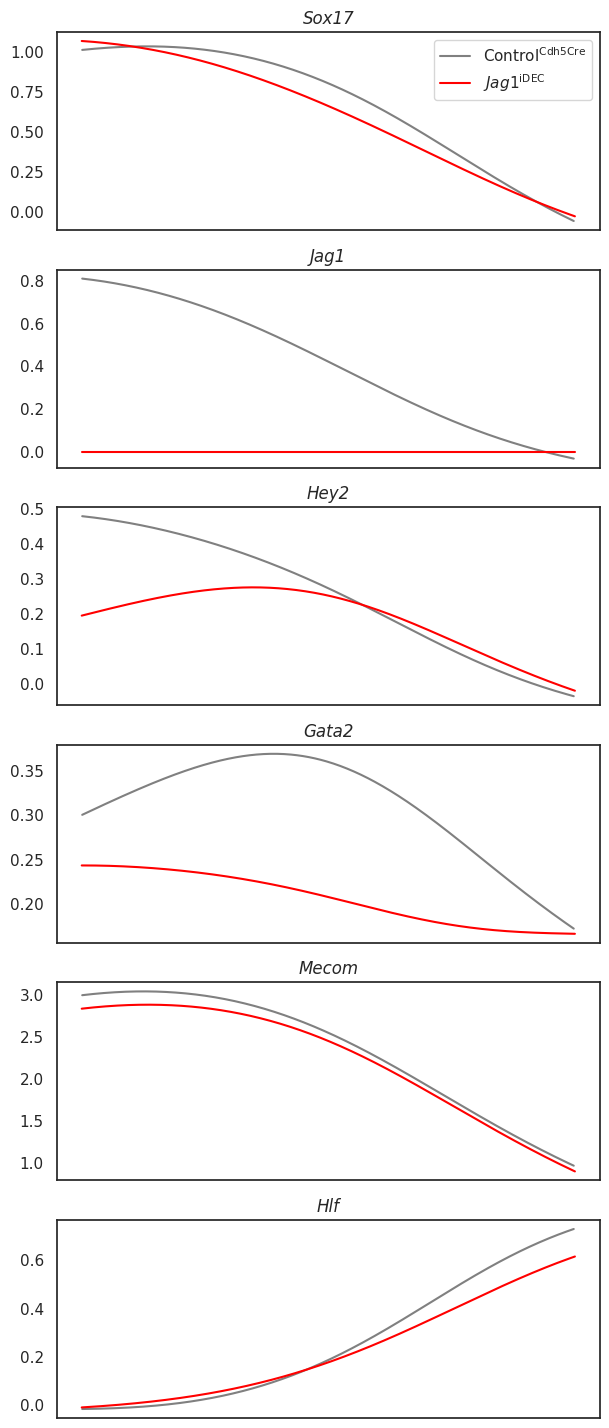

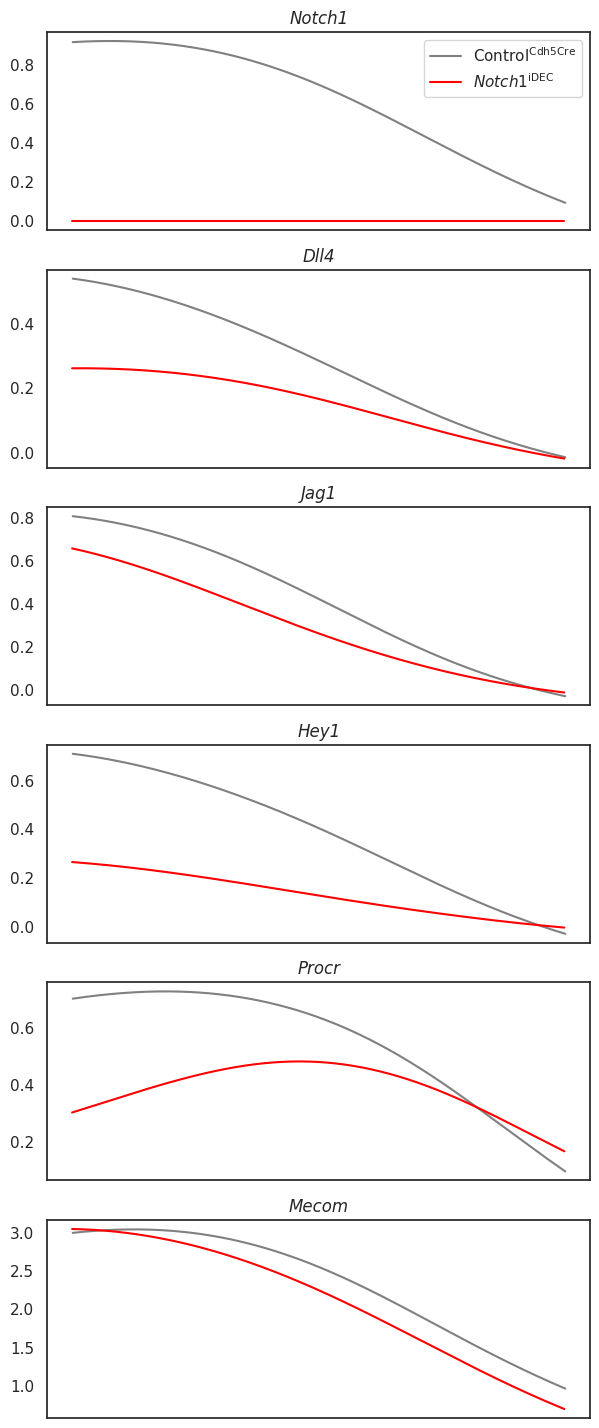

In [148]:
setup_gene_trends_selected_cond_vs_ctl_gene_split(ad_all, selected_genes, Cell_ID_per_condition, Control_name='Control VEQ', Conditions=Conditions, Control_text = Control_text[1], 
                                       Condition_name = Conditions_text[0:2])

In [156]:
import session_info

session_info.show()